In [1]:
# Loading Dataset 

In [2]:
# Notebook cell — run once if needed
!pip install docx2txt PyMuPDF pytesseract sentence-transformers joblib scikit-learn pandas tqdm umap-learn matplotlib seaborn
# Notebook cell or terminal
!pip install -U pip
!pip install pandas numpy scikit-learn scipy matplotlib seaborn joblib tqdm sentence-transformers shap streamlit wordcloud nltk
# optional for xgboost/lightgbm:
!pip install xgboost lightgbm

In [3]:
# Notebook cell: run this to extract all resumes to data/extracted/
import os
from pathlib import Path
import docx2txt
import fitz   # PyMuPDF
from PIL import Image
import io
import pytesseract
import traceback

# Paths (adjust if needed)
RESUME_DIR = Path("Resume")   # your folder with 79 .docx/.pdf files
OUT_DIR = Path("data/extracted")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Helpers
def extract_text_from_docx(path):
    try:
        return docx2txt.process(path) or ""
    except Exception as e:
        return f"__ERROR_DOCX__: {e}"

def extract_text_from_pdf(path):
    text_parts = []
    try:
        doc = fitz.open(path)
        for page_idx in range(len(doc)):
            page = doc.load_page(page_idx)
            page_text = page.get_text().strip()
            if page_text:
                text_parts.append(page_text)
            else:
                # fallback: render page image and OCR
                try:
                    pix = page.get_pixmap(dpi=200)  # render
                    img = Image.open(io.BytesIO(pix.tobytes()))
                    ocr_text = pytesseract.image_to_string(img)
                    text_parts.append(ocr_text)
                except Exception as e:
                    text_parts.append(f"__PDF_PAGE_OCR_ERROR__ page {page_idx}: {e}")
        return "\n".join(text_parts)
    except Exception as e:
        return f"__ERROR_PDF__: {e}"

# Process all files
processed = []
unsupported = []
errors = []
for file in sorted(RESUME_DIR.iterdir()):
    if not file.is_file(): 
        continue
    ext = file.suffix.lower()
    out_path = OUT_DIR / (file.stem + ".txt")
    try:
        text = ""
        if ext == ".docx":
            text = extract_text_from_docx(str(file))
        elif ext == ".pdf":
            text = extract_text_from_pdf(str(file))
        elif ext == ".doc":
            # we will skip .doc for now but list them
            unsupported.append(str(file))
            text = ""
        else:
            unsupported.append(str(file))
            text = ""
        # ensure a non-empty string to avoid zero-byte files
        if text is None:
            text = ""
        out_path.write_text(text, encoding="utf-8", errors="replace")
        processed.append(str(file))
    except Exception as e:
        errors.append((str(file), str(e)))
        try:
            out_path.write_text(f"__EXTRACTION_FAILED__: {e}", encoding="utf-8")
        except:
            pass

# ============================
# REMOVE unwanted resumes
# ============================
unwanted_files = ["Untitled.txt"]  # add more names here if needed
for uf in unwanted_files:
    target_file = OUT_DIR / uf
    if target_file.exists():
        target_file.unlink()
        print(f"⚠️ Removed unwanted resume: {uf}")

# Also remove very short resumes (optional, e.g. <50 words)
min_words = 50
for f in sorted(OUT_DIR.glob("*.txt")):
    text = f.read_text(encoding="utf-8", errors="ignore")
    if len(text.split()) < min_words:
        f.unlink()
        print(f"⚠️ Removed too-short resume (<{min_words} words): {f.name}")

# ============================
# Summary printout
# ============================
print("=== Extraction summary ===")
print("Resume folder:", RESUME_DIR.resolve())
print("Output folder:", OUT_DIR.resolve())
print("Total files found in Resume/:", len(list(RESUME_DIR.iterdir())))
print("Total processed (docx/pdf saved to data/extracted):", len(processed))
print("Unsupported/skipped files (e.g., .doc or other):", len(unsupported))
if unsupported:
    print("  Examples of unsupported:", unsupported[:10])
print("Extraction errors (count):", len(errors))
if errors:
    print("  Example error:", errors[:3])

# Show first 3 extracted files with snippet
from textwrap import shorten
extracted_files = sorted(OUT_DIR.glob("*.txt"))
print("\n=== Sample extracted snippets (first 3 files) ===")
for i, f in enumerate(extracted_files[:3]):
    txt = f.read_text(encoding="utf-8", errors="ignore")
    snippet = "\n".join([line.strip() for line in txt.splitlines()])[:700]
    print(f"\n[{i+1}] {f.name} (chars={len(txt)}):\n{snippet}\n{'-'*60}")

# Save log CSV mapping filenames -> extracted text file & length
import csv
log_path = OUT_DIR / "extraction_log.csv"
with open(log_path, "w", newline="", encoding="utf-8") as csvf:
    writer = csv.writer(csvf)
    writer.writerow(["orig_file", "extracted_txt", "chars"])
    for f in extracted_files:
        t = f.read_text(encoding="utf-8", errors="ignore")
        orig = f.name.replace(".txt", "")
        writer.writerow([orig + " (from Resume/)", f.name, len(t)])
print("\nExtraction log saved to:", log_path)

=== Extraction summary ===
Resume folder: C:\Users\yasha\Resume
Output folder: C:\Users\yasha\data\extracted
Total files found in Resume/: 80
Total processed (docx/pdf saved to data/extracted): 79
Unsupported/skipped files (e.g., .doc or other): 0
Extraction errors (count): 0

=== Sample extracted snippets (first 3 files) ===

[1] Anil kumar.txt (chars=4433):
ANIL KUMAR MADDUKURI

SQL & MSBI Developer







Summary



2.4 years of experience in MS SQL Server (SSMS) and creating SSIS packages, SSRS Reports by using Microsoft Business Intelligence (MSBI) tools.

Expertise in various types of Joins and Sub Queries for writing complex queries involving multiple tables.

Handled data manipulation and data consistency by creating Views, Triggers, and Synonyms.

Hands on experience in creation, optimization and debugging Stored Procedure and Functions.

Familiar in writing queries using CTE, Temporary Tables and Table Variables.

Good experience in using Set Operators like Union, Union All, 

In [4]:
# Load extracted resumes into DataFrame
import pandas as pd
from pathlib import Path

EXTRACTED_DIR = Path("data/extracted")

records = []
for f in sorted(EXTRACTED_DIR.glob("*.txt")):
    text = f.read_text(encoding="utf-8", errors="ignore")
    records.append({"filename": f.name, "text": text})

df = pd.DataFrame(records)

print("✅ Loaded", len(df), "resumes from", EXTRACTED_DIR)
print(df.head())

✅ Loaded 79 resumes from data\extracted
                          filename  \
0                   Anil kumar.txt   
1        AradhanaTripathi[4_0].txt   
2                 Buddha Vamsi.txt   
3  ChinnaSubbarayuduM_Hexaware.txt   
4        Gopi Krishna_Hexaware.txt   

                                                text  
0  ANIL KUMAR MADDUKURI  \t\t\n\nSQL & MSBI Devel...  
1  Aradhana Tripathi\n\n\n\nCurrent Location: Gac...  
2  BUDDHA VAMSI                                  ...  
3  Chinna Subbarayudu M\n\nDOB: 06th March 1994\n...  
4  Name         : Gopi Krishna Reddy\n\n\t\t     ...  


In [5]:
df

filename  \
0                    Anil kumar.txt   
1         AradhanaTripathi[4_0].txt   
2                  Buddha Vamsi.txt   
3   ChinnaSubbarayuduM_Hexaware.txt   
4         Gopi Krishna_Hexaware.txt   
..                              ...   
74             SSKumar_Hexaware.txt   
75        Tatikonda Kiran Kumar.txt   
76     Venkateswarlu B_Hexaware.txt   
77         Vinay Kumar_Hexaware.txt   
78                      Vinod B.txt   

                                                 text  
0   ANIL KUMAR MADDUKURI  \t\t\n\nSQL & MSBI Devel...  
1   Aradhana Tripathi\n\n\n\nCurrent Location: Gac...  
2   BUDDHA VAMSI                                  ...  
3   Chinna Subbarayudu M\n\nDOB: 06th March 1994\n...  
4   Name         : Gopi Krishna Reddy\n\n\t\t     ...  
..                                                ...  
74  WORKDAY | HCM | FCM\n\nName \t\t: Kumar S.S\n\...  
75  Tatikonda Kiran Kumar.\n\n\n\n\n\n\n\n\t\tCare...  
76  Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...  
77  Vinay kumar .v\nWorkday Functional Consultant\...  
78  SQL AND MSBI DEVELOPER\n\nSQL AND MSBI DEVELOP...  

[79 rows x 2 columns]

In [6]:
import numpy as np

# create a default column with NaN
df["class"] = np.nan

# assign categories based on your mapping
sql_idx = [0,1,2,17,18,39,40,41,44,45,46,75,78]
workday_idx = [3,4,5,6,7,8,11,12,13,14,15,16,19,42,43,47,71,72,73,74,76,77]
internship_idx = [9,10]
peoplesoft_idx = [20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,70]
reactdev_idx = [48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69]

df.loc[sql_idx, "class"] = "sql"
df.loc[workday_idx, "class"] = "workday"
df.loc[internship_idx, "class"] = "internship"
df.loc[peoplesoft_idx, "class"] = "peoplesoft"
df.loc[reactdev_idx, "class"] = "react js"   # normalize "react dev" to "react js"

# check results
print(df["class"].value_counts())
print(df.head(20))

class
workday       22
react js      22
peoplesoft    20
sql           13
internship     2
Name: count, dtype: int64
                                            filename  \
0                                     Anil kumar.txt   
1                          AradhanaTripathi[4_0].txt   
2                                   Buddha Vamsi.txt   
3                    ChinnaSubbarayuduM_Hexaware.txt   
4                          Gopi Krishna_Hexaware.txt   
5                        Hari Krishna M_Hexaware.txt   
6                     Harikrishna Akula_Hexaware.txt   
7                            Hima Mendu_Hexaware.txt   
8                            Himaja G_(Hexaware).txt   
9    Internship_Ravali_Musquare Technologies (1).txt   
10  Internship_Susovan Bag_Musquare Technologies.txt   
11                     J. Sumanth Royal_Hexaware.txt   
12                            Jyotiverma_Heaware.txt   
13                               kamballapradeep.txt   
14                          Madeeswar A_Hex

C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\506404608.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'sql' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[sql_idx, "class"] = "sql"


In [7]:
df

filename  \
0                    Anil kumar.txt   
1         AradhanaTripathi[4_0].txt   
2                  Buddha Vamsi.txt   
3   ChinnaSubbarayuduM_Hexaware.txt   
4         Gopi Krishna_Hexaware.txt   
..                              ...   
74             SSKumar_Hexaware.txt   
75        Tatikonda Kiran Kumar.txt   
76     Venkateswarlu B_Hexaware.txt   
77         Vinay Kumar_Hexaware.txt   
78                      Vinod B.txt   

                                                 text    class  
0   ANIL KUMAR MADDUKURI  \t\t\n\nSQL & MSBI Devel...      sql  
1   Aradhana Tripathi\n\n\n\nCurrent Location: Gac...      sql  
2   BUDDHA VAMSI                                  ...      sql  
3   Chinna Subbarayudu M\n\nDOB: 06th March 1994\n...  workday  
4   Name         : Gopi Krishna Reddy\n\n\t\t     ...  workday  
..                                                ...      ...  
74  WORKDAY | HCM | FCM\n\nName \t\t: Kumar S.S\n\...  workday  
75  Tatikonda Kiran Kumar.\n\n\n\n\n\n\n\n\t\tCare...      sql  
76  Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...  workday  
77  Vinay kumar .v\nWorkday Functional Consultant\...  workday  
78  SQL AND MSBI DEVELOPER\n\nSQL AND MSBI DEVELOP...      sql  

[79 rows x 3 columns]

In [8]:
# Complete Dataset details

In [9]:
df.shape

(79, 3)

In [10]:
df.isnull().sum()

filename    0
text        0
class       0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  79 non-null     object
 1   text      79 non-null     object
 2   class     79 non-null     object
dtypes: object(3)
memory usage: 2.0+ KB


In [12]:
all_text = " ".join(df['text'])
unique_words = set(all_text.split())
print(len(unique_words))

9739


In [13]:
# === Load Resume Data ===
from pathlib import Path
import pandas as pd

df["char_count"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().str.len()
df["line_count"] = df["text"].str.count("\n")

print("Total resumes:", len(df))
df.head()

Total resumes: 79


filename  \
0                   Anil kumar.txt   
1        AradhanaTripathi[4_0].txt   
2                 Buddha Vamsi.txt   
3  ChinnaSubbarayuduM_Hexaware.txt   
4        Gopi Krishna_Hexaware.txt   

                                                text    class  char_count  \
0  ANIL KUMAR MADDUKURI  \t\t\n\nSQL & MSBI Devel...      sql        4433   
1  Aradhana Tripathi\n\n\n\nCurrent Location: Gac...      sql        5161   
2  BUDDHA VAMSI                                  ...      sql        3070   
3  Chinna Subbarayudu M\n\nDOB: 06th March 1994\n...  workday        6542   
4  Name         : Gopi Krishna Reddy\n\n\t\t     ...  workday        4705   

   word_count  line_count  
0         626         108  
1         714         146  
2         360         200  
3         863         218  
4         602         140

In [14]:
# Cell: basic_cleaning.py
import re
from collections import Counter

# helper flags
df["is_empty"] = df["word_count"] == 0
df["is_short"] = (df["word_count"] < 100) & (~df["is_empty"])
df["line_count"] = df["text"].str.count("\n")

# vocabulary richness
def vocab_richness(text):
    tokens = re.findall(r"[a-zA-Z]{3,}", str(text).lower())
    return len(set(tokens)) / len(tokens) if tokens else 0

df["vocab_richness"] = df["text"].apply(vocab_richness)

# education & experience flags
df["has_education"] = df["text"].str.contains(r"\b(education|degree|bachelor|master|mba|phd|b\.tech|m\.tech|university|college)\b", case=False, regex=True)
df["has_experience"] = df["text"].str.contains(r"\b\d+\s*(\+)?\s*(years|yrs)\s+of\s+experience\b", case=False, regex=True)

# simple skills detection (expand list as needed)
SKILLS = ["python","java","sql","plsql","c++","c","javascript","react","node","aws","azure","docker","kubernetes","html","css","spark","hadoop","tableau","powerbi","oracle","mysql","postgresql"]
def detect_skills(text):
    t = str(text).lower()
    return [s for s in SKILLS if re.search(r"\b"+re.escape(s)+r"\b", t)]
df["skills_list"] = df["text"].apply(detect_skills)
df["num_skills"] = df["skills_list"].apply(len)

# save an intermediate CSV
df.to_csv("data/resume_master.csv", index=False)
print("Preprocessing columns added. Shape:", df.shape)

C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\1065936343.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_education"] = df["text"].str.contains(r"\b(education|degree|bachelor|master|mba|phd|b\.tech|m\.tech|university|college)\b", case=False, regex=True)
C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\1065936343.py:19: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["has_experience"] = df["text"].str.contains(r"\b\d+\s*(\+)?\s*(years|yrs)\s+of\s+experience\b", case=False, regex=True)


Preprocessing columns added. Shape: (79, 13)


In [15]:
df

filename  \
0                    Anil kumar.txt   
1         AradhanaTripathi[4_0].txt   
2                  Buddha Vamsi.txt   
3   ChinnaSubbarayuduM_Hexaware.txt   
4         Gopi Krishna_Hexaware.txt   
..                              ...   
74             SSKumar_Hexaware.txt   
75        Tatikonda Kiran Kumar.txt   
76     Venkateswarlu B_Hexaware.txt   
77         Vinay Kumar_Hexaware.txt   
78                      Vinod B.txt   

                                                 text    class  char_count  \
0   ANIL KUMAR MADDUKURI  \t\t\n\nSQL & MSBI Devel...      sql        4433   
1   Aradhana Tripathi\n\n\n\nCurrent Location: Gac...      sql        5161   
2   BUDDHA VAMSI                                  ...      sql        3070   
3   Chinna Subbarayudu M\n\nDOB: 06th March 1994\n...  workday        6542   
4   Name         : Gopi Krishna Reddy\n\n\t\t     ...  workday        4705   
..                                                ...      ...         ...   
74  WORKDAY | HCM | FCM\n\nName \t\t: Kumar S.S\n\...  workday        8329   
75  Tatikonda Kiran Kumar.\n\n\n\n\n\n\n\n\t\tCare...      sql        3785   
76  Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...  workday        6933   
77  Vinay kumar .v\nWorkday Functional Consultant\...  workday        5126   
78  SQL AND MSBI DEVELOPER\n\nSQL AND MSBI DEVELOP...      sql        4176   

    word_count  line_count  is_empty  is_short  vocab_richness  has_education  \
0          626         108     False     False        0.500000           True   
1          714         146     False     False        0.524046           True   
2          360         200     False     False        0.708333           True   
3          863         218     False     False        0.444444           True   
4          602         140     False     False        0.483271           True   
..         ...         ...       ...       ...             ...            ...   
74        1136         364     False     False        0.376740           True   
75         527         150     False     False        0.551963           True   
76         890         200     False     False        0.460948           True   
77         681         141     False     False        0.478849           True   
78         588         122     False     False        0.488142           True   

    has_experience                                       skills_list  \
0             True                                             [sql]   
1             True        [python, sql, aws, hadoop, tableau, mysql]   
2            False  [java, sql, plsql, c, html, css, hadoop, oracle]   
3             True                                     [sql, oracle]   
4            False                                                []   
..             ...                                               ...   
74            True                                          [sql, c]   
75           False                                          [sql, c]   
76            True                                                []   
77           False                                                []   
78           False                                             [sql]   

    num_skills  
0            1  
1            6  
2            8  
3            2  
4            0  
..         ...  
74           2  
75           2  
76           0  
77           0  
78           1  

[79 rows x 13 columns]

In [16]:
# === Dataset Overview ===
print("\nWord count statistics:")
print(df["word_count"].describe())

print("\nCharacter count statistics:")
print(df["char_count"].describe())

print("\nLine count statistics:")
print(df["line_count"].describe())


Word count statistics:
count      79.000000
mean      720.025316
std       416.293073
min       200.000000
25%       408.500000
50%       620.000000
75%       898.000000
max      2512.000000
Name: word_count, dtype: float64

Character count statistics:
count       79.000000
mean      5500.151899
std       3135.303732
min       1773.000000
25%       3349.500000
50%       4705.000000
75%       6846.000000
max      18493.000000
Name: char_count, dtype: float64

Line count statistics:
count      79.000000
mean      237.506329
std       186.422519
min        84.000000
25%       140.500000
50%       186.000000
75%       267.500000
max      1458.000000
Name: line_count, dtype: float64


In [17]:
# === Top 30 Frequent Words ===
import re
from collections import Counter

all_words = " ".join(df["text"]).lower()
tokens = re.findall(r"[a-zA-Z]{3,}", all_words)
word_freq = Counter(tokens)
top_words = word_freq.most_common(30)

print("Top 30 most frequent words across all resumes:")
print(top_words)

Top 30 most frequent words across all resumes:
[('and', 2895), ('the', 1419), ('for', 687), ('experience', 600), ('peoplesoft', 453), ('with', 439), ('workday', 432), ('application', 418), ('using', 395), ('server', 361), ('data', 332), ('project', 327), ('reports', 326), ('from', 323), ('sql', 281), ('business', 273), ('web', 251), ('database', 243), ('process', 236), ('worked', 220), ('knowledge', 216), ('client', 197), ('system', 192), ('involved', 191), ('tools', 190), ('integrations', 189), ('integration', 183), ('hcm', 182), ('like', 180), ('support', 178)]


In [18]:
# Complete Text pre-processing

In [19]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [20]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure resources are downloaded
nltk.download("punkt")
nltk.download("punkt_tab")   # <-- NEW FIX
nltk.download("stopwords")
nltk.download("wordnet")

STOPWORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()

def clean_text(text: str) -> str:
    if not text or not isinstance(text, str):
        return ""
    
    # Lowercase
    text = text.lower()
    
    # Remove emails, URLs, phone numbers
    text = re.sub(r"\S+@\S+", " ", text)          # emails
    text = re.sub(r"http\S+|www\S+", " ", text)   # urls
    text = re.sub(r"\+?\d[\d -]{8,}\d", " ", text) # phone numbers
    
    # Remove special characters & numbers (keep only letters and spaces)
    text = re.sub(r"[^a-z\s]", " ", text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords + short tokens
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 2]
    
    # Lemmatize
    tokens = [LEMMATIZER.lemmatize(t) for t in tokens]
    
    # Rejoin
    return " ".join(tokens)

# Apply preprocessing
df["clean_text"] = df["text"].apply(clean_text)

print("=== Sample cleaned text ===")
print(df[["filename","clean_text"]].head(3))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


=== Sample cleaned text ===
                    filename  \
0             Anil kumar.txt   
1  AradhanaTripathi[4_0].txt   
2           Buddha Vamsi.txt   

                                          clean_text  
0  anil kumar maddukuri sql msbi developer summar...  
1  aradhana tripathi current location gachibowli ...  
2  buddha vamsi career objective year experience ...  


In [21]:
df

filename  \
0                    Anil kumar.txt   
1         AradhanaTripathi[4_0].txt   
2                  Buddha Vamsi.txt   
3   ChinnaSubbarayuduM_Hexaware.txt   
4         Gopi Krishna_Hexaware.txt   
..                              ...   
74             SSKumar_Hexaware.txt   
75        Tatikonda Kiran Kumar.txt   
76     Venkateswarlu B_Hexaware.txt   
77         Vinay Kumar_Hexaware.txt   
78                      Vinod B.txt   

                                                 text    class  char_count  \
0   ANIL KUMAR MADDUKURI  \t\t\n\nSQL & MSBI Devel...      sql        4433   
1   Aradhana Tripathi\n\n\n\nCurrent Location: Gac...      sql        5161   
2   BUDDHA VAMSI                                  ...      sql        3070   
3   Chinna Subbarayudu M\n\nDOB: 06th March 1994\n...  workday        6542   
4   Name         : Gopi Krishna Reddy\n\n\t\t     ...  workday        4705   
..                                                ...      ...         ...   
74  WORKDAY | HCM | FCM\n\nName \t\t: Kumar S.S\n\...  workday        8329   
75  Tatikonda Kiran Kumar.\n\n\n\n\n\n\n\n\t\tCare...      sql        3785   
76  Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...  workday        6933   
77  Vinay kumar .v\nWorkday Functional Consultant\...  workday        5126   
78  SQL AND MSBI DEVELOPER\n\nSQL AND MSBI DEVELOP...      sql        4176   

    word_count  line_count  is_empty  is_short  vocab_richness  has_education  \
0          626         108     False     False        0.500000           True   
1          714         146     False     False        0.524046           True   
2          360         200     False     False        0.708333           True   
3          863         218     False     False        0.444444           True   
4          602         140     False     False        0.483271           True   
..         ...         ...       ...       ...             ...            ...   
74        1136         364     False     False        0.376740           True   
75         527         150     False     False        0.551963           True   
76         890         200     False     False        0.460948           True   
77         681         141     False     False        0.478849           True   
78         588         122     False     False        0.488142           True   

    has_experience                                       skills_list  \
0             True                                             [sql]   
1             True        [python, sql, aws, hadoop, tableau, mysql]   
2            False  [java, sql, plsql, c, html, css, hadoop, oracle]   
3             True                                     [sql, oracle]   
4            False                                                []   
..             ...                                               ...   
74            True                                          [sql, c]   
75           False                                          [sql, c]   
76            True                                                []   
77           False                                                []   
78           False                                             [sql]   

    num_skills                                         clean_text  
0            1  anil kumar maddukuri sql msbi developer summar...  
1            6  aradhana tripathi current location gachibowli ...  
2            8  buddha vamsi career objective year experience ...  
3            2  chinna subbarayudu dob march nationality india...  
4            0  name gopi krishna reddy professional summery w...  
..         ...                                                ...  
74           2  workday hcm fcm name kumar role workday consul...  
75           2  tatikonda kiran kumar career objective rewardi...  
76           0  venkateswarlu workday consultant professional ...  
77           0  vinay kumar workday functional consultant expe...  
78           1  sql msbi developer 

In [22]:
df = df.drop(columns=["text"])

In [23]:
df = df.rename(columns={"clean_text": "text"})

In [24]:
df

filename    class  char_count  word_count  \
0                    Anil kumar.txt      sql        4433         626   
1         AradhanaTripathi[4_0].txt      sql        5161         714   
2                  Buddha Vamsi.txt      sql        3070         360   
3   ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4         Gopi Krishna_Hexaware.txt  workday        4705         602   
..                              ...      ...         ...         ...   
74             SSKumar_Hexaware.txt  workday        8329        1136   
75        Tatikonda Kiran Kumar.txt      sql        3785         527   
76     Venkateswarlu B_Hexaware.txt  workday        6933         890   
77         Vinay Kumar_Hexaware.txt  workday        5126         681   
78                      Vinod B.txt      sql        4176         588   

    line_count  is_empty  is_short  vocab_richness  has_education  \
0          108     False     False        0.500000           True   
1          146     False     False        0.524046           True   
2          200     False     False        0.708333           True   
3          218     False     False        0.444444           True   
4          140     False     False        0.483271           True   
..         ...       ...       ...             ...            ...   
74         364     False     False        0.376740           True   
75         150     False     False        0.551963           True   
76         200     False     False        0.460948           True   
77         141     False     False        0.478849           True   
78         122     False     False        0.488142           True   

    has_experience                                       skills_list  \
0             True                                             [sql]   
1             True        [python, sql, aws, hadoop, tableau, mysql]   
2            False  [java, sql, plsql, c, html, css, hadoop, oracle]   
3             True                                     [sql, oracle]   
4            False                                                []   
..             ...                                               ...   
74            True                                          [sql, c]   
75           False                                          [sql, c]   
76            True                                                []   
77           False                                                []   
78           False                                             [sql]   

    num_skills                                               text  
0            1  anil kumar maddukuri sql msbi developer summar...  
1            6  aradhana tripathi current location gachibowli ...  
2            8  buddha vamsi career objective year experience ...  
3            2  chinna subbarayudu dob march nationality india...  
4            0  name gopi krishna reddy professional summery w...  
..         ...                                                ...  
74           2  workday hcm fcm name kumar role workday consul...  
75           2  tatikonda kiran kumar career objective rewardi...  
76           0  venkateswarlu workday consultant professional ...  
77           0  vinay kumar workday functional consultant expe...  
78           1  sql msbi developer sql msbi developer vinod ku...  

[79 rows x 13 columns]

In [25]:
# Complete EDA Part

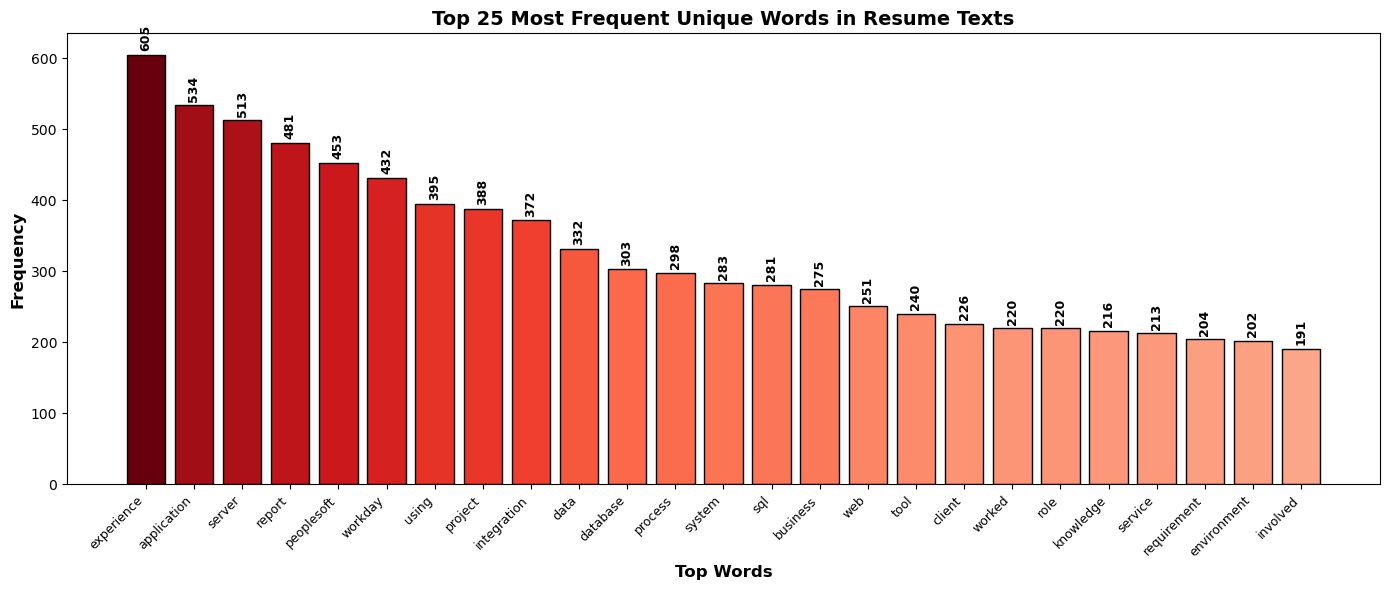

In [26]:
from collections import Counter
import re
import matplotlib.pyplot as plt

# Combine all text from resumes
all_text = " ".join(df["text"].fillna("")).lower()

# Tokenize words (alphabetic only, length ≥ 3)
tokens = re.findall(r"[a-zA-Z]{3,}", all_text)

# Count frequencies
word_freq = Counter(tokens)

# Get top 25 most common words
top_words = word_freq.most_common(25)
words_list, counts_list = zip(*top_words)  # unpack into two lists

# === Visualization ===
colors = plt.cm.Reds([c / max(counts_list) for c in counts_list])

plt.figure(figsize=(14,6))
bars = plt.bar(words_list, counts_list, color=colors, edgecolor="black")

# Add count labels above bars
for bar, count in zip(bars, counts_list):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 5,
        str(count),
        ha='center', va='bottom', fontsize=9, fontweight='bold', rotation=90
    )

plt.xticks(rotation=45, ha="right", fontsize=9)
plt.xlabel("Top Words", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("Top 25 Most Frequent Unique Words in Resume Texts", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

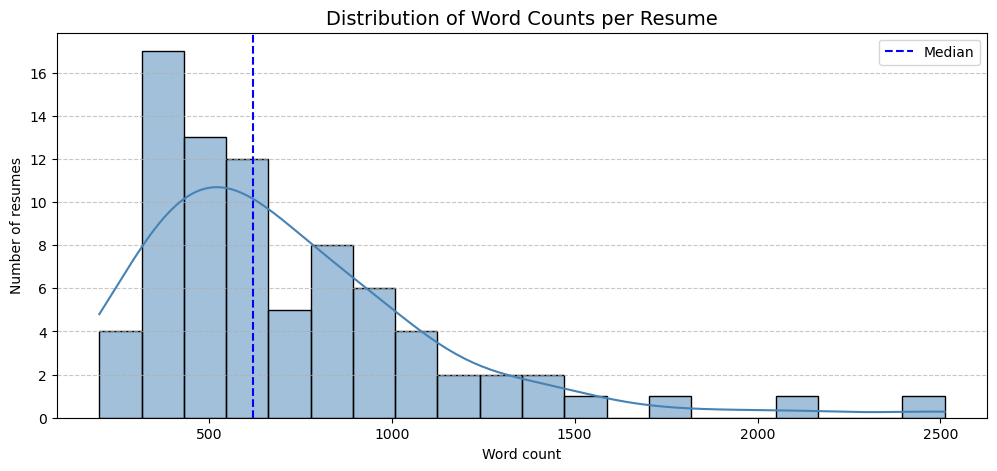

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.histplot(df["word_count"], bins=20, kde=True, color="steelblue")
plt.axvline(df["word_count"].median(), color="blue", linestyle="--", label="Median")
plt.title("Distribution of Word Counts per Resume", fontsize=14)
plt.xlabel("Word count")
plt.ylabel("Number of resumes")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

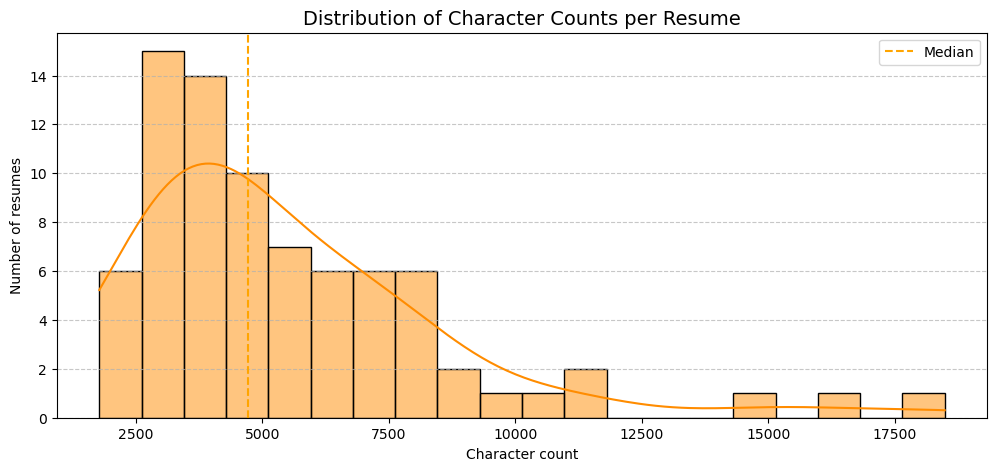

In [28]:
plt.figure(figsize=(12,5))
sns.histplot(df["char_count"], bins=20, kde=True, color="darkorange")
plt.axvline(df["char_count"].median(), color="orange", linestyle="--", label="Median")
plt.title("Distribution of Character Counts per Resume", fontsize=14)
plt.xlabel("Character count")
plt.ylabel("Number of resumes")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()

In [29]:
# === Resume Length Statistics ===
avg_length = df["word_count"].mean()
median_length = df["word_count"].median()
print(f"Average resume length: {avg_length:.1f} words")
print(f"Median resume length: {median_length} words")

Average resume length: 720.0 words
Median resume length: 620.0 words


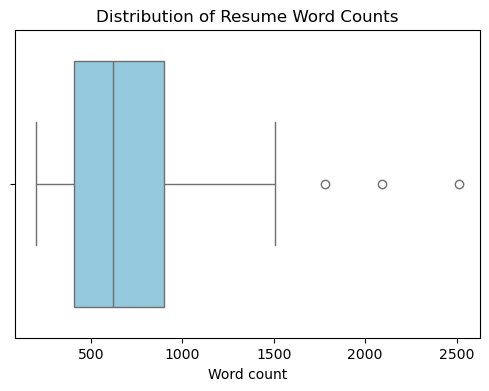

In [30]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df["word_count"], color="skyblue")
plt.title("Distribution of Resume Word Counts")
plt.xlabel("Word count")
plt.show()

In [31]:
# === Save Detailed Dataset Info ===
df.to_csv("data/resume_dataset_detailed.csv", index=False)
print("✅ Saved detailed dataset info to data/resume_dataset_detailed.csv")

✅ Saved detailed dataset info to data/resume_dataset_detailed.csv


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

print("=== Dataset Overview ===")
print("Total resumes:", len(df))
print("Avg words per resume:", round(df["word_count"].mean(), 2))
print("Median words per resume:", round(df["word_count"].median(), 2))

=== Dataset Overview ===
Total resumes: 79
Avg words per resume: 720.03
Median words per resume: 620.0


=== Empty / Short Resumes ===
Empty resumes: 0
Short resumes (<100 words): 0


Empty DataFrame
Columns: [filename, word_count]
Index: []

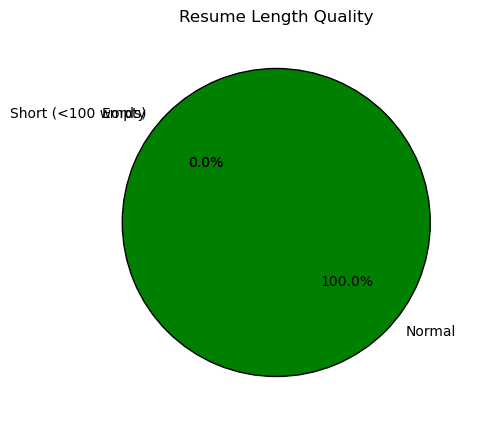

In [33]:
# Create flags if not already present
df["is_empty"] = df["word_count"] == 0
df["is_short"] = (df["word_count"] < 100) & (~df["is_empty"])

# === Empty / Short Resumes ===
print("=== Empty / Short Resumes ===")
print("Empty resumes:", df["is_empty"].sum())
print("Short resumes (<100 words):", df["is_short"].sum())

display(df[df["is_empty"] | df["is_short"]][["filename", "word_count"]])

# === Visualization: Pie chart ===
plt.figure(figsize=(5,5))
sizes = [
    df["is_empty"].sum(),
    df["is_short"].sum(),
    len(df) - (df["is_empty"].sum() + df["is_short"].sum())
]
labels = ["Empty", "Short (<100 words)", "Normal"]
colors = ["red", "orange", "green"]

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor':'black'})
plt.title("Resume Length Quality")
plt.show()

=== Longest and Shortest Resumes ===

Shortest:


filename  word_count
10   Internship_Susovan Bag_Musquare Technologies.txt         200
53                   React Developer_Naveen sadhu.txt         226
67  Reactjs Developer_Pranish Sonone_Musquare Tech...         241


Longest:


filename  word_count
26     Peoplesoft Admin_srinivasarao.txt        2512
30  PeopleSoft DBA_Vivekanand Sayana.txt        2095
28     Peoplesoft Admin_Vinod Akkala.txt        1778

C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\2964604388.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_extremes, x="word_count", y="filename", palette="coolwarm")


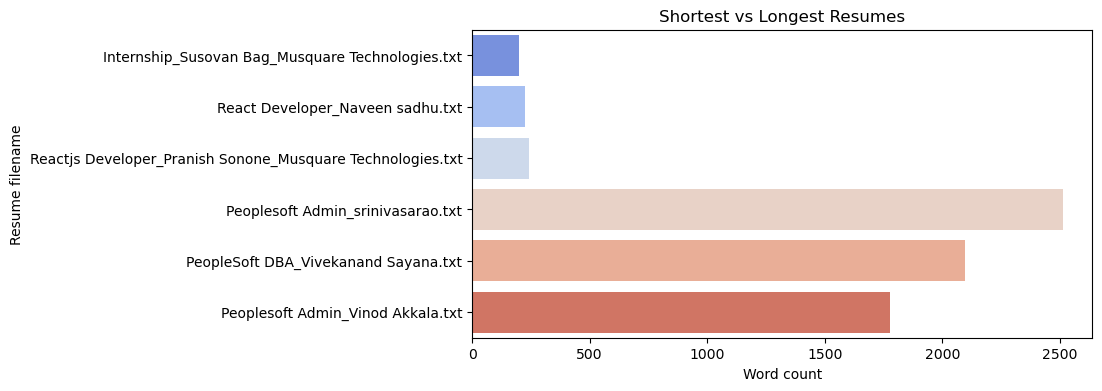

In [34]:
print("=== Longest and Shortest Resumes ===")
print("\nShortest:")
display(df.nsmallest(3, "word_count")[["filename","word_count"]])
print("\nLongest:")
display(df.nlargest(3, "word_count")[["filename","word_count"]])

# Visualization: Bar plot of top 3 shortest vs longest
top_extremes = pd.concat([
    df.nsmallest(3, "word_count"),
    df.nlargest(3, "word_count")
])
plt.figure(figsize=(8,4))
sns.barplot(data=top_extremes, x="word_count", y="filename", palette="coolwarm")
plt.title("Shortest vs Longest Resumes")
plt.xlabel("Word count")
plt.ylabel("Resume filename")
plt.show()

In [35]:
import re

# Function to compute vocabulary richness
def calc_vocab_richness(text):
    tokens = re.findall(r"[a-zA-Z]{3,}", text.lower())  # words with >=3 letters
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)

# Add vocab richness column
df["vocab_richness"] = df["text"].apply(calc_vocab_richness)

print("✅ Added vocab_richness column")
print(df[["filename","word_count","vocab_richness"]].head())

✅ Added vocab_richness column
                          filename  word_count  vocab_richness
0                   Anil kumar.txt         626        0.522917
1        AradhanaTripathi[4_0].txt         714        0.539806
2                 Buddha Vamsi.txt         360        0.720779
3  ChinnaSubbarayuduM_Hexaware.txt         863        0.466989
4        Gopi Krishna_Hexaware.txt         602        0.516269


=== Top 5 Resumes with Richest Vocabulary ===


filename  vocab_richness  \
10  Internship_Susovan Bag_Musquare Technologies.txt        0.815068   
70          Resume_Subha Santosh_Peoplesoft FSCM.txt        0.796703   
53                  React Developer_Naveen sadhu.txt        0.784810   
51                     React Developer_Haripriya.txt        0.773504   
52               React Developer_Kamalakar Reddy.txt        0.740586   

    word_count  
10         200  
70         393  
53         226  
51         406  
52         358

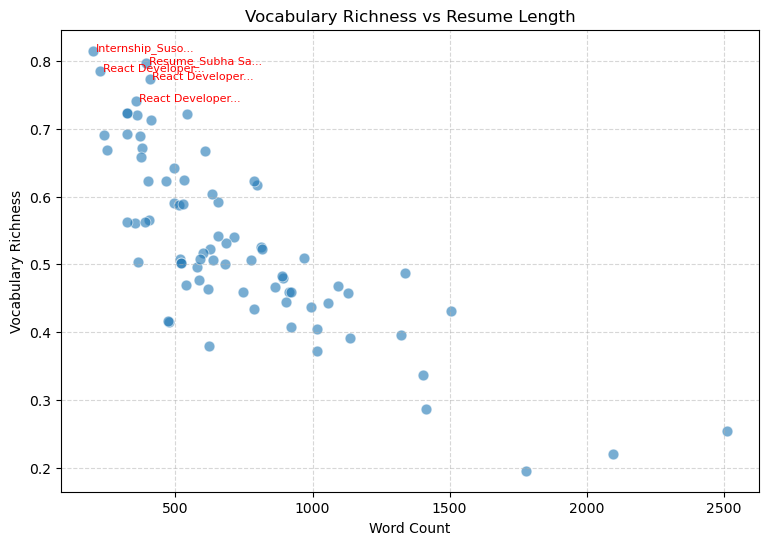

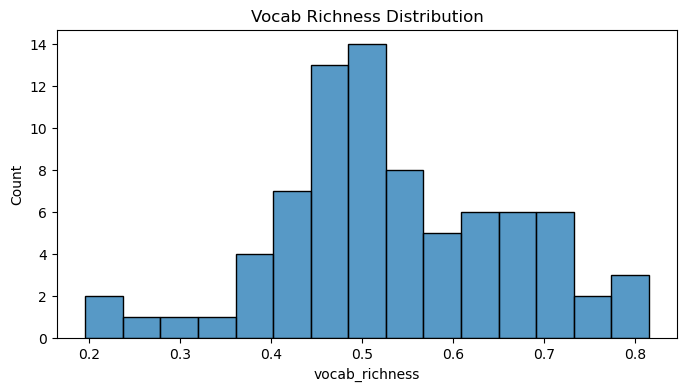

In [36]:
print("=== Top 5 Resumes with Richest Vocabulary ===")
top5_vocab = df.nlargest(5, "vocab_richness")[["filename","vocab_richness","word_count"]]
display(top5_vocab)

# === Visualization: Scatter plot word_count vs richness ===
plt.figure(figsize=(9,6))
sns.scatterplot(data=df, x="word_count", y="vocab_richness", alpha=0.6, s=60)

# Highlight top 5 resumes
for _, row in top5_vocab.iterrows():
    plt.text(row["word_count"]+10, row["vocab_richness"], row["filename"][:15]+"...", 
             fontsize=8, color="red")

plt.title("Vocabulary Richness vs Resume Length")
plt.xlabel("Word Count")
plt.ylabel("Vocabulary Richness")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df["vocab_richness"], bins=15)
plt.title("Vocab Richness Distribution")
plt.show()

In [37]:
df

filename    class  char_count  word_count  \
0                    Anil kumar.txt      sql        4433         626   
1         AradhanaTripathi[4_0].txt      sql        5161         714   
2                  Buddha Vamsi.txt      sql        3070         360   
3   ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4         Gopi Krishna_Hexaware.txt  workday        4705         602   
..                              ...      ...         ...         ...   
74             SSKumar_Hexaware.txt  workday        8329        1136   
75        Tatikonda Kiran Kumar.txt      sql        3785         527   
76     Venkateswarlu B_Hexaware.txt  workday        6933         890   
77         Vinay Kumar_Hexaware.txt  workday        5126         681   
78                      Vinod B.txt      sql        4176         588   

    line_count  is_empty  is_short  vocab_richness  has_education  \
0          108     False     False        0.522917           True   
1          146     False     False        0.539806           True   
2          200     False     False        0.720779           True   
3          218     False     False        0.466989           True   
4          140     False     False        0.516269           True   
..         ...       ...       ...             ...            ...   
74         364     False     False        0.390588           True   
75         150     False     False        0.588398           True   
76         200     False     False        0.482707           True   
77         141     False     False        0.500000           True   
78         122     False     False        0.507317           True   

    has_experience                                       skills_list  \
0             True                                             [sql]   
1             True        [python, sql, aws, hadoop, tableau, mysql]   
2            False  [java, sql, plsql, c, html, css, hadoop, oracle]   
3             True                                     [sql, oracle]   
4            False                                                []   
..             ...                                               ...   
74            True                                          [sql, c]   
75           False                                          [sql, c]   
76            True                                                []   
77           False                                                []   
78           False                                             [sql]   

    num_skills                                               text  
0            1  anil kumar maddukuri sql msbi developer summar...  
1            6  aradhana tripathi current location gachibowli ...  
2            8  buddha vamsi career objective year experience ...  
3            2  chinna subbarayudu dob march nationality india...  
4            0  name gopi krishna reddy professional summery w...  
..         ...                                                ...  
74           2  workday hcm fcm name kumar role workday consul...  
75           2  tatikonda kiran kumar career objective rewardi...  
76           0  venkateswarlu workday consultant professional ...  
77           0  vinay kumar workday functional consultant expe...  
78           1  sql msbi developer sql msbi developer vinod ku...  

[79 rows x 13 columns]

=== Education & Experience Mentions ===
Resumes mentioning education: 74
Resumes explicitly stating 'years of experience': 39


C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\1890721823.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Education Mention","Experience Mention"],


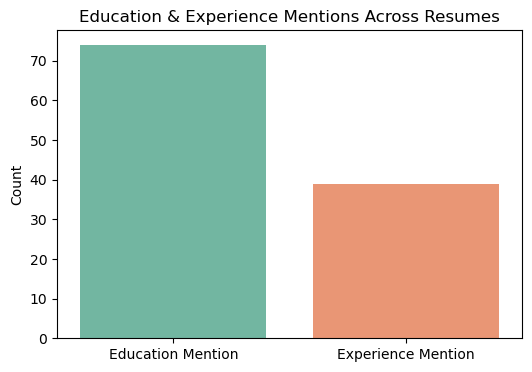

In [38]:
print("=== Education & Experience Mentions ===")
print("Resumes mentioning education:", df["has_education"].sum())
print("Resumes explicitly stating 'years of experience':", df["has_experience"].sum())

# Visualization: Count plot
plt.figure(figsize=(6,4))
sns.barplot(x=["Education Mention","Experience Mention"],
            y=[df["has_education"].sum(), df["has_experience"].sum()],
            palette="Set2")
plt.title("Education & Experience Mentions Across Resumes")
plt.ylabel("Count")
plt.show()

In [39]:
df

filename    class  char_count  word_count  \
0                    Anil kumar.txt      sql        4433         626   
1         AradhanaTripathi[4_0].txt      sql        5161         714   
2                  Buddha Vamsi.txt      sql        3070         360   
3   ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4         Gopi Krishna_Hexaware.txt  workday        4705         602   
..                              ...      ...         ...         ...   
74             SSKumar_Hexaware.txt  workday        8329        1136   
75        Tatikonda Kiran Kumar.txt      sql        3785         527   
76     Venkateswarlu B_Hexaware.txt  workday        6933         890   
77         Vinay Kumar_Hexaware.txt  workday        5126         681   
78                      Vinod B.txt      sql        4176         588   

    line_count  is_empty  is_short  vocab_richness  has_education  \
0          108     False     False        0.522917           True   
1          146     False     False        0.539806           True   
2          200     False     False        0.720779           True   
3          218     False     False        0.466989           True   
4          140     False     False        0.516269           True   
..         ...       ...       ...             ...            ...   
74         364     False     False        0.390588           True   
75         150     False     False        0.588398           True   
76         200     False     False        0.482707           True   
77         141     False     False        0.500000           True   
78         122     False     False        0.507317           True   

    has_experience                                       skills_list  \
0             True                                             [sql]   
1             True        [python, sql, aws, hadoop, tableau, mysql]   
2            False  [java, sql, plsql, c, html, css, hadoop, oracle]   
3             True                                     [sql, oracle]   
4            False                                                []   
..             ...                                               ...   
74            True                                          [sql, c]   
75           False                                          [sql, c]   
76            True                                                []   
77           False                                                []   
78           False                                             [sql]   

    num_skills                                               text  
0            1  anil kumar maddukuri sql msbi developer summar...  
1            6  aradhana tripathi current location gachibowli ...  
2            8  buddha vamsi career objective year experience ...  
3            2  chinna subbarayudu dob march nationality india...  
4            0  name gopi krishna reddy professional summery w...  
..         ...                                                ...  
74           2  workday hcm fcm name kumar role workday consul...  
75           2  tatikonda kiran kumar career objective rewardi...  
76           0  venkateswarlu workday consultant professional ...  
77           0  vinay kumar workday functional consultant expe...  
78           1  sql msbi developer sql msbi developer vinod ku...  

[79 rows x 13 columns]

In [40]:
# Define a basic skill list (can be expanded later)
skill_list = [
    "sql","python","java","c","c++","html","css","javascript","react","node",
    "aws","azure","docker","kubernetes","hadoop","spark","tableau","powerbi",
    "plsql","oracle","mysql","postgresql"
]

# Detect skills per resume
df["detected_skills"] = df["text"].apply(
    lambda txt: [s for s in skill_list if re.search(r"\b"+re.escape(s)+r"\b", txt, flags=re.I)]
)

# Count skills per resume
df["num_skills"] = df["detected_skills"].apply(len)

# Flatten all skills into a big list
all_skills = Counter([s.lower() for skills in df["detected_skills"] for s in skills])

print("✅ Skill detection completed")
print(df[["filename","num_skills","detected_skills"]].head())

✅ Skill detection completed
                          filename  num_skills  \
0                   Anil kumar.txt           1   
1        AradhanaTripathi[4_0].txt           6   
2                 Buddha Vamsi.txt           6   
3  ChinnaSubbarayuduM_Hexaware.txt           2   
4        Gopi Krishna_Hexaware.txt           0   

                              detected_skills  
0                                       [sql]  
1  [sql, python, aws, hadoop, tableau, mysql]  
2    [sql, java, html, hadoop, plsql, oracle]  
3                               [sql, oracle]  
4                                          []  


=== Top 15 Detected Skills ===


skill  count
0          sql     37
1         html     24
2       oracle     24
3   javascript     21
4        react     21
5         java     15
6         node     15
7        mysql      9
8          aws      8
9       python      3
10      hadoop      2
11       plsql      2
12       azure      2
13     tableau      1
14      docker      1


Average skills per resume: 2.34


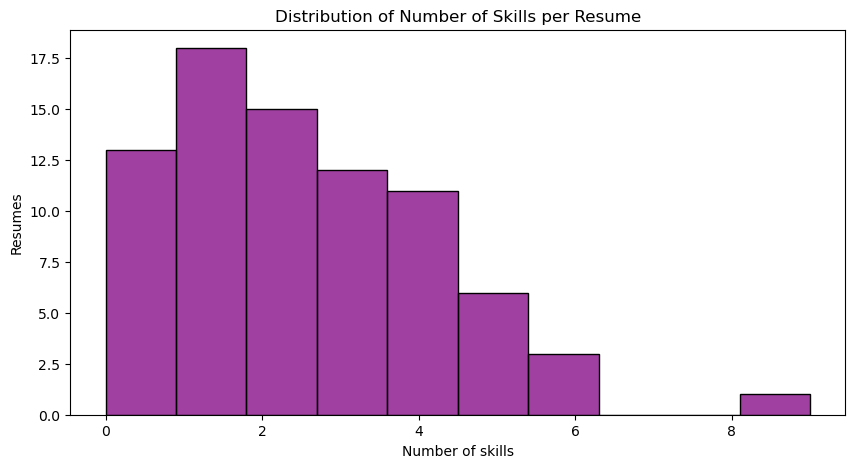

C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\3317468731.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_skills, x="count", y="skill", palette="magma")


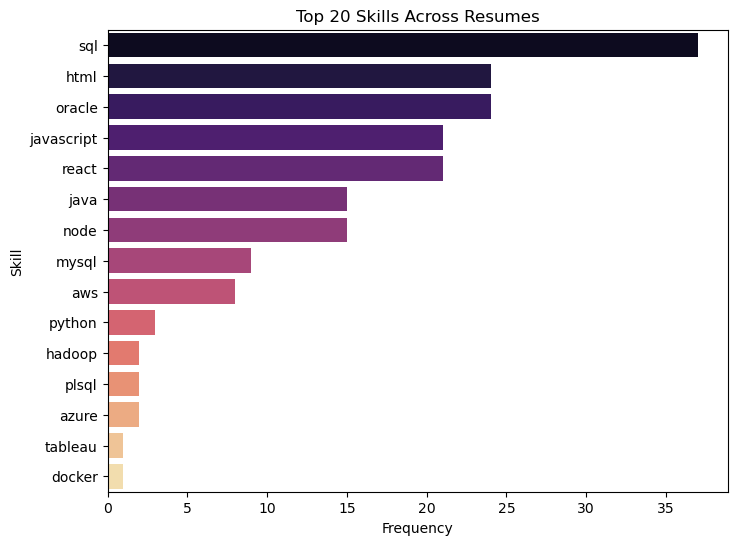

In [41]:
print("=== Top 15 Detected Skills ===")
top_skills = pd.DataFrame(all_skills.most_common(20), columns=["skill","count"])
display(top_skills)

print("\nAverage skills per resume:", round(df["num_skills"].mean(), 2))

# Visualization 1: Histogram of skills per resume
plt.figure(figsize=(10,5))
sns.histplot(df["num_skills"], bins=10, color="purple")
plt.title("Distribution of Number of Skills per Resume")
plt.xlabel("Number of skills")
plt.ylabel("Resumes")
plt.show()

# Visualization 2: Bar chart of top 15 skills
plt.figure(figsize=(8,6))
sns.barplot(data=top_skills, x="count", y="skill", palette="magma")
plt.title("Top 20 Skills Across Resumes")
plt.xlabel("Frequency")
plt.ylabel("Skill")
plt.show()

In [42]:
# Cell: eda_ngrams.py
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(2,3), stop_words="english", max_features=40)
Xng = cv.fit_transform(df["text"])
ng_df = pd.DataFrame({"phrase": cv.get_feature_names_out(), "count": Xng.toarray().sum(axis=0)}).sort_values("count", ascending=False)
ng_df.head(20)

phrase  count
2         application server    124
31                sql server    118
19         process scheduler    109
35                web server     94
3           business process     86
18               people tool     82
8              custom report     80
7             core connector     77
5           calculated field     75
26             server domain     75
38            workday studio     72
37               workday hcm     69
14                   html cs     68
34                 till date     67
39           year experience     61
36               web service     59
25          scheduler server     56
20  process scheduler server     56
23             report writer     53
12            good knowledge     53

In [43]:
# Drop the column 'detected_skills'
df = df.drop(columns=["detected_skills"])

print("✅ 'detected_skills' column dropped")
print(df.head())

✅ 'detected_skills' column dropped
                          filename    class  char_count  word_count  \
0                   Anil kumar.txt      sql        4433         626   
1        AradhanaTripathi[4_0].txt      sql        5161         714   
2                 Buddha Vamsi.txt      sql        3070         360   
3  ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4        Gopi Krishna_Hexaware.txt  workday        4705         602   

   line_count  is_empty  is_short  vocab_richness  has_education  \
0         108     False     False        0.522917           True   
1         146     False     False        0.539806           True   
2         200     False     False        0.720779           True   
3         218     False     False        0.466989           True   
4         140     False     False        0.516269           True   

   has_experience                                       skills_list  \
0            True                                         

In [44]:
df

filename    class  char_count  word_count  \
0                    Anil kumar.txt      sql        4433         626   
1         AradhanaTripathi[4_0].txt      sql        5161         714   
2                  Buddha Vamsi.txt      sql        3070         360   
3   ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4         Gopi Krishna_Hexaware.txt  workday        4705         602   
..                              ...      ...         ...         ...   
74             SSKumar_Hexaware.txt  workday        8329        1136   
75        Tatikonda Kiran Kumar.txt      sql        3785         527   
76     Venkateswarlu B_Hexaware.txt  workday        6933         890   
77         Vinay Kumar_Hexaware.txt  workday        5126         681   
78                      Vinod B.txt      sql        4176         588   

    line_count  is_empty  is_short  vocab_richness  has_education  \
0          108     False     False        0.522917           True   
1          146     False     False        0.539806           True   
2          200     False     False        0.720779           True   
3          218     False     False        0.466989           True   
4          140     False     False        0.516269           True   
..         ...       ...       ...             ...            ...   
74         364     False     False        0.390588           True   
75         150     False     False        0.588398           True   
76         200     False     False        0.482707           True   
77         141     False     False        0.500000           True   
78         122     False     False        0.507317           True   

    has_experience                                       skills_list  \
0             True                                             [sql]   
1             True        [python, sql, aws, hadoop, tableau, mysql]   
2            False  [java, sql, plsql, c, html, css, hadoop, oracle]   
3             True                                     [sql, oracle]   
4            False                                                []   
..             ...                                               ...   
74            True                                          [sql, c]   
75           False                                          [sql, c]   
76            True                                                []   
77           False                                                []   
78           False                                             [sql]   

    num_skills                                               text  
0            1  anil kumar maddukuri sql msbi developer summar...  
1            6  aradhana tripathi current location gachibowli ...  
2            6  buddha vamsi career objective year experience ...  
3            2  chinna subbarayudu dob march nationality india...  
4            0  name gopi krishna reddy professional summery w...  
..         ...                                                ...  
74           1  workday hcm fcm name kumar role workday consul...  
75           1  tatikonda kiran kumar career objective rewardi...  
76           0  venkateswarlu workday consultant professional ...  
77           0  vinay kumar workday functional consultant expe...  
78           1  sql msbi developer sql msbi developer vinod ku...  

[79 rows x 13 columns]

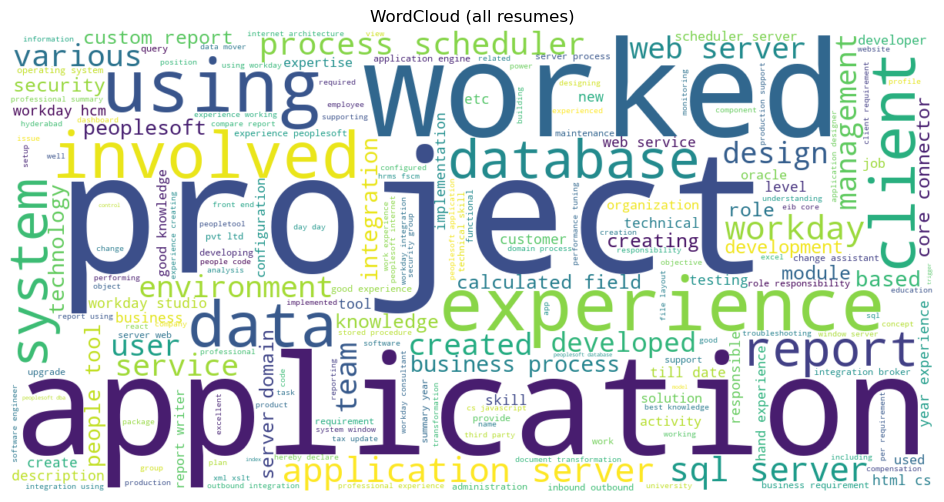

In [45]:
# Cell: eda_wordcloud.py
from wordcloud import WordCloud
text_all = " ".join(df["text"]).lower()
wc = WordCloud(width=1200, height=600, background_color="white", max_words=200).generate(text_all)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud (all resumes)")
plt.show()

In [46]:
# Create helper flags
df["is_empty"] = df["word_count"] == 0
df["is_short"] = df["word_count"] < 100

print("=== Dataset Overview ===")
print(f"Total resumes: {len(df)}")
print(f"Average words per resume: {df['word_count'].mean():.1f}")
print(f"Median words per resume: {df['word_count'].median():.1f}")
print(f"Min words: {df['word_count'].min()} | Max words: {df['word_count'].max()}")
print(f"Empty resumes: {df['is_empty'].sum()}")
print(f"Short resumes (<100 words): {df['is_short'].sum()}")

=== Dataset Overview ===
Total resumes: 79
Average words per resume: 720.0
Median words per resume: 620.0
Min words: 200 | Max words: 2512
Empty resumes: 0
Short resumes (<100 words): 0


C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\4259420484.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=X.toarray().sum(axis=0), y=keywords, palette="viridis")


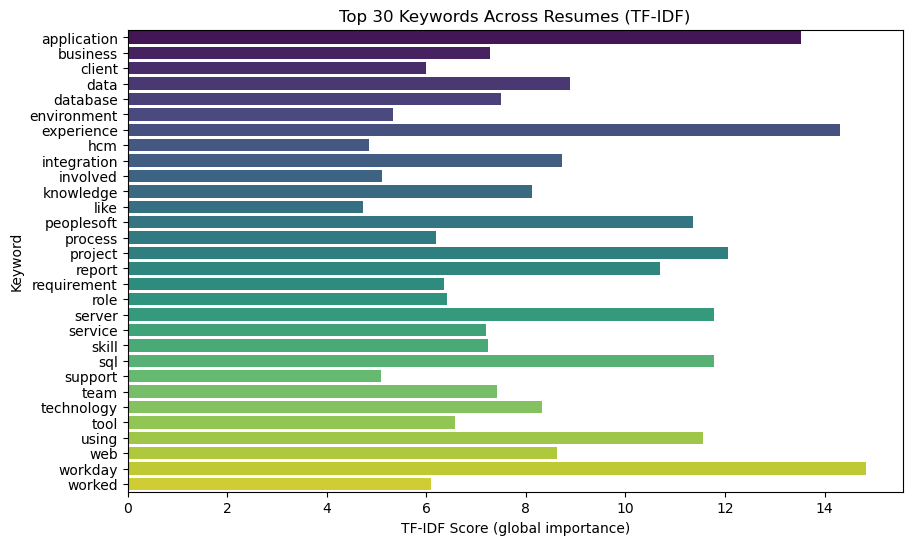

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=30, stop_words="english")
X = tfidf.fit_transform(df["text"])
keywords = tfidf.get_feature_names_out()

plt.figure(figsize=(10,6))
sns.barplot(x=X.toarray().sum(axis=0), y=keywords, palette="viridis")
plt.title("Top 30 Keywords Across Resumes (TF-IDF)")
plt.xlabel("TF-IDF Score (global importance)")
plt.ylabel("Keyword")
plt.show()

C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\2160709008.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ngram_df, x="count", y="phrase", palette="cividis")


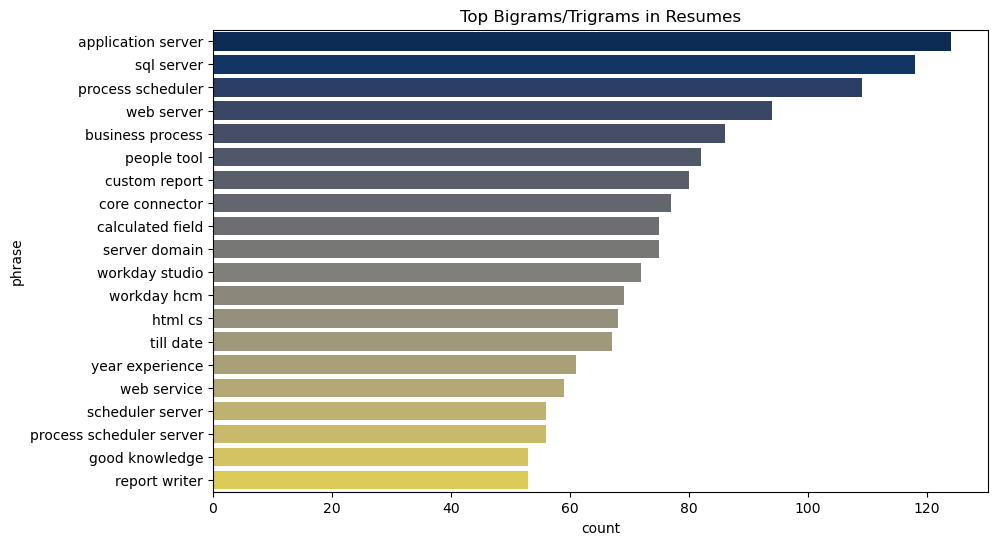

In [48]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2,3), stop_words="english", max_features=20)
X_ngrams = cv.fit_transform(df["text"])
phrases = cv.get_feature_names_out()
counts = X_ngrams.toarray().sum(axis=0)

ngram_df = pd.DataFrame({"phrase": phrases, "count": counts}).sort_values("count", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=ngram_df, x="count", y="phrase", palette="cividis")
plt.title("Top Bigrams/Trigrams in Resumes")
plt.show()

In [49]:
import re
from collections import Counter

# Add missing features if they don't exist
if "line_count" not in df.columns:
    df["line_count"] = df["text"].str.count("\n")

if "vocab_richness" not in df.columns:
    # richness = unique words / total words
    def richness(text):
        tokens = re.findall(r"\b[a-zA-Z]{3,}\b", str(text).lower())
        if len(tokens) == 0:
            return 0
        return len(set(tokens)) / len(tokens)
    df["vocab_richness"] = df["text"].apply(richness)

if "num_skills" not in df.columns:
    skills = ["sql","python","java","c","c++","html","css","javascript",
              "react","node","aws","azure","docker","tableau","hadoop","plsql"]
    def skill_count(text):
        txt = str(text).lower()
        return sum(1 for s in skills if s in txt)
    df["num_skills"] = df["text"].apply(skill_count)

print("✅ Added missing columns:", [c for c in ["line_count","num_skills","vocab_richness"] if c in df.columns])

✅ Added missing columns: ['line_count', 'num_skills', 'vocab_richness']


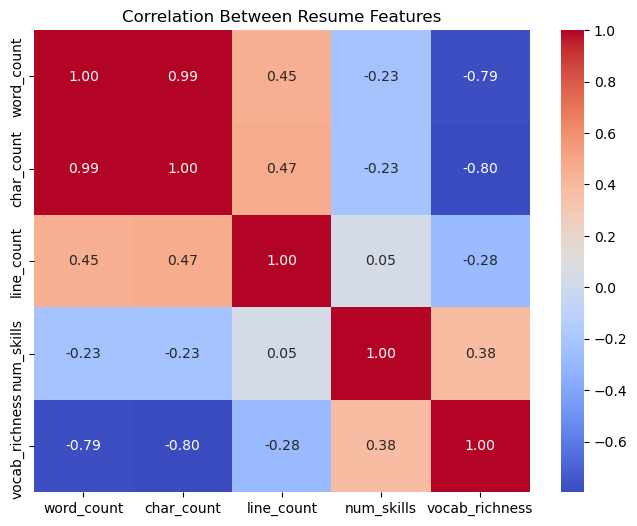

In [50]:
plt.figure(figsize=(8,6))
sns.heatmap(df[["word_count","char_count","line_count","num_skills","vocab_richness"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Resume Features")
plt.show()

In [51]:
df

filename    class  char_count  word_count  \
0                    Anil kumar.txt      sql        4433         626   
1         AradhanaTripathi[4_0].txt      sql        5161         714   
2                  Buddha Vamsi.txt      sql        3070         360   
3   ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4         Gopi Krishna_Hexaware.txt  workday        4705         602   
..                              ...      ...         ...         ...   
74             SSKumar_Hexaware.txt  workday        8329        1136   
75        Tatikonda Kiran Kumar.txt      sql        3785         527   
76     Venkateswarlu B_Hexaware.txt  workday        6933         890   
77         Vinay Kumar_Hexaware.txt  workday        5126         681   
78                      Vinod B.txt      sql        4176         588   

    line_count  is_empty  is_short  vocab_richness  has_education  \
0          108     False     False        0.522917           True   
1          146     False     False        0.539806           True   
2          200     False     False        0.720779           True   
3          218     False     False        0.466989           True   
4          140     False     False        0.516269           True   
..         ...       ...       ...             ...            ...   
74         364     False     False        0.390588           True   
75         150     False     False        0.588398           True   
76         200     False     False        0.482707           True   
77         141     False     False        0.500000           True   
78         122     False     False        0.507317           True   

    has_experience                                       skills_list  \
0             True                                             [sql]   
1             True        [python, sql, aws, hadoop, tableau, mysql]   
2            False  [java, sql, plsql, c, html, css, hadoop, oracle]   
3             True                                     [sql, oracle]   
4            False                                                []   
..             ...                                               ...   
74            True                                          [sql, c]   
75           False                                          [sql, c]   
76            True                                                []   
77           False                                                []   
78           False                                             [sql]   

    num_skills                                               text  
0            1  anil kumar maddukuri sql msbi developer summar...  
1            6  aradhana tripathi current location gachibowli ...  
2            6  buddha vamsi career objective year experience ...  
3            2  chinna subbarayudu dob march nationality india...  
4            0  name gopi krishna reddy professional summery w...  
..         ...                                                ...  
74           1  workday hcm fcm name kumar role workday consul...  
75           1  tatikonda kiran kumar career objective rewardi...  
76           0  venkateswarlu workday consultant professional ...  
77           0  vinay kumar workday functional consultant expe...  
78           1  sql msbi developer sql msbi developer vinod ku...  

[79 rows x 13 columns]

In [52]:
!pip install squarify

In [53]:
# =============================
# Imports
# =============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import squarify

# =============================
# Class Summary
# =============================
summary_df = pd.DataFrame({
    "Count": df["class"].value_counts(),
    "Percentage": round(df["class"].value_counts(normalize=True) * 100, 2)
})
print("=== CLASS SUMMARY ===")
display(summary_df)   # If in Jupyter, nicer display
print("\nUnique categories:", df["class"].unique().tolist())

=== CLASS SUMMARY ===


Count  Percentage
class                        
workday        22       27.85
react js       22       27.85
peoplesoft     20       25.32
sql            13       16.46
internship      2        2.53


Unique categories: ['sql', 'workday', 'internship', 'peoplesoft', 'react js']


C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\2157506629.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=summary_df.index, x=summary_df["Count"], palette="viridis")


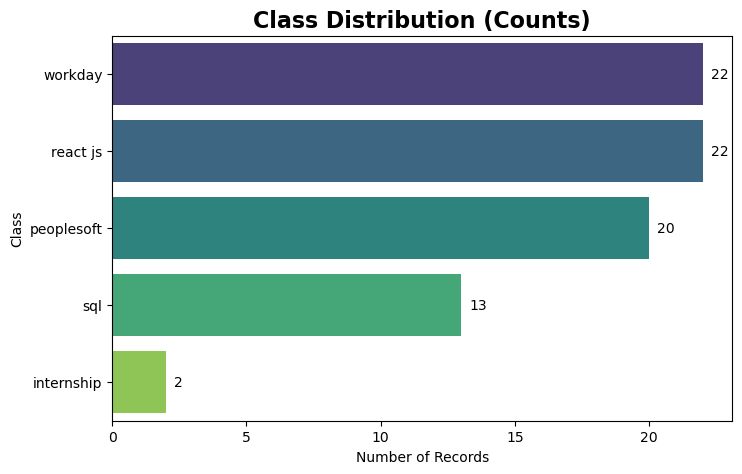

In [54]:
# =============================
# Horizontal Bar Plot
# =============================
plt.figure(figsize=(8,5))
sns.barplot(y=summary_df.index, x=summary_df["Count"], palette="viridis")
plt.title("Class Distribution (Counts)", fontsize=16, weight="bold")
plt.xlabel("Number of Records")
plt.ylabel("Class")
for i, v in enumerate(summary_df["Count"]):
    plt.text(v + 0.3, i, str(v), va="center", fontsize=10)
plt.show()

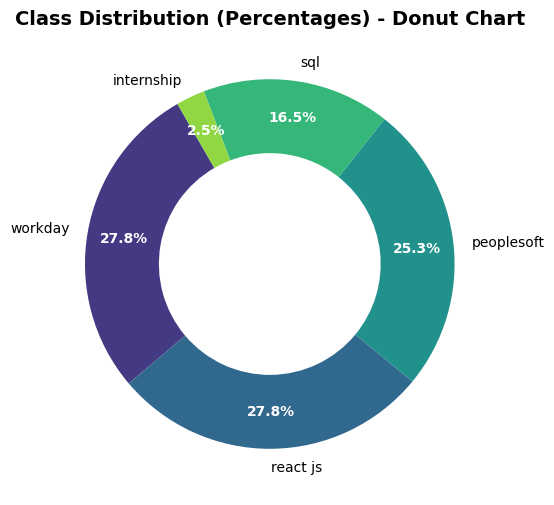

In [55]:
# =============================
# Donut Chart
# =============================
plt.figure(figsize=(6,6))
colors = sns.color_palette("viridis", len(summary_df))
wedges, texts, autotexts = plt.pie(
    summary_df["Count"], labels=summary_df.index, autopct="%.1f%%", startangle=120,
    wedgeprops=dict(width=0.4), pctdistance=0.8, colors=colors
)
plt.setp(autotexts, size=10, weight="bold", color="white")
plt.title("Class Distribution (Percentages) - Donut Chart", fontsize=14, weight="bold")
plt.show()

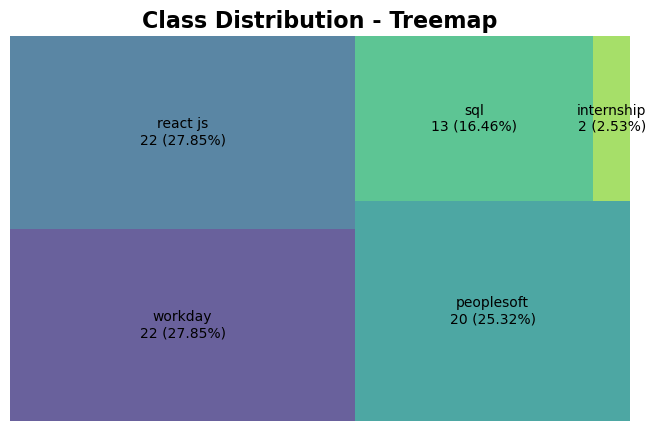

In [56]:
# =============================
# Treemap
# =============================
plt.figure(figsize=(8,5))
squarify.plot(
    sizes=summary_df["Count"], 
    label=[f"{i}\n{v} ({p}%)" for i,v,p in zip(summary_df.index, summary_df["Count"], summary_df["Percentage"])],
    color=sns.color_palette("viridis", len(summary_df)),
    alpha=0.8
)
plt.title("Class Distribution - Treemap", fontsize=16, weight="bold")
plt.axis("off")
plt.show()

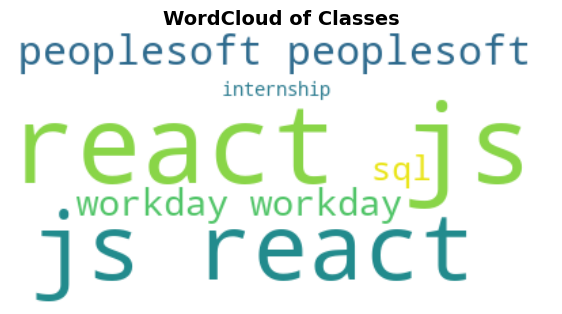

In [57]:
# =============================
# WordCloud
# =============================
text_for_wc = " ".join(df["class"])
wc = WordCloud(background_color="white", colormap="viridis").generate(text_for_wc)
plt.figure(figsize=(7,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of Classes", fontsize=14, weight="bold")
plt.show()

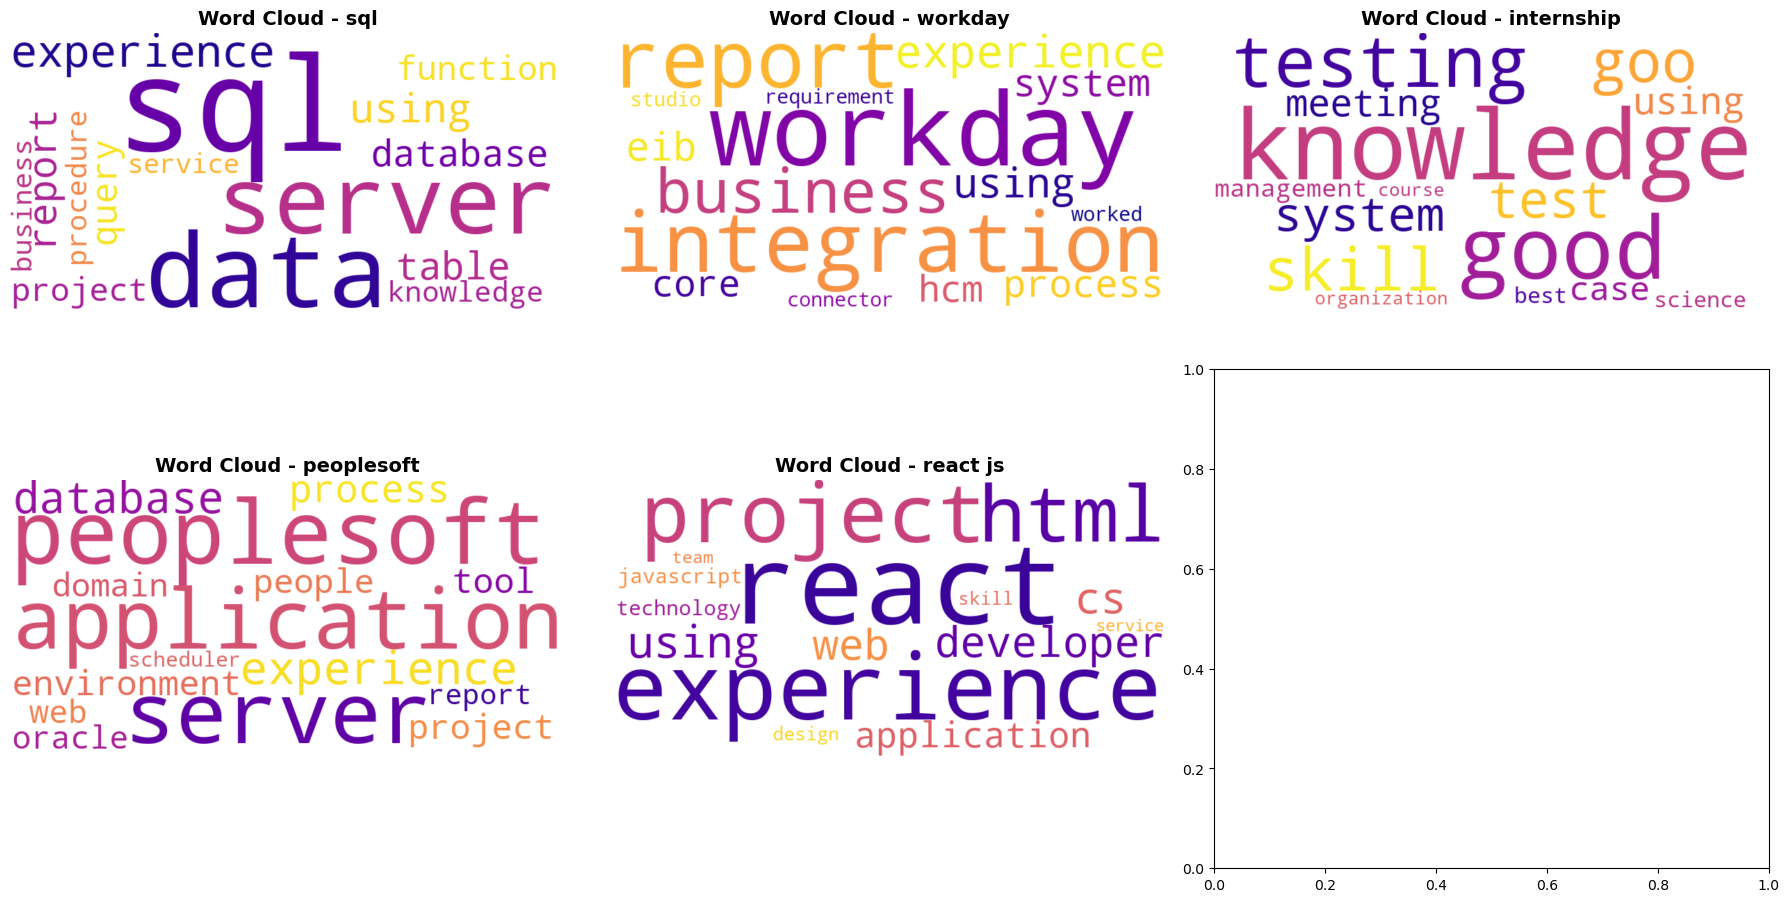

In [58]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# --- STEP 1: Get top words per category ---
def get_top_n_words(texts, n=15):
    words = " ".join(texts).split()
    counter = Counter(words)
    return counter.most_common(n)

top_words = {}
for category in df['class'].unique():
    texts = df[df['class'] == category]['text']
    top_words[category] = get_top_n_words(texts, n=15)

# --- STEP 2: Word Clouds per category ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, (category, words) in enumerate(top_words.items()):
    word_freq = dict(words)
    wc = WordCloud(width=800, height=400, background_color="white",
                   colormap="plasma", max_words=15).generate_from_frequencies(word_freq)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Word Cloud - {category}", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

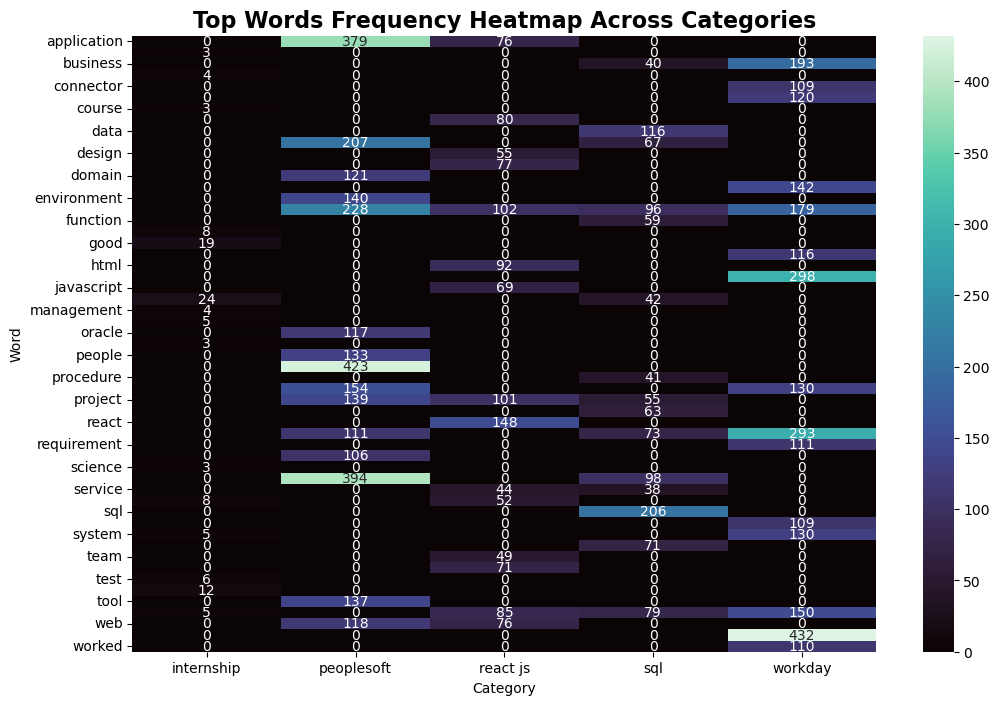

In [59]:
# --- STEP 3: Heatmap of frequencies (comparative view) ---
heatmap_data = []
for category, words in top_words.items():
    for word, freq in words:
        heatmap_data.append([category, word, freq])

heatmap_df = pd.DataFrame(heatmap_data, columns=["Category", "Word", "Frequency"])

pivot_df = heatmap_df.pivot(index="Word", columns="Category", values="Frequency").fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="mako", cbar=True)
plt.title("Top Words Frequency Heatmap Across Categories", fontsize=16, fontweight="bold")
plt.show()

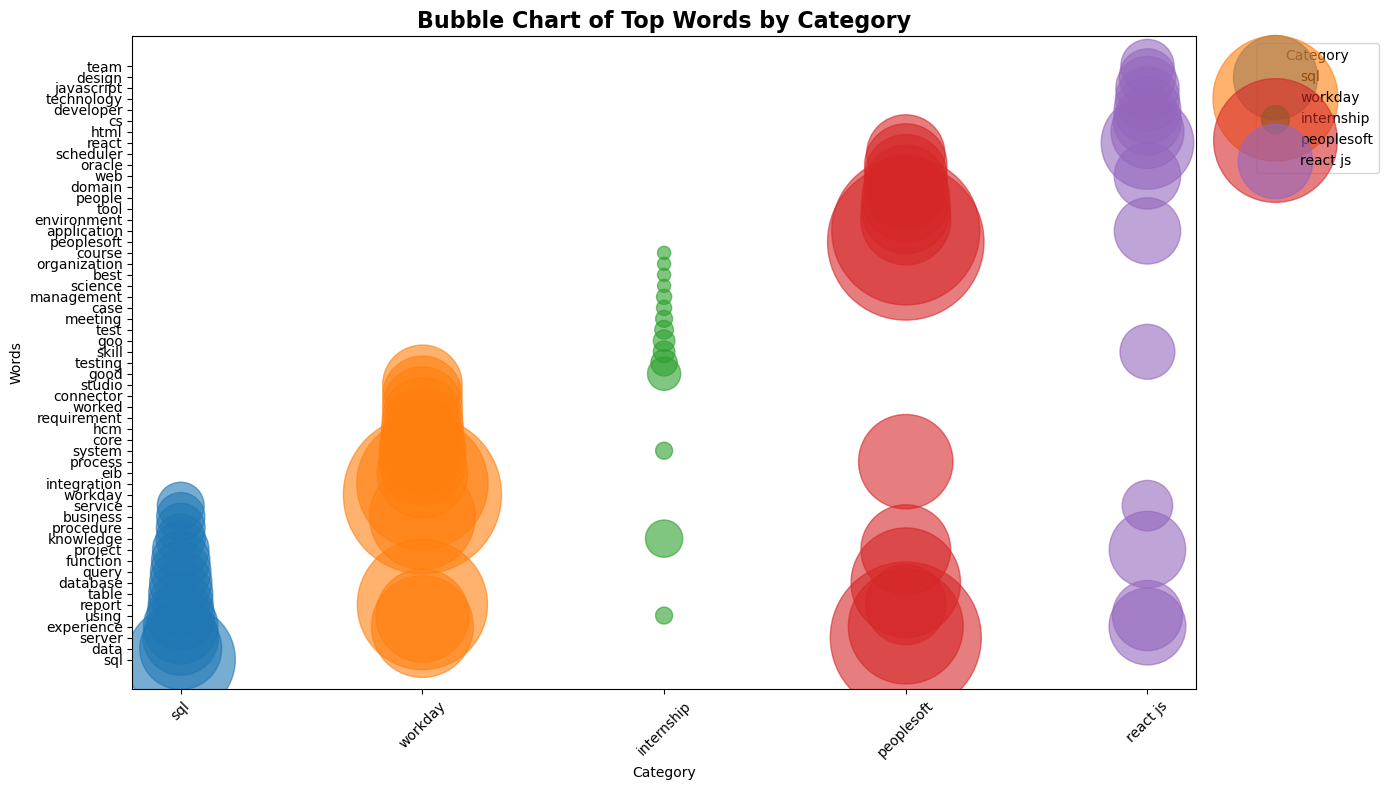

In [60]:
# --- STEP 4 (Alternative): Bubble Chart ---
plt.figure(figsize=(14, 8))

for category in heatmap_df["Category"].unique():
    subset = heatmap_df[heatmap_df["Category"] == category]
    plt.scatter(
        subset["Category"], 
        subset["Word"], 
        s=subset["Frequency"]*30,   # bubble size = frequency
        alpha=0.6, label=category
    )

plt.title("Bubble Chart of Top Words by Category", fontsize=16, fontweight="bold")
plt.xlabel("Category")
plt.ylabel("Words")
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\2339457081.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=ax, palette="viridis")
C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\2339457081.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=ax, palette="viridis")
C:\Users\yasha\AppData\Local\Temp\ipykernel_15820\2339457081.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=ax, palette="viridis")
C:\Users\yasha\AppData\Local\Temp\

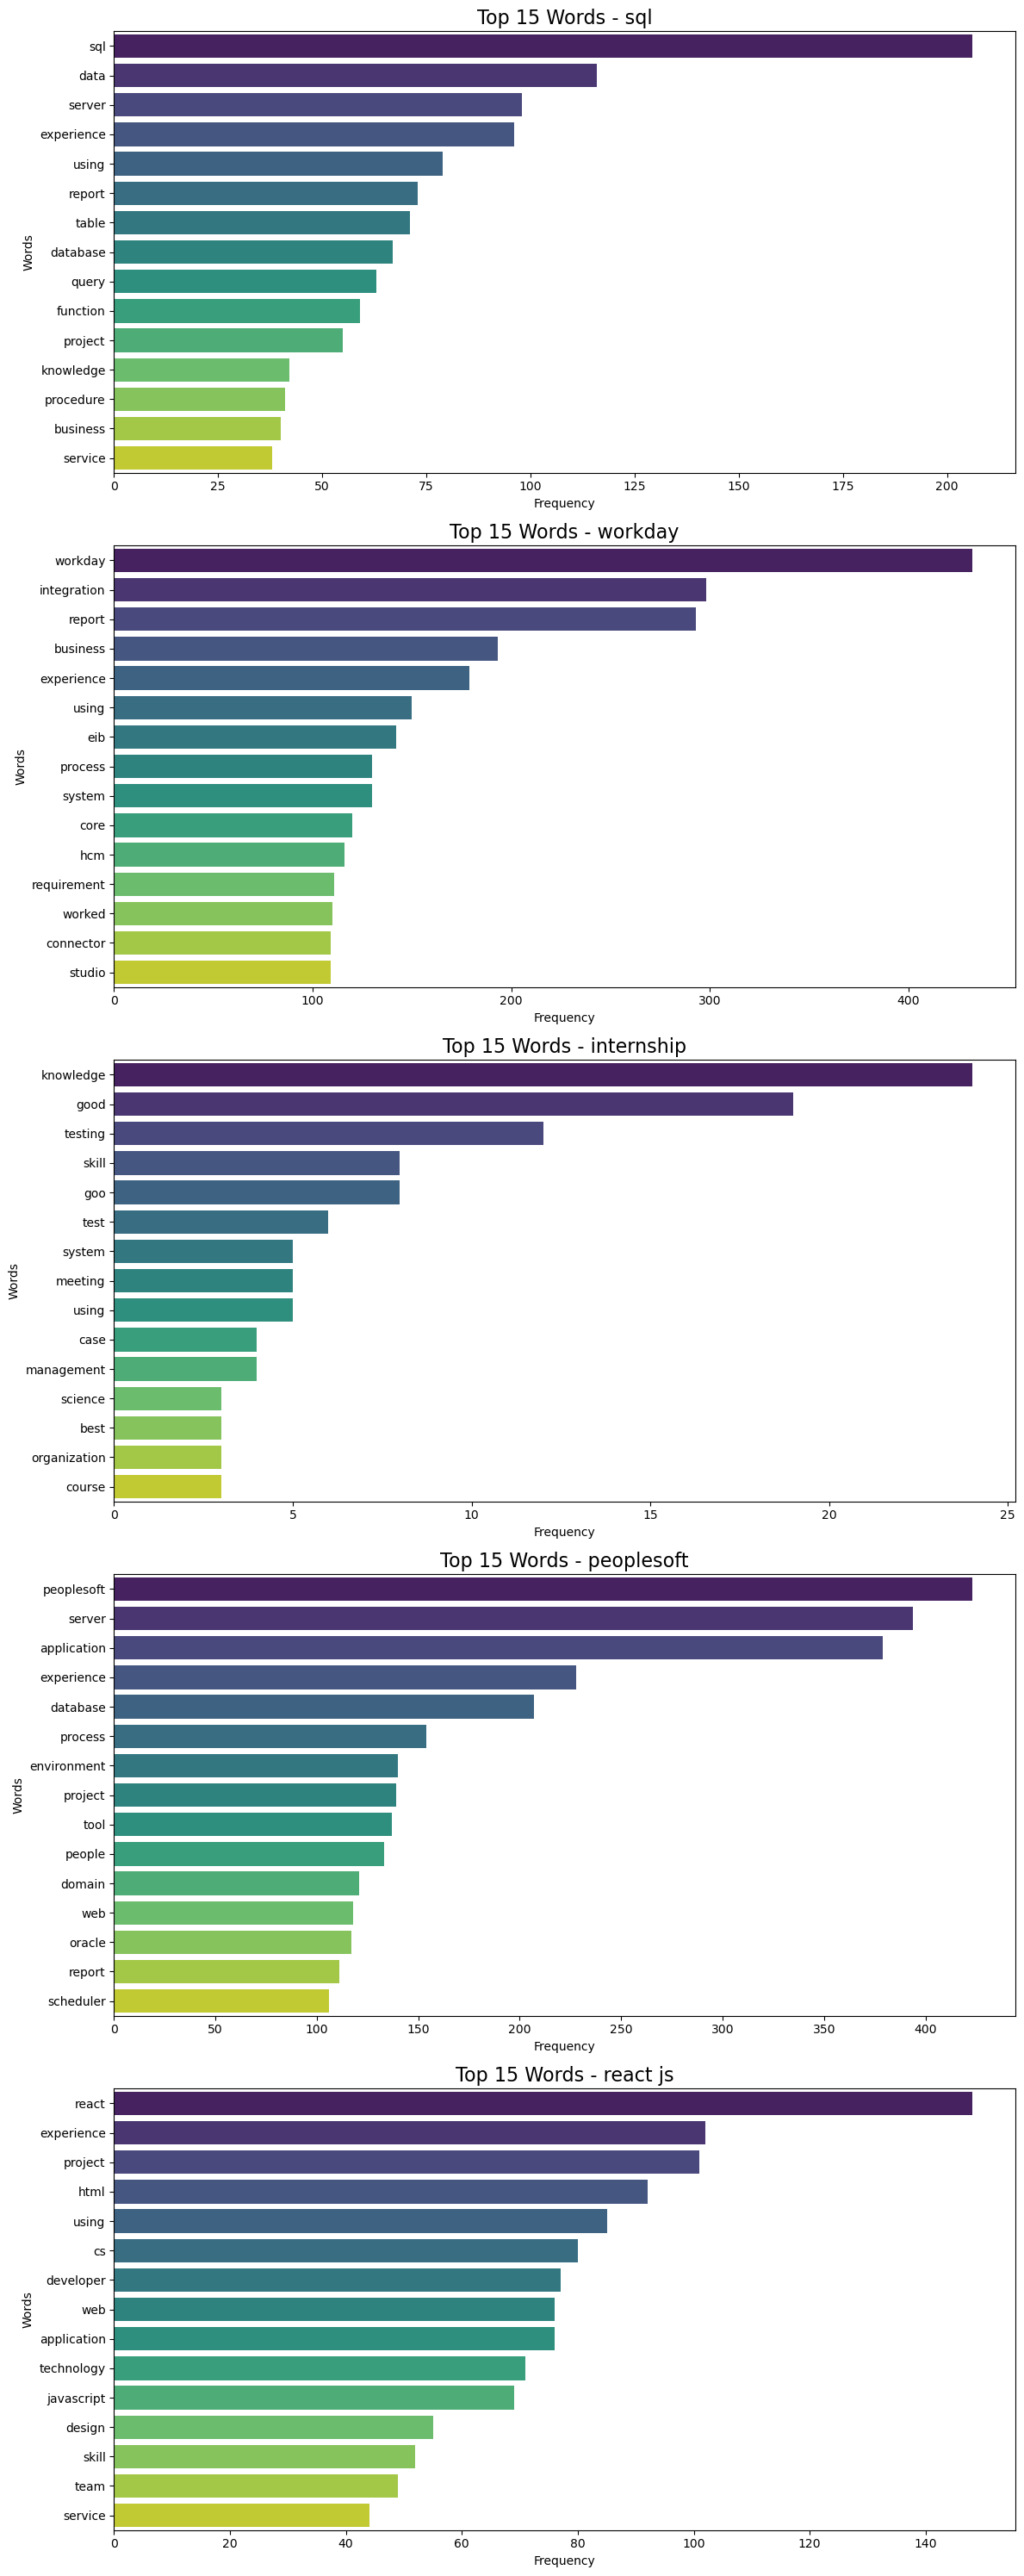

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# --- Get Top 15 Words Per Category ---
def get_top_words_by_class(df, text_col, target_col, n=15):
    class_top_words = {}
    for category in df[target_col].unique():
        words = " ".join(df[df[target_col] == category][text_col]).split()
        word_counts = Counter(words)
        class_top_words[category] = word_counts.most_common(n)
    return class_top_words

top_words = get_top_words_by_class(df, "text", "class", n=15)

# --- Plot Horizontal Bar Chart ---
fig, axes = plt.subplots(len(top_words), 1, figsize=(12, 30))
for ax, (category, words) in zip(axes, top_words.items()):
    words, counts = zip(*words)
    sns.barplot(x=list(counts), y=list(words), ax=ax, palette="viridis")
    ax.set_title(f"Top 15 Words - {category}", fontsize=16)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Words")
plt.tight_layout()
plt.show()

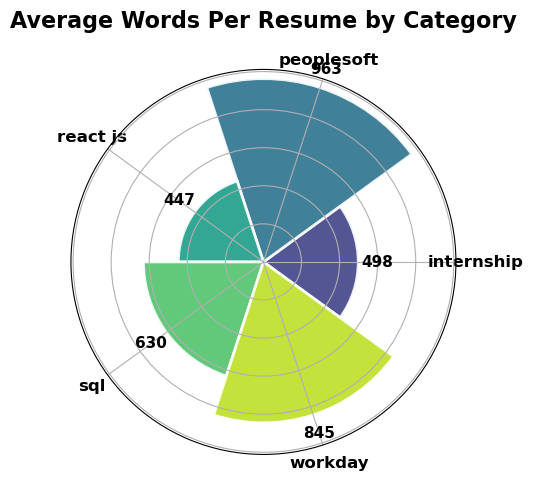

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Compute average word count per category ---
avg_words = df.groupby("class")["word_count"].mean().round(1)

# --- Radial (Coxcomb / Nightingale Rose) Chart ---
categories = avg_words.index
values = avg_words.values

# Repeat first value to close the circle
values = np.concatenate((values, [values[0]]))
angles = np.linspace(0, 2 * np.pi, len(categories) + 1)

fig, ax = plt.subplots(figsize=(5, 5), subplot_kw={'polar': True})
bars = ax.bar(
    angles[:-1], avg_words, width=2*np.pi/len(categories),
    bottom=0, edgecolor="white", linewidth=2, alpha=0.9,
    color=plt.cm.viridis(np.linspace(0.2, 0.9, len(categories)))
)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12, weight='bold')
ax.set_yticklabels([])
ax.set_title("Average Words Per Resume by Category", fontsize=16, weight="bold", pad=30)

# Annotate values
for angle, val in zip(angles[:-1], avg_words):
    ax.text(angle, val + 100, f"{int(val)}", ha="center", va="center", fontsize=11, weight="bold")

plt.show()

In [63]:
df

filename    class  char_count  word_count  \
0                    Anil kumar.txt      sql        4433         626   
1         AradhanaTripathi[4_0].txt      sql        5161         714   
2                  Buddha Vamsi.txt      sql        3070         360   
3   ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4         Gopi Krishna_Hexaware.txt  workday        4705         602   
..                              ...      ...         ...         ...   
74             SSKumar_Hexaware.txt  workday        8329        1136   
75        Tatikonda Kiran Kumar.txt      sql        3785         527   
76     Venkateswarlu B_Hexaware.txt  workday        6933         890   
77         Vinay Kumar_Hexaware.txt  workday        5126         681   
78                      Vinod B.txt      sql        4176         588   

    line_count  is_empty  is_short  vocab_richness  has_education  \
0          108     False     False        0.522917           True   
1          146     False     False        0.539806           True   
2          200     False     False        0.720779           True   
3          218     False     False        0.466989           True   
4          140     False     False        0.516269           True   
..         ...       ...       ...             ...            ...   
74         364     False     False        0.390588           True   
75         150     False     False        0.588398           True   
76         200     False     False        0.482707           True   
77         141     False     False        0.500000           True   
78         122     False     False        0.507317           True   

    has_experience                                       skills_list  \
0             True                                             [sql]   
1             True        [python, sql, aws, hadoop, tableau, mysql]   
2            False  [java, sql, plsql, c, html, css, hadoop, oracle]   
3             True                                     [sql, oracle]   
4            False                                                []   
..             ...                                               ...   
74            True                                          [sql, c]   
75           False                                          [sql, c]   
76            True                                                []   
77           False                                                []   
78           False                                             [sql]   

    num_skills                                               text  
0            1  anil kumar maddukuri sql msbi developer summar...  
1            6  aradhana tripathi current location gachibowli ...  
2            6  buddha vamsi career objective year experience ...  
3            2  chinna subbarayudu dob march nationality india...  
4            0  name gopi krishna reddy professional summery w...  
..         ...                                                ...  
74           1  workday hcm fcm name kumar role workday consul...  
75           1  tatikonda kiran kumar career objective rewardi...  
76           0  venkateswarlu workday consultant professional ...  
77           0  vinay kumar workday functional consultant expe...  
78           1  sql msbi developer sql msbi developer vinod ku...  

[79 rows x 13 columns]

In [64]:
# =============================
# Imbalance Check
# =============================
max_class = summary_df["Count"].max()
min_class = summary_df["Count"].min()
imbalance_ratio = round(max_class / min_class, 2) if min_class != 0 else None

print("\n=== CLASS IMBALANCE CHECK ===")
print(f"Max class size: {max_class}")
print(f"Min class size: {min_class}")
print(f"Imbalance ratio (max/min): {imbalance_ratio}")


=== CLASS IMBALANCE CHECK ===
Max class size: 22
Min class size: 2
Imbalance ratio (max/min): 11.0


In [65]:
# Complete Feature Engineering

In [66]:
import pandas as pd
import numpy as np

# ---------- 1. Structured Feature Engineering ----------

# 1.a Average word length
df['avg_word_length'] = df['char_count'] / (df['word_count'] + 1e-5)

# 1.b Lines per word
df['lines_per_word'] = df['line_count'] / (df['word_count'] + 1e-5)

# 1.c Skill density (number of skills / word count)
df['skill_density'] = df['num_skills'] / (df['word_count'] + 1e-5)

# 1.d Boolean flags for experience & education already exist (has_experience, has_education)
# 1.e Text length features already present (char_count, word_count, line_count)
# 1.f Short resume flag
df['is_very_short'] = df['word_count'] < 200  # customize threshold if needed

# ---------- 2. Text Feature Engineering (Optional for classical ML) ----------
# We will vectorize text in the next step (TF-IDF), but we can add:
# 2.a Count of uppercase words
df['uppercase_count'] = df['text'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))

# 2.b Count of numeric tokens
df['numeric_count'] = df['text'].apply(lambda x: sum(1 for w in x.split() if w.isdigit()))

# 2.c Count of special characters
import re
df['special_char_count'] = df['text'].apply(lambda x: len(re.findall(r'[^A-Za-z0-9\s]', x)))

# ---------- 3. Combine everything for structured modeling ----------
# Select features to feed into ML models
structured_features = [
    'char_count', 'word_count', 'line_count',
    'avg_word_length', 'lines_per_word', 'skill_density',
    'uppercase_count', 'numeric_count', 'special_char_count',
    'is_empty', 'is_short', 'is_very_short', 
    'vocab_richness', 'has_education', 'has_experience', 'num_skills'
]

X_structured = df[structured_features]
y = df['class']

print("Structured feature dataframe ready!")
print(X_structured.head())

Structured feature dataframe ready!
   char_count  word_count  line_count  avg_word_length  lines_per_word  \
0        4433         626         108         7.081470        0.172524   
1        5161         714         146         7.228291        0.204482   
2        3070         360         200         8.527778        0.555556   
3        6542         863         218         7.580533        0.252607   
4        4705         602         140         7.815614        0.232558   

   skill_density  uppercase_count  numeric_count  special_char_count  \
0       0.001597                0              0                   0   
1       0.008403                0              0                   0   
2       0.016667                0              0                   0   
3       0.002317                0              0                   0   
4       0.000000                0              0                   0   

   is_empty  is_short  is_very_short  vocab_richness  has_education  \
0     False    

In [67]:
import pandas as pd
import numpy as np
from collections import Counter
from nltk.corpus import stopwords
import string
import re

# Ensure NLTK stopwords are downloaded
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define keyword lists
education_keywords = ['bachelor', 'masters', 'phd', 'degree', 'mba', 'b.sc', 'm.sc']
experience_keywords = ['experience', 'years', 'worked', 'work', 'internship', 'project']
certification_keywords = ['certified', 'aws', 'pmp', 'oracle', 'sap', 'scrum']

# Function to count occurrences of keywords
def count_keywords(text, keywords):
    text_lower = text.lower()
    return sum(text_lower.count(k) for k in keywords)

# Function to count punctuation
def count_punctuation(text):
    return sum([1 for c in text if c in string.punctuation])

# Function to count bullets
def has_bullets(text):
    return int(bool(re.search(r'[\-\•]', text)))

# Function to count tables
def has_tables(text):
    return int(bool(re.search(r'\|', text)))

# Add new features
df['punctuation_density'] = df['text'].apply(lambda x: count_punctuation(x)/len(x) if len(x) > 0 else 0)
df['stopword_density'] = df['text'].apply(lambda x: sum(1 for w in x.split() if w in stop_words)/len(x.split()) if len(x.split())>0 else 0)
df['digit_density'] = df['text'].apply(lambda x: sum(c.isdigit() for c in x)/len(x) if len(x) > 0 else 0)
df['special_char_density'] = df['special_char_count'] / df['char_count']

df['num_education_keywords'] = df['text'].apply(lambda x: count_keywords(x, education_keywords))
df['num_experience_keywords'] = df['text'].apply(lambda x: count_keywords(x, experience_keywords))
df['num_certifications'] = df['text'].apply(lambda x: count_keywords(x, certification_keywords))

df['long_word_count'] = df['text'].apply(lambda x: sum(1 for w in x.split() if len(w)>7))
df['short_word_count'] = df['text'].apply(lambda x: sum(1 for w in x.split() if len(w)<=3))
df['unique_word_ratio'] = df['text'].apply(lambda x: len(set(x.split()))/len(x.split()) if len(x.split())>0 else 0)

df['has_bullets'] = df['text'].apply(has_bullets)
df['has_tables'] = df['text'].apply(has_tables)
df['paragraph_count'] = df['text'].apply(lambda x: x.count('\n') + 1)

# Check new features
print(df.head())
print(f"\nTotal number of structured features now: {df.shape[1]}")

                          filename    class  char_count  word_count  \
0                   Anil kumar.txt      sql        4433         626   
1        AradhanaTripathi[4_0].txt      sql        5161         714   
2                 Buddha Vamsi.txt      sql        3070         360   
3  ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4        Gopi Krishna_Hexaware.txt  workday        4705         602   

   line_count  is_empty  is_short  vocab_richness  has_education  \
0         108     False     False        0.522917           True   
1         146     False     False        0.539806           True   
2         200     False     False        0.720779           True   
3         218     False     False        0.466989           True   
4         140     False     False        0.516269           True   

   has_experience  ... special_char_density  num_education_keywords  \
0            True  ...                  0.0                       0   
1            True  ...

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yasha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!




Total number of structured features now: 33


In [68]:
df

filename    class  char_count  word_count  \
0                    Anil kumar.txt      sql        4433         626   
1         AradhanaTripathi[4_0].txt      sql        5161         714   
2                  Buddha Vamsi.txt      sql        3070         360   
3   ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4         Gopi Krishna_Hexaware.txt  workday        4705         602   
..                              ...      ...         ...         ...   
74             SSKumar_Hexaware.txt  workday        8329        1136   
75        Tatikonda Kiran Kumar.txt      sql        3785         527   
76     Venkateswarlu B_Hexaware.txt  workday        6933         890   
77         Vinay Kumar_Hexaware.txt  workday        5126         681   
78                      Vinod B.txt      sql        4176         588   

    line_count  is_empty  is_short  vocab_richness  has_education  \
0          108     False     False        0.522917           True   
1          146     False     False        0.539806           True   
2          200     False     False        0.720779           True   
3          218     False     False        0.466989           True   
4          140     False     False        0.516269           True   
..         ...       ...       ...             ...            ...   
74         364     False     False        0.390588           True   
75         150     False     False        0.588398           True   
76         200     False     False        0.482707           True   
77         141     False     False        0.500000           True   
78         122     False     False        0.507317           True   

    has_experience  ... special_char_density  num_education_keywords  \
0             True  ...                  0.0                       0   
1             True  ...                  0.0                       0   
2            False  ...                  0.0                       0   
3             True  ...                  0.0                       0   
4            False  ...                  0.0                       2   
..             ...  ...                  ...                     ...   
74            True  ...                  0.0                       0   
75           False  ...                  0.0                       1   
76            True  ...                  0.0                       1   
77           False  ...                  0.0                       0   
78           False  ...                  0.0                       0   

   num_experience_keywords  num_certifications  long_word_count  \
0                       15                   0              137   
1                       27                   9              204   
2                       12                   5              107   
3                       54                   1              234   
4                       46                   0              166   
..                     ...                 ...              ...   
74                      90                   0              281   
75                      13                   0              139   
76                      56                   0              254   
77                      43                   0              199   
78                      19                   1              160   

    short_word_count  unique_word_ratio  has_bullets  has_tables  \
0                 36           0.522917            0           0   
1                 58           0.537428            0           0   
2                 42           0.721683            0           0   
3                 61           0.466989            0           0   
4                 30           0.516269            0           0   
..               ...                ...          ...         ...   
74                77           0.391304            0           0   
75                24           0.588398            0           0   
76                54           0.482707            

In [69]:
# Step 8b: Feature Optimization Prep
structured_features = [
    'char_count', 'word_count', 'line_count', 'avg_word_length',
    'lines_per_word', 'skill_density', 'uppercase_count',
    'numeric_count', 'special_char_count', 'vocab_richness', 'num_skills'
]

categorical_features = [
    'is_empty', 'is_short', 'is_very_short', 'has_education', 'has_experience'
]

text_feature = 'text'

print(f"Structured features ({len(structured_features)}): {structured_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Text feature: {text_feature}")

Structured features (11): ['char_count', 'word_count', 'line_count', 'avg_word_length', 'lines_per_word', 'skill_density', 'uppercase_count', 'numeric_count', 'special_char_count', 'vocab_richness', 'num_skills']
Categorical features (5): ['is_empty', 'is_short', 'is_very_short', 'has_education', 'has_experience']
Text feature: text


In [70]:
# Step 8b: Feature Optimization Prep
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Structured numeric features
structured_features = ['char_count', 'word_count', 'line_count', 'avg_word_length', 
                       'lines_per_word', 'skill_density', 'uppercase_count', 'numeric_count', 
                       'special_char_count', 'vocab_richness', 'num_skills']

# Categorical features
categorical_features = ['is_empty', 'is_short', 'is_very_short', 'has_education', 'has_experience']

# Text feature
text_feature = 'text'

# 1️⃣ Prepare structured numeric data
X_structured = df[structured_features].copy()

# 2️⃣ Prepare categorical data (encode True/False to 1/0)
X_categorical = df[categorical_features].astype(int)

# 3️⃣ Combine structured + categorical for now (ready for scaling later)
X_structured_cat = pd.concat([X_structured, X_categorical], axis=1)

print("Structured + Categorical features ready for modeling:")
print(X_structured_cat.head())

# Text feature remains as is for Step 9 (TF-IDF)
X_text = df[text_feature].copy()
print("\nText feature ready for TF-IDF:")
print(X_text.head())

Structured + Categorical features ready for modeling:
   char_count  word_count  line_count  avg_word_length  lines_per_word  \
0        4433         626         108         7.081470        0.172524   
1        5161         714         146         7.228291        0.204482   
2        3070         360         200         8.527778        0.555556   
3        6542         863         218         7.580533        0.252607   
4        4705         602         140         7.815614        0.232558   

   skill_density  uppercase_count  numeric_count  special_char_count  \
0       0.001597                0              0                   0   
1       0.008403                0              0                   0   
2       0.016667                0              0                   0   
3       0.002317                0              0                   0   
4       0.000000                0              0                   0   

   vocab_richness  num_skills  is_empty  is_short  is_very_short  \


In [71]:
# Finding unimportant features and siding them away if needed

In [72]:
import pandas as pd

# Structured numeric features
structured_features = [
    'char_count', 'word_count', 'line_count', 'avg_word_length', 
    'lines_per_word', 'skill_density', 'uppercase_count', 'numeric_count', 
    'special_char_count', 'vocab_richness', 'num_skills'
]

# Categorical / boolean features
categorical_features = ['is_empty', 'is_short', 'is_very_short', 'has_education', 'has_experience']

# Create structured feature matrix
X_structured = df[structured_features].copy()
X_categorical = df[categorical_features].astype(int)  # convert True/False → 1/0

# Combine structured + categorical
X_structured_cat = pd.concat([X_structured, X_categorical], axis=1)

print("Structured + Categorical features ready for modeling:")
print(X_structured_cat.head())

# Keep target separate
y = df['class'].copy()

Structured + Categorical features ready for modeling:
   char_count  word_count  line_count  avg_word_length  lines_per_word  \
0        4433         626         108         7.081470        0.172524   
1        5161         714         146         7.228291        0.204482   
2        3070         360         200         8.527778        0.555556   
3        6542         863         218         7.580533        0.252607   
4        4705         602         140         7.815614        0.232558   

   skill_density  uppercase_count  numeric_count  special_char_count  \
0       0.001597                0              0                   0   
1       0.008403                0              0                   0   
2       0.016667                0              0                   0   
3       0.002317                0              0                   0   
4       0.000000                0              0                   0   

   vocab_richness  num_skills  is_empty  is_short  is_very_short  \


In [73]:
df

filename    class  char_count  word_count  \
0                    Anil kumar.txt      sql        4433         626   
1         AradhanaTripathi[4_0].txt      sql        5161         714   
2                  Buddha Vamsi.txt      sql        3070         360   
3   ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4         Gopi Krishna_Hexaware.txt  workday        4705         602   
..                              ...      ...         ...         ...   
74             SSKumar_Hexaware.txt  workday        8329        1136   
75        Tatikonda Kiran Kumar.txt      sql        3785         527   
76     Venkateswarlu B_Hexaware.txt  workday        6933         890   
77         Vinay Kumar_Hexaware.txt  workday        5126         681   
78                      Vinod B.txt      sql        4176         588   

    line_count  is_empty  is_short  vocab_richness  has_education  \
0          108     False     False        0.522917           True   
1          146     False     False        0.539806           True   
2          200     False     False        0.720779           True   
3          218     False     False        0.466989           True   
4          140     False     False        0.516269           True   
..         ...       ...       ...             ...            ...   
74         364     False     False        0.390588           True   
75         150     False     False        0.588398           True   
76         200     False     False        0.482707           True   
77         141     False     False        0.500000           True   
78         122     False     False        0.507317           True   

    has_experience  ... special_char_density  num_education_keywords  \
0             True  ...                  0.0                       0   
1             True  ...                  0.0                       0   
2            False  ...                  0.0                       0   
3             True  ...                  0.0                       0   
4            False  ...                  0.0                       2   
..             ...  ...                  ...                     ...   
74            True  ...                  0.0                       0   
75           False  ...                  0.0                       1   
76            True  ...                  0.0                       1   
77           False  ...                  0.0                       0   
78           False  ...                  0.0                       0   

   num_experience_keywords  num_certifications  long_word_count  \
0                       15                   0              137   
1                       27                   9              204   
2                       12                   5              107   
3                       54                   1              234   
4                       46                   0              166   
..                     ...                 ...              ...   
74                      90                   0              281   
75                      13                   0              139   
76                      56                   0              254   
77                      43                   0              199   
78                      19                   1              160   

    short_word_count  unique_word_ratio  has_bullets  has_tables  \
0                 36           0.522917            0           0   
1                 58           0.537428            0           0   
2                 42           0.721683            0           0   
3                 61           0.466989            0           0   
4                 30           0.516269            0           0   
..               ...                ...          ...         ...   
74                77           0.391304            0           0   
75                24           0.588398            0           0   
76                54           0.482707            

In [74]:
# **Label Encoding of Target**

In [75]:
from sklearn.preprocessing import LabelEncoder
import joblib

# 1️⃣ Initialize label encoder
le = LabelEncoder()

# 2️⃣ Fit + transform target column
y_encoded = le.fit_transform(df["class"])

# 3️⃣ Save encoder for deployment
joblib.dump(le, "label_encoder.pkl")

# 4️⃣ Also store mapping (optional but handy)
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
joblib.dump(class_mapping, "class_mapping.pkl")

print("Encoded classes mapping:", class_mapping)
print("Encoded target shape:", y_encoded.shape)

Encoded classes mapping: {'internship': 0, 'peoplesoft': 1, 'react js': 2, 'sql': 3, 'workday': 4}
Encoded target shape: (79,)


In [76]:
df

filename    class  char_count  word_count  \
0                    Anil kumar.txt      sql        4433         626   
1         AradhanaTripathi[4_0].txt      sql        5161         714   
2                  Buddha Vamsi.txt      sql        3070         360   
3   ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4         Gopi Krishna_Hexaware.txt  workday        4705         602   
..                              ...      ...         ...         ...   
74             SSKumar_Hexaware.txt  workday        8329        1136   
75        Tatikonda Kiran Kumar.txt      sql        3785         527   
76     Venkateswarlu B_Hexaware.txt  workday        6933         890   
77         Vinay Kumar_Hexaware.txt  workday        5126         681   
78                      Vinod B.txt      sql        4176         588   

    line_count  is_empty  is_short  vocab_richness  has_education  \
0          108     False     False        0.522917           True   
1          146     False     False        0.539806           True   
2          200     False     False        0.720779           True   
3          218     False     False        0.466989           True   
4          140     False     False        0.516269           True   
..         ...       ...       ...             ...            ...   
74         364     False     False        0.390588           True   
75         150     False     False        0.588398           True   
76         200     False     False        0.482707           True   
77         141     False     False        0.500000           True   
78         122     False     False        0.507317           True   

    has_experience  ... special_char_density  num_education_keywords  \
0             True  ...                  0.0                       0   
1             True  ...                  0.0                       0   
2            False  ...                  0.0                       0   
3             True  ...                  0.0                       0   
4            False  ...                  0.0                       2   
..             ...  ...                  ...                     ...   
74            True  ...                  0.0                       0   
75           False  ...                  0.0                       1   
76            True  ...                  0.0                       1   
77           False  ...                  0.0                       0   
78           False  ...                  0.0                       0   

   num_experience_keywords  num_certifications  long_word_count  \
0                       15                   0              137   
1                       27                   9              204   
2                       12                   5              107   
3                       54                   1              234   
4                       46                   0              166   
..                     ...                 ...              ...   
74                      90                   0              281   
75                      13                   0              139   
76                      56                   0              254   
77                      43                   0              199   
78                      19                   1              160   

    short_word_count  unique_word_ratio  has_bullets  has_tables  \
0                 36           0.522917            0           0   
1                 58           0.537428            0           0   
2                 42           0.721683            0           0   
3                 61           0.466989            0           0   
4                 30           0.516269            0           0   
..               ...                ...          ...         ...   
74                77           0.391304            0           0   
75                24           0.588398            0           0   
76                54           0.482707            

In [77]:
# TF-IDF Vectorization (TF-IDF Transformation of Text Feature)

In [78]:
# TF-IDF Vectorization (TF-IDF Transformation of Text Feature)
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF with n-grams and limits
tfidf = TfidfVectorizer(
    ngram_range=(1,3),  # unigrams, bigrams, trigrams
    min_df=2,           # ignore very rare terms
    max_df=0.8,         # ignore overly common terms
    max_features=500,    # cap to 500 features
    stop_words='english'
)

# Fit and transform text data
X_text_tfidf = tfidf.fit_transform(X_text)

print("TF-IDF feature matrix shape:", X_text_tfidf.shape)
print("Sample TF-IDF features:", tfidf.get_feature_names_out()[:20]) # show first 20 features

TF-IDF feature matrix shape: (79, 500)
Sample TF-IDF features: ['ability' 'ability work' 'absence' 'access' 'account' 'activity' 'adding'
 'admin' 'administration' 'administrator' 'advanced' 'analysis'
 'analytical' 'analyzing' 'app' 'application' 'application designer'
 'application engine' 'application server' 'application server domain']


In [79]:
# Step 10: Combine Structured + Text Features
from scipy.sparse import hstack

# Convert structured features to numeric matrix
import numpy as np
X_structured_matrix = np.array(X_structured)

# Combine structured + text features
X_final = hstack([X_structured_matrix, X_text_tfidf])

print(f"Structured features shape: {X_structured_matrix.shape}")
print(f"Text features shape: {X_text_tfidf.shape}")
print(f"Final combined feature matrix shape: {X_final.shape}")

Structured features shape: (79, 11)
Text features shape: (79, 500)
Final combined feature matrix shape: (79, 511)


In [80]:
X_final

<COOrdinate sparse matrix of dtype 'float64'
	with 11671 stored elements and shape (79, 511)>

In [81]:
# **Optional Advanced**
# Used embeddings BERT(Bidirectional Encoder Representations from Transformers) instead of TF-IDF.

In [82]:
### 🔹 ** BERT **

BERT is a **transformer-based, bidirectional, pretrained language model** that produces **context-aware embeddings**, making it one of the most powerful NLP tools for understanding natural language.

---

### 🔹 Key Properties

* **Bidirectional**: Unlike earlier models (Word2Vec, GloVe, GPT), BERT looks at the **entire sentence context** around a word.
* **Contextual Embeddings**: The meaning of a word adapts depending on its context.
* **Transformer-based**: Relies on **self-attention** instead of RNNs/LSTMs.
* **Pretrained + Fine-tuned**: First trained on huge text data, then adapted for downstream tasks.

---

SyntaxError: invalid syntax (749608749.py, line 3)

In [ ]:
#  Combine Structured + Text Features**

**Feature Concatenation**
* Combine scaled structured features with BERT.

**Standardization / Scaling**
* StandardScaler or RobustScaler for structured numeric features.

In [83]:
# Step 10-12: Text Feature Extraction + Combine with Structured Features using BERT (with Dimensionality Reduction)

from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib

# 1️⃣ Load pre-trained BERT model (SBERT)
model = SentenceTransformer('all-MiniLM-L6-v2')  # small, fast, 384-d embeddings

# 2️⃣ Encode the text column to embeddings
X_text = df['text'].tolist()
X_text_embeddings = model.encode(X_text, batch_size=8, show_progress_bar=True)
print("Original BERT embeddings shape:", X_text_embeddings.shape)  # (79, 384)

# 3️⃣ Dimensionality reduction (PCA → 34 dims)
pca = PCA(n_components=34, random_state=42)
X_text_reduced = pca.fit_transform(X_text_embeddings)
print("Reduced BERT embeddings shape:", X_text_reduced.shape)  # (79, 34)

# Save PCA for deployment
joblib.dump(pca, "pca_bert_embeddings.pkl")

# 4️⃣ Prepare structured + categorical features
structured_features = ['char_count', 'word_count', 'line_count', 'avg_word_length',
                       'lines_per_word', 'skill_density', 'uppercase_count', 
                       'numeric_count', 'special_char_count', 'vocab_richness', 'num_skills']

categorical_features = ['is_empty', 'is_short', 'is_very_short', 'has_education', 'has_experience']

X_structured = df[structured_features].copy()
X_categorical = df[categorical_features].astype(int)
X_structured_cat = pd.concat([X_structured, X_categorical], axis=1)

# 5️⃣ Scale structured numeric features
scaler = StandardScaler()
X_structured_scaled = scaler.fit_transform(X_structured_cat)

# Save scaler + features
joblib.dump(scaler, "scaler.pkl")
joblib.dump(structured_features, "structured_features.pkl")
joblib.dump(categorical_features, "categorical_features.pkl")

# 6️⃣ Combine structured + reduced BERT embeddings
X_final = np.hstack([X_structured_scaled, X_text_reduced])
print("Final combined feature matrix shape (Structured + Reduced BERT):", X_final.shape)  # (79, 50)

C:\Users\yasha\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Batches: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]

Original BERT embeddings shape: (79, 384)
Reduced BERT embeddings shape: (79, 34)
Final combined feature matrix shape (Structured + Reduced BERT): (79, 50)


In [84]:
X_final

array([[-0.34254124, -0.2273065 , -0.69913149, ...,  0.10137147,
         0.02252507, -0.00558617],
       [-0.10886315, -0.01456622, -0.49399096, ..., -0.00771917,
        -0.0388307 ,  0.03511611],
       [-0.7800457 , -0.87036236, -0.20247548, ...,  0.00583006,
         0.02096281, -0.06747705],
       ...,
       [ 0.45992475,  0.41091434, -0.20247548, ..., -0.03941689,
         0.03139948, -0.04274728],
       [-0.12009767, -0.09434383, -0.52098314, ...,  0.0275573 ,
         0.03085735, -0.01854031],
       [-0.42503474, -0.31917163, -0.6235534 , ...,  0.01094396,
         0.0612358 , -0.02770738]])

In [85]:
X_final.shape

(79, 50)

In [86]:
import joblib

# After scaling
scaler = StandardScaler()
X_structured_scaled = scaler.fit_transform(X_structured_cat)

# Save objects needed for inference
joblib.dump(scaler, "scaler.pkl")
joblib.dump(structured_features, "structured_features.pkl")
joblib.dump(categorical_features, "categorical_features.pkl")

# Combine structured + BERT embeddings
X_final = np.hstack([X_structured_scaled, X_text_reduced])
print("Final combined feature matrix shape (Structured + BERT):", X_final.shape)

Final combined feature matrix shape (Structured + BERT): (79, 50)


In [ ]:
### **Handle Imbalanced Data**

**Resampling Techniques**
* SMOTE, ADASYN, Random Oversampling.

**Class Weights**
* Assign weights in models that support it.

In [87]:
# Phase 5: Handle Imbalanced Data
import pandas as pd

# Assuming 'y' is your encoded target
class_counts = pd.Series(y).value_counts()
class_proportions = pd.Series(y).value_counts(normalize=True) * 100

print("=== Class distribution (Counts) ===")
print(class_counts)
print("\n=== Class distribution (Percentages) ===")
print(class_proportions)

=== Class distribution (Counts) ===
class
workday       22
react js      22
peoplesoft    20
sql           13
internship     2
Name: count, dtype: int64

=== Class distribution (Percentages) ===
class
workday       27.848101
react js      27.848101
peoplesoft    25.316456
sql           16.455696
internship     2.531646
Name: proportion, dtype: float64


In [89]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

# ✅ Safe SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, y_smote = smote.fit_resample(X_final, y)
print("Class distribution after SMOTE:\n", pd.Series(y_smote).value_counts(), "\n")

# ❌ Skip ADASYN because 'internship' has only 2 samples (too few)

# ✅ Random Oversampling (always safe)
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_final, y)
print("Class distribution after Random Oversampling:\n", pd.Series(y_ros).value_counts(), "\n")

Class distribution after SMOTE:
 class
sql           22
workday       22
internship    22
peoplesoft    22
react js      22
Name: count, dtype: int64 

Class distribution after Random Oversampling:
 class
sql           22
workday       22
internship    22
peoplesoft    22
react js      22
Name: count, dtype: int64 



In [90]:
# Example manual weights
class_weights = {
    'internship': 7.9,
    'peoplesoft': 0.79,
    'react js': 0.718,
    'sql': 1.215,
    'workday': 0.718
}

# Convert to numeric mapping for encoded target
encoded_class_weights = {i: class_weights[label] for i, label in enumerate(le.classes_)}
print("Encoded class weights:", encoded_class_weights)

Encoded class weights: {0: 7.9, 1: 0.79, 2: 0.718, 3: 1.215, 4: 0.718}


In [91]:
import joblib

# Save encoded class weights for deployment
joblib.dump(encoded_class_weights, "encoded_class_weights.pkl")

# To load later:
# encoded_class_weights = joblib.load("encoded_class_weights.pkl")

['encoded_class_weights.pkl']

In [ ]:
### **Model Training Setup**
    **Model Evaluation**

**K-Fold Cross Validation**
* Stratified K-Fold (k=5 to 20) due to small dataset.

**Pipeline Integration**
* Sklearn pipeline combining preprocessing, feature engineering, TF-IDF, scaling, and classifier.

In [92]:
y_encoded

array([3, 3, 3, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 3, 3, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 4, 4,
       3, 3, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 4, 4, 4, 4, 3, 4, 4, 3])

In [112]:
import joblib
import numpy as np

structured = joblib.load("structured_features.pkl")
categorical = joblib.load("categorical_features.pkl")
embeddings = joblib.load("pca_bert_embeddings.pkl")

# Concatenate all features horizontally
X = np.hstack([structured, categorical, embeddings])

# Save for later use
joblib.dump(X, "X_final.pkl")
print("✅ Combined features saved to X_final.pkl with shape:", X.shape)

✅ Combined features saved to X_final.pkl with shape: (17,)


In [120]:
with open("pca_bert_embeddings.pkl", "rb") as f:
    header = f.read(20)
print(header)

b'\x80\x04\x95\xcd\x01\x00\x00\x00\x00\x00\x00\x8c\x1asklearn'


In [121]:
import joblib

embeddings = joblib.load("pca_bert_embeddings.pkl")
print("Embeddings shape:", getattr(embeddings, "shape", type(embeddings)))

Embeddings shape: <class 'sklearn.decomposition._pca.PCA'>


In [ ]:
# ### **Phase 7: Model Building**

18. **Base Models**

    * Logistic Regression, Random Forest, XGBoost, Gradient Boosting, SVM.
19. **Hyperparameter Tuning**

    * GridSearchCV / RandomizedSearchCV / Bayesian Optimization.
20. **Model Evaluation**

    * Accuracy, Macro F1, Precision, Recall per class.
    * Confusion Matrix, ROC-AUC (one-vs-rest).

In [ ]:
# Model 1 - **Random Forest (class weights)** 
# Model 2 - **XGBoost (class weights)** 
# Model 3 - **LightGBM (class weights)** 
# Model 4 - **Logistic Regression (weighted)**
# Model 5 - **Support Vector Machine (SVM, RBF kernel)**
# Model 6 - **CatBoost (class weights)** 
# Model 7 - **MLP (Dense Neural Network)**
# Soft voting Ensemble (Combining all models) 
# Weighted Soft Voting Ensemble (Best & Final model)

In [93]:
!pip install lime

In [ ]:
# Model 1 - **Random Forest (class weights)** 

Loaded preprocessor from models/preprocessor.pkl

Data available: X (79, 50), y (79,)
Class distribution: Counter({4: 22, 2: 22, 1: 20, 3: 13, 0: 2})
Using encoded_class_weights from session.

Stratified K-Fold: n_splits=5

=== Class distribution (full dataset) ===
 - 0 (internship): 2
 - 1 (peoplesoft): 20
 - 2 (react js): 22
 - 3 (sql): 13
 - 4 (workday): 22

🚀 Running hyperparameter search (RandomizedSearchCV)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\yasha\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


✅ Best params: {'clf__max_depth': 10, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 4, 'clf__n_estimators': 100}
✅ Best CV f1_macro: 0.8748571428571429
Saved CV results -> models/rf_cv_results.pkl


C:\Users\yasha\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



=== Classification Report (OOF) ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.9474    0.9000    0.9231        20
           2     0.8800    1.0000    0.9362        22
           3     0.9286    1.0000    0.9630        13
           4     1.0000    0.9545    0.9767        22

    accuracy                         0.9367        79
   macro avg     0.7512    0.7709    0.7598        79
weighted avg     0.9162    0.9367    0.9249        79


=== Extra Metrics (OOF) ===
Accuracy       : 0.9367
F1-macro       : 0.7598
Precision-macro: 0.7512
Recall-macro   : 0.7709


C:\Users\yasha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\yasha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\yasha\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


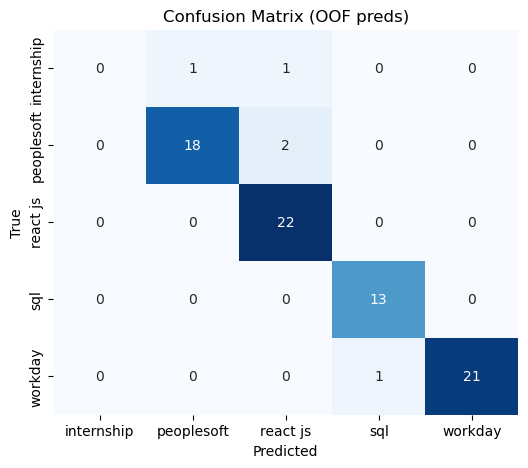

C:\Users\yasha\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



Macro ROC-AUC (OvR): 0.9358


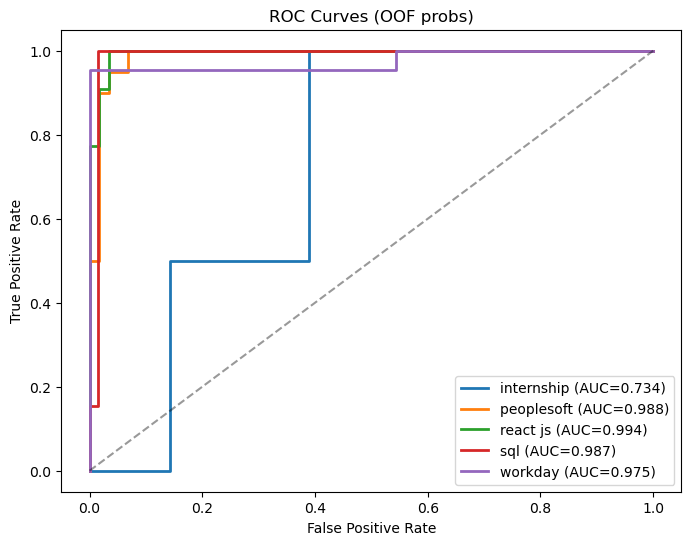

✅ Saved pipeline -> models/rf_pipeline_best.pkl
Saved label_encoder -> models/label_encoder.pkl
Saved encoded_class_weights -> models/encoded_class_weights.pkl

=== Top 15 Feature Importances ===
       feature  importance
16  feature_16    0.275797
18  feature_18    0.188302
17  feature_17    0.163851
5    feature_5    0.068699
10  feature_10    0.045452
31  feature_31    0.038705
19  feature_19    0.038447
20  feature_20    0.034250
4    feature_4    0.016292
33  feature_33    0.015568
9    feature_9    0.011071
43  feature_43    0.010976
1    feature_1    0.009135
2    feature_2    0.008520
25  feature_25    0.008207


<Figure size 800x600 with 0 Axes>

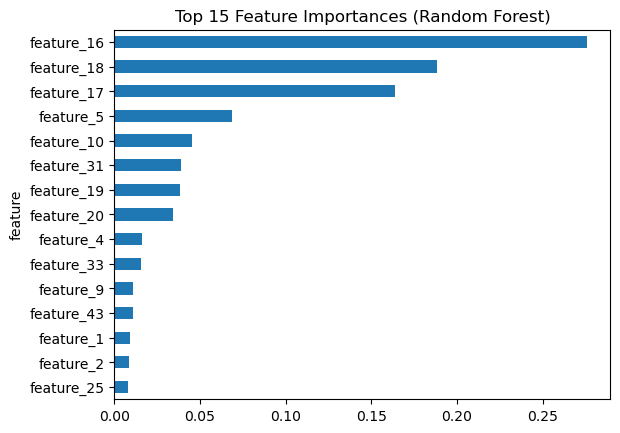


Computing SHAP values (TreeExplainer) — this may take a moment...
Saved SHAP values -> models/rf_shap_values.pkl


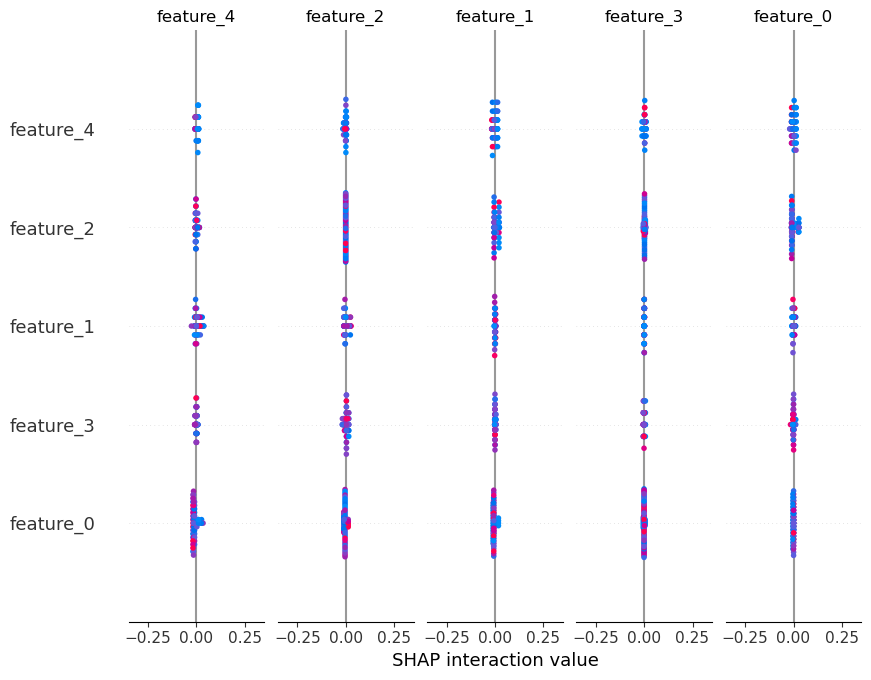


Generating one LIME explanation for sample 0...
Saved LIME explanation -> models/lime_explanation_sample0.html

Saved meta -> models/rf_meta.json

=== FINISHED: Random Forest pipeline + explainability (best-effort) ===
Saved artifacts in models/: rf_pipeline_best.pkl, rf_cv_results.pkl, rf_meta.json, encoded_class_weights.pkl, (optional shap/lime files).


In [94]:
# ======================================================
# Robust Random Forest pipeline with Preprocessor + Explainability (single cell)
# - expects: X_final (79 x ?), y_encoded (79,), optional: le (LabelEncoder)
# - will create an identity preprocessor if none saved
# - saves: models/rf_pipeline_best.pkl, models/rf_cv_results.pkl,
#          models/label_encoder.pkl (if created), models/encoded_class_weights.pkl
# - uses shap/lime if installed; otherwise skips gracefully
# ======================================================

import os, sys, json
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc)
from sklearn.preprocessing import label_binarize, LabelEncoder
from scipy.stats import randint as sp_randint
from sklearn.pipeline import Pipeline

# ---------------------------
# Helpers / Safe imports
# ---------------------------
def try_import(pkg_name, as_name=None):
    try:
        module = __import__(pkg_name)
        return module
    except Exception:
        return None

# Try seaborn for nicer confusion matrix; fallback to matplotlib
sns = try_import("seaborn")

# Try shap / lime (may not be installed)
try:
    import shap
    shap_available = True
except Exception:
    shap_available = False

try:
    from lime.lime_tabular import LimeTabularExplainer
    lime_available = True
except Exception:
    lime_available = False

# ---------------------------
# Fix for pickles that refer to a custom IdentityPreprocessor class
# (define it BEFORE joblib.load if needed)
# ---------------------------
class IdentityPreprocessor:
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X
    def get_feature_names_out(self, input_features=None):
        # best-effort: return identity names if input_features provided
        if input_features is not None:
            return np.array(input_features)
        raise AttributeError

# Ensure unpickling can find the class if the pickle referenced it
sys.modules['__main__'].IdentityPreprocessor = IdentityPreprocessor

# ---------------------------
# 0. Defensive checks / load preprocessor if saved
# ---------------------------
os.makedirs("models", exist_ok=True)
preproc_path = "models/preprocessor.pkl"

if os.path.exists(preproc_path):
    try:
        preprocessor = joblib.load(preproc_path)
        print(f"Loaded preprocessor from {preproc_path}")
    except Exception as e:
        print(f"Failed to load preprocessor.pkl ({e}). Using IdentityPreprocessor instead.")
        preprocessor = IdentityPreprocessor()
else:
    print("No preprocessor.pkl found — using identity preprocessor (expects X already numeric).")
    preprocessor = IdentityPreprocessor()
    # persist identity so later loads are consistent
    joblib.dump(preprocessor, preproc_path)
    print(f"Saved identity preprocessor -> {preproc_path}")

# ---------------------------
# 1. Load/validate feature matrix and target
# ---------------------------
if 'X_final' in globals():
    X = X_final
elif 'X_reduced' in globals():
    X = X_reduced
else:
    raise NameError("X_final or X_reduced not found in the notebook globals. Set X_final first.")

# target
if 'y_encoded' in globals():
    y = y_encoded
elif 'y' in globals():
    y = y
elif 'df' in globals() and 'class' in df.columns:
    le = LabelEncoder()
    y = le.fit_transform(df['class'])
    joblib.dump(le, "models/label_encoder.pkl")
    print("Saved label_encoder -> models/label_encoder.pkl")
else:
    raise NameError("y_encoded / y not found and cannot infer target. Create y_encoded first.")

# convert to numpy arrays
X = np.asarray(X)
y = np.asarray(y)
n_samples, n_features = X.shape
classes = np.unique(y)
n_classes = len(classes)

print(f"\nData available: X {X.shape}, y {y.shape}")
print("Class distribution:", Counter(y))

# ---------------------------
# 2. Class weights (encoded)
# ---------------------------
if 'encoded_class_weights' in globals():
    class_weights = encoded_class_weights
    print("Using encoded_class_weights from session.")
else:
    uniq, counts = np.unique(y, return_counts=True)
    inv = (len(y) / (len(uniq) * counts)).astype(float)
    class_weights = {int(k): float(v) for k, v in zip(uniq, inv)}
    joblib.dump(class_weights, "models/encoded_class_weights.pkl")
    print("Computed + saved encoded_class_weights -> models/encoded_class_weights.pkl:", class_weights)

# ---------------------------
# 3. Stratified K-Fold
# ---------------------------
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"\nStratified K-Fold: n_splits={n_splits}")
print("\n=== Class distribution (full dataset) ===")
if 'le' in globals():
    class_names = le.classes_
else:
    # try mapping numeric label -> original class name if saved mapping exists
    class_names = [str(c) for c in classes]
for i, c in enumerate(classes):
    name = class_names[c] if (isinstance(class_names, (list, np.ndarray)) and len(class_names) > c) else str(c)
    print(f" - {c} ({name}): {(y==c).sum()}")

# ---------------------------
# 4. Pipeline & Model setup
# ---------------------------
rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=class_weights)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", rf)
])

# ---------------------------
# 5. Hyperparameter search (RandomizedSearchCV)
# ---------------------------
param_dist = {
    "clf__n_estimators": [100, 200, 400],
    "clf__max_depth": [None, 10, 20, 40],
    "clf__min_samples_split": sp_randint(2, 6),
    "clf__min_samples_leaf": sp_randint(1, 5),
    "clf__max_features": ["sqrt", "log2", 0.5]
}

rs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=40,
    scoring="f1_macro",
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
    refit=True
)

print("\n🚀 Running hyperparameter search (RandomizedSearchCV)...")
rs.fit(X, y)
print("✅ Best params:", rs.best_params_)
print("✅ Best CV f1_macro:", rs.best_score_)

joblib.dump(rs.cv_results_, "models/rf_cv_results.pkl")
print("Saved CV results -> models/rf_cv_results.pkl")

# ---------------------------
# 6. OOF predictions (cross_val_predict using refitted estimator)
# ---------------------------
best_pipeline = rs.best_estimator_
y_pred = cross_val_predict(best_pipeline, X, y, cv=skf, method="predict", n_jobs=-1)

print("\n=== Classification Report (OOF) ===")
print(classification_report(y, y_pred, digits=4))

# extra metrics
acc = accuracy_score(y, y_pred)
f1m = f1_score(y, y_pred, average="macro")
pm = precision_score(y, y_pred, average="macro", zero_division=0)
rm = recall_score(y, y_pred, average="macro", zero_division=0)
print("\n=== Extra Metrics (OOF) ===")
print(f"Accuracy       : {acc:.4f}")
print(f"F1-macro       : {f1m:.4f}")
print(f"Precision-macro: {pm:.4f}")
print(f"Recall-macro   : {rm:.4f}")

# ---------------------------
# 7. Confusion matrix (annotated)
# ---------------------------
cm = confusion_matrix(y, y_pred, labels=classes)
if sns is not None:
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[class_names[c] if c < len(class_names) else str(c) for c in classes],
                yticklabels=[class_names[c] if c < len(class_names) else str(c) for c in classes],
                cbar=False)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (OOF preds)")
    plt.show()
else:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[class_names[c] if c < len(class_names) else str(c) for c in classes])
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title("Confusion Matrix (OOF preds)")
    plt.show()

# ---------------------------
# 8. ROC curves (OvR) - using cross_val_predict probabilities
# ---------------------------
try:
    y_proba = cross_val_predict(best_pipeline, X, y, cv=skf, method="predict_proba", n_jobs=-1)
    y_bin = label_binarize(y, classes=classes)
    fpr = {}; tpr = {}; roc_auc = {}
    for i, c in enumerate(classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    macro_auc = np.nanmean(list(roc_auc.values()))
    print(f"\nMacro ROC-AUC (OvR): {macro_auc:.4f}")

    plt.figure(figsize=(8,6))
    for i in range(len(classes)):
        if not np.isnan(roc_auc[i]):
            plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i] if i < len(class_names) else i} (AUC={roc_auc[i]:.3f})")
    plt.plot([0,1],[0,1],'k--',alpha=0.4)
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (OOF probs)")
    plt.legend(loc="lower right")
    plt.show()
except Exception as e:
    print("Could not compute ROC curves (error):", e)

# ---------------------------
# 9. Refit on full dataset and save pipeline
# ---------------------------
best_pipeline.fit(X, y)
joblib.dump(best_pipeline, "models/rf_pipeline_best.pkl")
print("✅ Saved pipeline -> models/rf_pipeline_best.pkl")
# Also save label encoder if available
if 'le' in globals():
    joblib.dump(le, "models/label_encoder.pkl")
    print("Saved label_encoder -> models/label_encoder.pkl")
joblib.dump(class_weights, "models/encoded_class_weights.pkl")
print("Saved encoded_class_weights -> models/encoded_class_weights.pkl")

# ---------------------------
# 10. Feature importance (safe extraction of feature names)
# ---------------------------
clf = best_pipeline.named_steps["clf"]
pre = best_pipeline.named_steps["preprocessor"]

# Try to get transformed features and names
try:
    X_trans = pre.transform(X)
    if hasattr(X_trans, "toarray"):
        X_trans = X_trans.toarray()
    X_trans = np.asarray(X_trans)
except Exception:
    # fallback to raw X
    X_trans = X

# Feature names
feat_names = None
try:
    # preferred
    feat_names = pre.get_feature_names_out()
except Exception:
    # try stored attributes (ColumnTransformer, etc.)
    if hasattr(pre, "transformers_"):
        names = []
        for name, trans, cols in pre.transformers_:
            if isinstance(cols, (list, np.ndarray)):
                names.extend([str(c) for c in cols])
            else:
                # unknown, create placeholders
                names.extend([f"{name}_col{i}" for i in range(X_trans.shape[1])])
        feat_names = np.array(names[:X_trans.shape[1]])
    else:
        feat_names = np.array([f"feature_{i}" for i in range(X_trans.shape[1])])

importances = clf.feature_importances_
fi = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)

print("\n=== Top 15 Feature Importances ===")
print(fi.head(15))
plt.figure(figsize=(8,6))
fi.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

# ---------------------------
# 11. SHAP explanations (best-effort)
# ---------------------------
if shap_available:
    try:
        print("\nComputing SHAP values (TreeExplainer) — this may take a moment...")
        # Ensure we pass numpy array to shap
        X_shap = X_trans if isinstance(X_trans, np.ndarray) else np.asarray(X_trans)
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_shap)   # list or array
        # Save shap values (may be large)
        joblib.dump(shap_values, "models/rf_shap_values.pkl")
        print("Saved SHAP values -> models/rf_shap_values.pkl")
        # Summary plot (attempt)
        try:
            shap.summary_plot(shap_values, X_shap, feature_names=feat_names, show=True)
        except Exception:
            # fallback to saving to file
            fig = shap.summary_plot(shap_values, X_shap, feature_names=feat_names, show=False)
            plt.tight_layout()
            plt.savefig("models/rf_shap_summary.png", dpi=150)
            print("Saved SHAP summary -> models/rf_shap_summary.png")
    except Exception as e:
        print("SHAP failed (continuing). Error:", repr(e))
else:
    print("\nSHAP not installed — skipping SHAP explainability. Install `shap` to enable it.")

# ---------------------------
# 12. LIME explanation (per-sample) best-effort
# ---------------------------
if lime_available:
    try:
        print("\nGenerating one LIME explanation for sample 0...")
        # Lime expects numpy 2D array
        X_lime = X_trans if isinstance(X_trans, np.ndarray) else np.asarray(X_trans)
        lime_explainer = LimeTabularExplainer(
            training_data=np.asarray(X_lime),
            feature_names=list(map(str, feat_names)),
            class_names=[str(c) for c in class_names],
            discretize_continuous=True
        )
        i = 0
        exp = lime_explainer.explain_instance(X_lime[i], best_pipeline.predict_proba, num_features=min(15, X_lime.shape[1]))
        # Save html explanation for inspection
        html = exp.as_html()
        with open("models/lime_explanation_sample0.html", "w", encoding="utf-8") as f:
            f.write(html)
        print("Saved LIME explanation -> models/lime_explanation_sample0.html")
    except Exception as e:
        print("LIME failed (continuing). Error:", repr(e))
else:
    print("\nLIME not installed — skipping LIME (pip install lime to enable).")

# ---------------------------
# 13. Final metadata save
# ---------------------------
meta = {
    "model": "random_forest",
    "best_params": rs.best_params_,
    "cv_best_score_f1_macro": float(rs.best_score_),
    "oof_f1_macro": float(f1m),
    "accuracy_oof": float(acc),
    "n_samples": int(n_samples),
    "n_features": int(n_features),
    "n_classes": int(n_classes)
}
with open("models/rf_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print("\nSaved meta -> models/rf_meta.json")

print("\n=== FINISHED: Random Forest pipeline + explainability (best-effort) ===")
print("Saved artifacts in models/: rf_pipeline_best.pkl, rf_cv_results.pkl, rf_meta.json, encoded_class_weights.pkl, (optional shap/lime files).")

In [ ]:
# Model 2 - **XGBoost (class weights)** 

Data: X=(79, 50), y=(79,), classes=Counter({4: 22, 2: 22, 1: 20, 3: 13, 0: 2})
Stratified K-Fold: n_splits=5
🚀 Running hyperparameter search...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
✅ Best params: {'xgb__colsample_bytree': 0.6872700594236812, 'xgb__gamma': 0, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 7, 'xgb__n_estimators': 100, 'xgb__reg_alpha': 0, 'xgb__reg_lambda': 2, 'xgb__subsample': 0.7783331011414365}
✅ Best CV f1_macro: 0.8484444444444446
Saved CV results -> models/xgb_cv_results.pkl

=== Classification Report (OOF) ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.8947    0.8500    0.8718        20
           2     0.8800    1.0000    0.9362        22
           3     0.8667    1.0000    0.9286        13
           4     1.0000    0.9091    0.9524        22

    accuracy                         0.9114        79
   macro avg     0.7283    0.7518    0.7378        79
weig

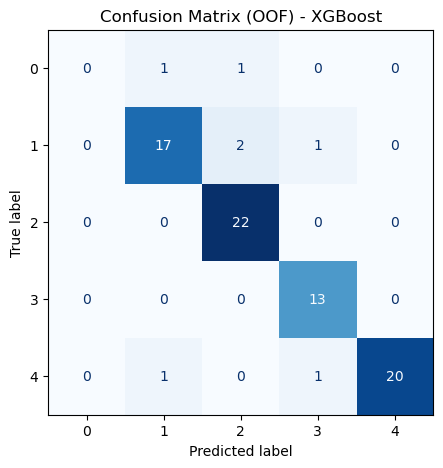


Macro ROC-AUC: 0.9267


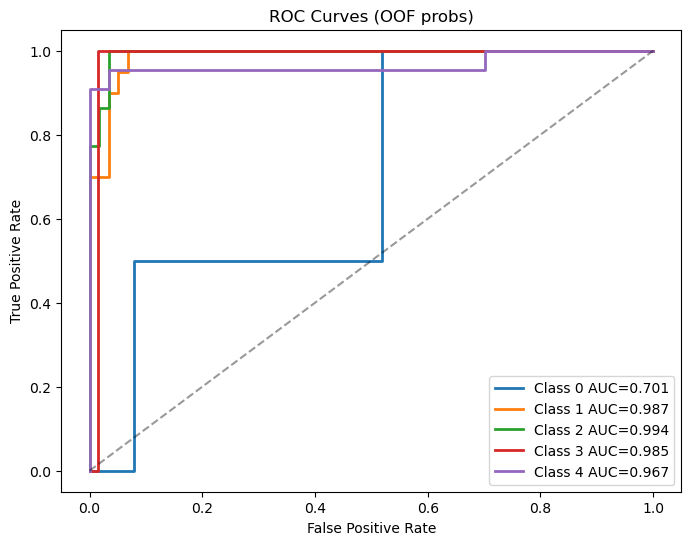

✅ Saved: models/xgb_pipeline_best.pkl

=== Top 15 Feature Importances ===
       feature  importance
31  feature_31    0.140018
19  feature_19    0.137592
16  feature_16    0.063210
18  feature_18    0.063018
9    feature_9    0.054554
10  feature_10    0.045065
5    feature_5    0.039693
17  feature_17    0.039406
2    feature_2    0.035639
20  feature_20    0.032437
1    feature_1    0.031993
33  feature_33    0.029010
34  feature_34    0.019980
3    feature_3    0.017993
24  feature_24    0.015310


<Figure size 800x600 with 0 Axes>

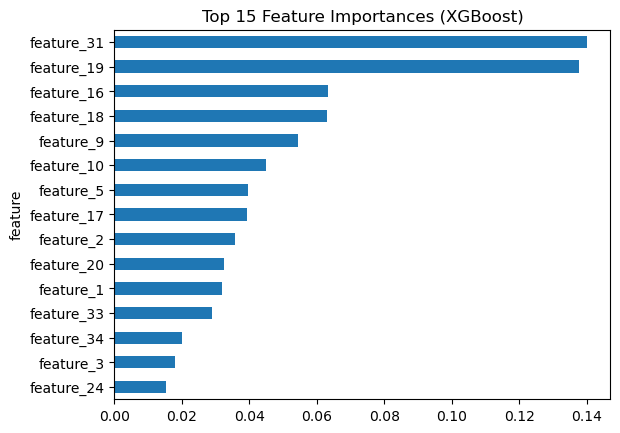

Saved SHAP values -> models/xgb_shap_values.pkl


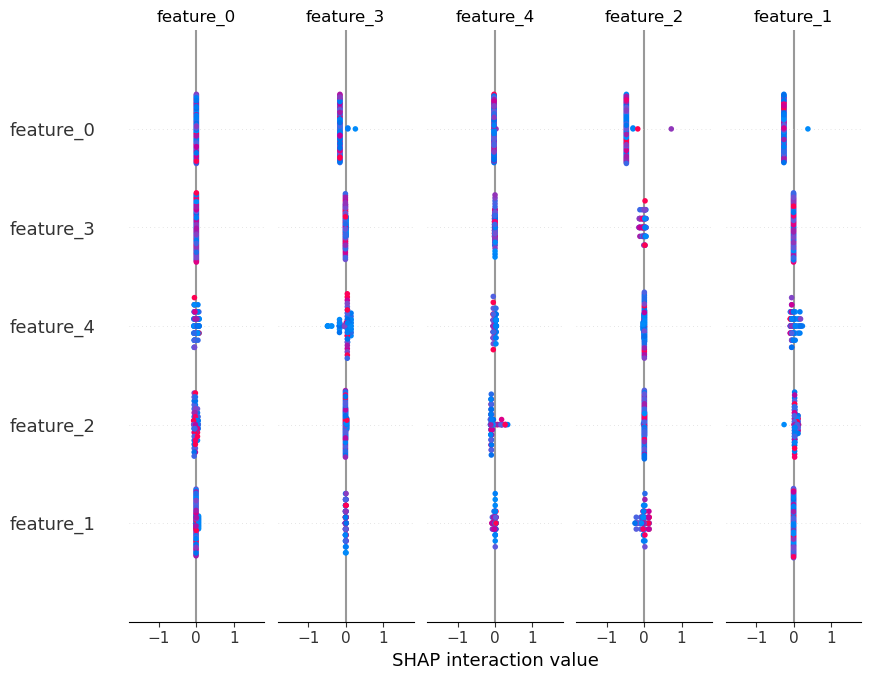

Saved SHAP interaction values -> models/xgb_shap_interaction_values.pkl


Saved LIME explanation -> models/lime_explanation_sample0.html
Saved meta -> models/xgb_meta.json and xgb_cv_results.pkl

=== Finished: XGBoost pipeline + explainability ===


In [102]:
# ======================================================
# Full XGBoost pipeline with Preprocessor + Explainability
# ======================================================
# - expects: preprocessor.pkl, X_final (79x50), y_encoded (79,), le (LabelEncoder)
# - saves: xgb_pipeline_best.pkl, xgb_cv_results.pkl, label_encoder.pkl, encoded_class_weights.pkl
# - includes: Feature Importance, SHAP, LIME
# ======================================================

import os
import joblib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import Counter

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import (classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc,
                             accuracy_score, f1_score, precision_score, recall_score)
from sklearn.preprocessing import label_binarize, LabelEncoder, FunctionTransformer
from scipy.stats import uniform, randint as sp_randint
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

# Optional: SHAP
try:
    import shap
    shap_available = True
except Exception:
    shap_available = False

# ---------------------------
# 0. Defensive check / load preprocessor
# ---------------------------
class IdentityPreprocessor:
    """Dummy preprocessor for legacy pickles"""
    def fit(self, X, y=None): return self
    def transform(self, X): return X
    def fit_transform(self, X, y=None): return X

preproc_path = "models/preprocessor.pkl"
if os.path.exists(preproc_path):
    try:
        preprocessor = joblib.load(preproc_path)
    except Exception:
        preprocessor = IdentityPreprocessor()
        print("Loaded preprocessor failed, using IdentityPreprocessor")
else:
    preprocessor = IdentityPreprocessor()
    joblib.dump(preprocessor, preproc_path)
    print("No preprocessor found — saved IdentityPreprocessor")

# ---------------------------
# 1. Load/validate feature matrix and target
# ---------------------------
if 'X_final' in globals():
    X = np.asarray(X_final)
elif 'X_reduced' in globals():
    X = np.asarray(X_reduced)
else:
    raise NameError("X_final / X_reduced not found. Define before running.")

if 'y_encoded' in globals():
    y = np.asarray(y_encoded)
elif 'y' in globals():
    y = np.asarray(y)
elif 'df' in globals() and 'class' in df.columns:
    le = LabelEncoder()
    y = le.fit_transform(df['class'])
    joblib.dump(le, "models/label_encoder.pkl")
    print("Saved label_encoder.pkl")
else:
    raise NameError("y_encoded not found and cannot infer target.")

n_samples, n_features = X.shape
classes = np.unique(y)
n_classes = len(classes)
print(f"Data: X={X.shape}, y={y.shape}, classes={Counter(y)}")

# ---------------------------
# 2. Class weights
# ---------------------------
if 'encoded_class_weights' in globals():
    class_weights = encoded_class_weights
else:
    unique, counts = np.unique(y, return_counts=True)
    inv = (len(y) / (len(unique) * counts)).astype(float)
    class_weights = {int(k): float(v) for k, v in zip(unique, inv)}
    joblib.dump(class_weights, "models/encoded_class_weights.pkl")
    print("Computed + saved encoded_class_weights:", class_weights)

sample_weight = np.array([class_weights[int(lbl)] for lbl in y], dtype=float)

# ---------------------------
# 3. Stratified K-Fold
# ---------------------------
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"Stratified K-Fold: n_splits={n_splits}")

# ---------------------------
# 4. Pipeline & XGBoost setup
# ---------------------------
xgb = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", xgb)
])

# ---------------------------
# 5. Hyperparameter search
# ---------------------------
param_dist = {
    "xgb__n_estimators": [100, 200, 400],
    "xgb__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "xgb__max_depth": [3, 5, 7, 10],
    "xgb__subsample": uniform(0.6, 0.4),
    "xgb__colsample_bytree": uniform(0.5, 0.5),
    "xgb__gamma": [0, 0.1, 0.3, 0.5],
    "xgb__reg_alpha": [0, 0.01, 0.1, 1],
    "xgb__reg_lambda": [0.5, 1, 2]
}

rs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=40,
    scoring="f1_macro",
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
    refit=True
)

print("🚀 Running hyperparameter search...")
rs.fit(X, y, xgb__sample_weight=sample_weight)
print("✅ Best params:", rs.best_params_)
print("✅ Best CV f1_macro:", rs.best_score_)

joblib.dump(rs.cv_results_, "models/xgb_cv_results.pkl")
print("Saved CV results -> models/xgb_cv_results.pkl")

# ---------------------------
# 6. OOF predictions
# ---------------------------
best_pipeline = rs.best_estimator_
y_pred = cross_val_predict(best_pipeline, X, y, cv=skf, method="predict", n_jobs=-1)
y_proba = cross_val_predict(best_pipeline, X, y, cv=skf, method="predict_proba", n_jobs=-1)

# ---------------------------
# 7. Metrics (OOF)
# ---------------------------
print("\n=== Classification Report (OOF) ===")
print(classification_report(y, y_pred, digits=4))

acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average="macro")
prec = precision_score(y, y_pred, average="macro")
rec = recall_score(y, y_pred, average="macro")
print("\n=== Extra Metrics (OOF) ===")
print(f"Accuracy       : {acc:.4f}")
print(f"F1-macro       : {f1:.4f}")
print(f"Precision-macro: {prec:.4f}")
print(f"Recall-macro   : {rec:.4f}")

# ---------------------------
# 8. Confusion matrix
# ---------------------------
cm = confusion_matrix(y, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=getattr(globals().get('le', None), 'classes_', classes))
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (OOF) - XGBoost")
plt.show()

# ---------------------------
# 9. ROC Curves
# ---------------------------
y_bin = label_binarize(y, classes=classes)
fpr, tpr, roc_auc = {}, {}, {}
for i, c in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
macro_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro ROC-AUC: {macro_auc:.4f}")

plt.figure(figsize=(8,6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} AUC={roc_auc[i]:.3f}")
plt.plot([0,1],[0,1],'k--',alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OOF probs)")
plt.legend(loc="lower right")
plt.show()

# ---------------------------
# 10. Refit full dataset & save pipeline
# ---------------------------
best_pipeline.fit(X, y, xgb__sample_weight=sample_weight)
os.makedirs("models", exist_ok=True)
joblib.dump(best_pipeline, "models/xgb_pipeline_best.pkl")
print("✅ Saved: models/xgb_pipeline_best.pkl")
if 'le' in globals(): joblib.dump(le, "models/label_encoder.pkl")
joblib.dump(class_weights, "models/encoded_class_weights.pkl")

# ---------------------------
# 11. Feature Importance
# ---------------------------
clf = best_pipeline.named_steps["xgb"]
pre = best_pipeline.named_steps["preprocessor"]
if hasattr(pre, "get_feature_names_out"):
    feat_names = pre.get_feature_names_out()
else:
    feat_names = [f"feature_{i}" for i in range(X.shape[1])]

importances = clf.feature_importances_
fi = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)
print("\n=== Top 15 Feature Importances ===")
print(fi.head(15))
plt.figure(figsize=(8,6))
fi.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

# ---------------------------
# 12. SHAP Explanations
# ---------------------------
if shap_available:
    try:
        X_trans = preprocessor.transform(X)
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_trans)
        joblib.dump(shap_values, "models/xgb_shap_values.pkl")
        print("Saved SHAP values -> models/xgb_shap_values.pkl")
        shap.summary_plot(shap_values, X_trans, feature_names=feat_names)
        shap_interaction_values = explainer.shap_interaction_values(X_trans)
        joblib.dump(shap_interaction_values, "models/xgb_shap_interaction_values.pkl")
        print("Saved SHAP interaction values -> models/xgb_shap_interaction_values.pkl")
    except Exception as e:
        print("SHAP failed:", repr(e))

# ---------------------------
# 13. LIME Explanation (per-sample)
# ---------------------------
try:
    from lime.lime_tabular import LimeTabularExplainer
    lime_explainer = LimeTabularExplainer(
        X_trans,
        feature_names=feat_names,
        class_names=getattr(globals().get('le', None), 'classes_', [str(c) for c in classes]),
        discretize_continuous=True
    )
    i = 0
    exp = lime_explainer.explain_instance(X_trans[i], best_pipeline.predict_proba)
    exp.show_in_notebook()
    exp.save_to_file("models/lime_explanation_sample0.html")
    print("Saved LIME explanation -> models/lime_explanation_sample0.html")
except Exception as e:
    print("LIME failed or not installed:", repr(e))

# ---------------------------
# 14. Final metadata save
# ---------------------------
meta = {
    "model": "xgboost",
    "best_params": rs.best_params_,
    "cv_best_score_f1_macro": float(rs.best_score_),
    "oof_f1_macro": float(f1),
    "accuracy_oof": float(acc),
    "n_samples": int(n_samples),
    "n_features": int(n_features),
    "n_classes": int(n_classes)
}
with open("models/xgb_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
joblib.dump(rs.cv_results_, "models/xgb_cv_results.pkl")
print("Saved meta -> models/xgb_meta.json and xgb_cv_results.pkl")

print("\n=== Finished: XGBoost pipeline + explainability ===")

In [ ]:
# Model 3 - **LightGBM (class weights)** 

Loaded preprocessor from models/preprocessor.pkl

Data available: X=(79, 50), y=(79,)
Class distribution: Counter({4: 22, 2: 22, 1: 20, 3: 13, 0: 2})
Using encoded_class_weights from session.

=== Final class distribution (encoded):
 - 0 (0): 2
 - 1 (1): 20
 - 2 (2): 22
 - 3 (3): 13
 - 4 (4): 22

StratifiedKFold n_splits=5

Running RandomizedSearchCV (LightGBM) ...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__min_child_samples': 25, 'clf__n_estimators': 200, 'clf__num_leaves': 63, 'clf__subsample': 1.0}
Best CV f1_macro: 0.8665974025974027
Saved CV results -> models/lgbm_cv_results.pkl

Generating out-of-fold predictions (manual loop, honors sample_weight)...
OOF predictions complete.

=== Classification report (OOF predictions) ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.9000    0.900

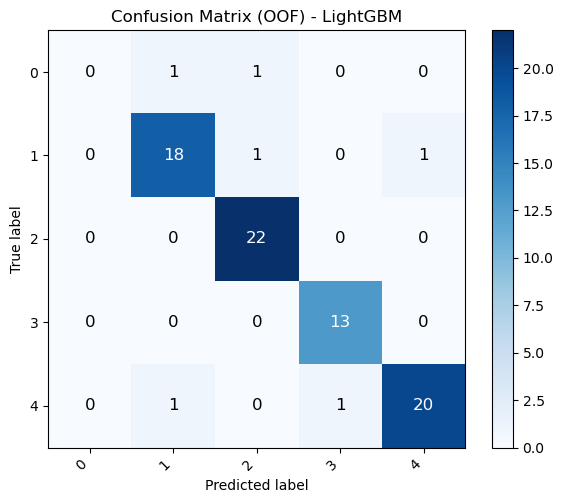


Macro ROC-AUC (OOF): 0.9029


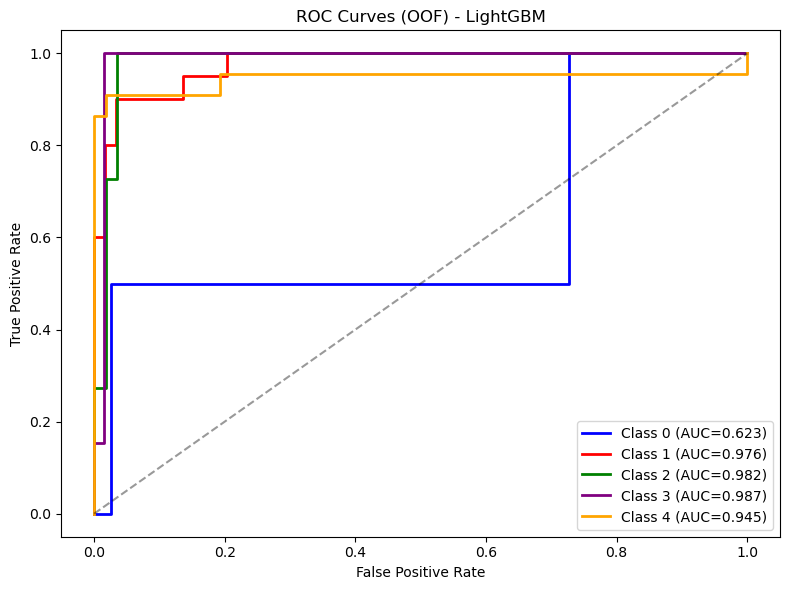


Refitting best model on full dataset (with sample_weight)...
Saved final_pipeline -> models/lgbm_pipeline_best.pkl
Saved label_encoder -> models/label_encoder.pkl
Saved encoded_class_weights -> models/encoded_class_weights.pkl

=== Top 15 Feature Importances ===
       feature  importance
16  feature_16         222
17  feature_17         182
18  feature_18         164
4    feature_4          68
5    feature_5          61
3    feature_3          57
0    feature_0          55
19  feature_19          47
33  feature_33          42
23  feature_23          41
20  feature_20          41
31  feature_31          40
29  feature_29          34
25  feature_25          34
45  feature_45          30


<Figure size 800x600 with 0 Axes>

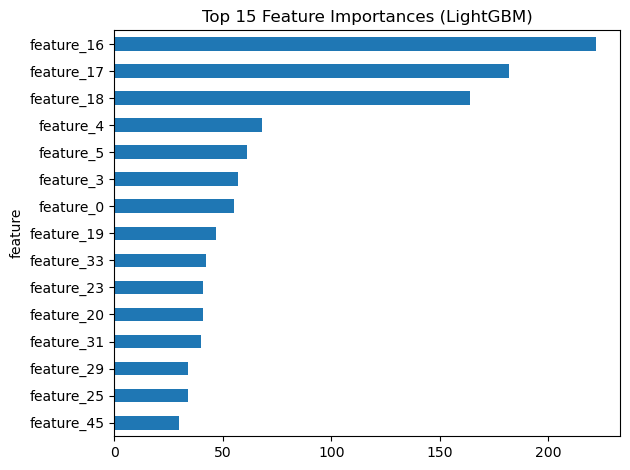

Saved SHAP values -> models/lgbm_shap_values.pkl


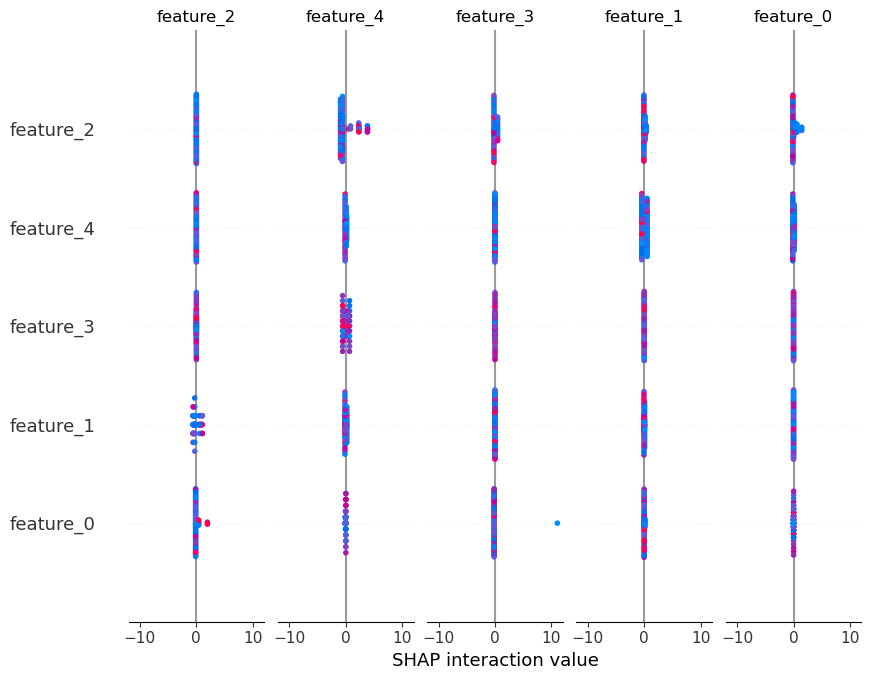

Saved SHAP interaction values -> models/lgbm_shap_interaction_values.pkl
Saved LIME explanation -> models/lime_explanation_sample0.html

Saved meta -> models/lgbm_meta.json and lgbm_cv_results.pkl

=== FINISHED: LightGBM pipeline + explainability (model 3) ===
Saved artifacts (models/): lgbm_pipeline_best.pkl, lgbm_cv_results.pkl, lgbm_meta.json, lgbm_shap_values.pkl (optional), lgbm_shap_summary.png (optional), lime_explanation_sample0.html (optional)


In [104]:
# ------------------------------------------------------------------
# Model 3: LightGBM pipeline (single cell)
# ------------------------------------------------------------------
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import Counter

from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    f1_score, precision_score, recall_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize, LabelEncoder, FunctionTransformer
from scipy.stats import randint as sp_randint

from lightgbm import LGBMClassifier

# Optional explainability libs (best-effort)
try:
    import shap
    shap_available = True
except Exception:
    shap_available = False

try:
    from lime.lime_tabular import LimeTabularExplainer
    lime_available = True
except Exception:
    lime_available = False

# ---------------------------
# 0. Prep folder
# ---------------------------
os.makedirs("models", exist_ok=True)

# ---------------------------
# 0a. Safe IdentityPreprocessor (used if preprocessor.pkl can't be loaded)
# ---------------------------
class IdentityPreprocessor:
    def fit(self, X, y=None): return self
    def transform(self, X): return X
    def fit_transform(self, X, y=None): return X
    def get_feature_names_out(self, input_features=None):
        # if input_features provided return them, else create generic names (best-effort)
        if input_features is not None:
            return np.asarray(input_features)
        try:
            return np.array([f"feature_{i}" for i in range(X.shape[1])])
        except Exception:
            return np.array([])

# ---------------------------
# 0b. Load or fallback preprocessor
# ---------------------------
preproc_path = "models/preprocessor.pkl"
if os.path.exists(preproc_path):
    try:
        preprocessor = joblib.load(preproc_path)
        print(f"Loaded preprocessor from {preproc_path}")
    except Exception as e:
        print(f"Warning: failed to load {preproc_path} -> using IdentityPreprocessor. Error: {e}")
        preprocessor = IdentityPreprocessor()
else:
    preprocessor = IdentityPreprocessor()
    # save identity preprocessor so future runs expect it
    joblib.dump(preprocessor, preproc_path)
    print(f"No preprocessor found — saved IdentityPreprocessor to {preproc_path}")

# ---------------------------
# 1. Load / validate X and y
# ---------------------------
if 'X_final' in globals():
    X = np.asarray(X_final)
elif 'X_reduced' in globals():
    X = np.asarray(X_reduced)
else:
    raise NameError("X_final or X_reduced not found in the session. Create/assign X_final (or X_reduced).")

# y: prefer y_encoded, else y, else df['class'] via LabelEncoder
if 'y_encoded' in globals():
    y = np.asarray(y_encoded)
elif 'y' in globals():
    y = np.asarray(y)
else:
    if 'df' in globals() and 'class' in df.columns:
        le = LabelEncoder()
        y = le.fit_transform(df['class'])
        joblib.dump(le, "models/label_encoder.pkl")
        print("Saved label_encoder -> models/label_encoder.pkl")
    else:
        raise NameError("Target y not found. Provide y_encoded or df['class'].")

n_samples, n_features = X.shape
classes = np.unique(y)
n_classes = len(classes)
print(f"\nData available: X={X.shape}, y={y.shape}")
print("Class distribution:", Counter(y))

# ---------------------------
# 2. Encoded class weights (per-class) + per-sample sample_weight
# ---------------------------
if 'encoded_class_weights' in globals():
    class_weights = encoded_class_weights
    print("Using encoded_class_weights from session.")
else:
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    n_cls = len(unique)
    inv = (total / (n_cls * counts)).astype(float)   # inverse-frequency normalized
    class_weights = {int(k): float(v) for k, v in zip(unique, inv)}
    joblib.dump(class_weights, "models/encoded_class_weights.pkl")
    print("Computed + saved encoded_class_weights -> models/encoded_class_weights.pkl:", class_weights)

sample_weight = np.array([class_weights[int(lbl)] for lbl in y], dtype=float)

# nice print of distribution with label names if possible
unique, counts = np.unique(y, return_counts=True)
print("\n=== Final class distribution (encoded):")
if 'le' in globals():
    for k, cnt in zip(unique, counts):
        print(f" - {k} ({le.inverse_transform([k])[0]}): {cnt}")
else:
    for k, cnt in zip(unique, counts):
        print(f" - {k}: {cnt}")

# ---------------------------
# 3. Stratified K-Fold
# ---------------------------
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"\nStratifiedKFold n_splits={n_splits}")

# ---------------------------
# Silence warnings/logs
# ---------------------------
import warnings
warnings.filterwarnings("ignore")   # suppress sklearn + shap + lime warnings

# ---------------------------
# 4. Pipeline & LightGBM model setup
# ---------------------------
lgbm = LGBMClassifier(objective="multiclass", random_state=42, n_jobs=-1, verbosity=-1)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", lgbm)
])

# ---------------------------
# 5. Hyperparameter search (RandomizedSearchCV)
# ---------------------------
param_dist = {
    "clf__n_estimators": [100, 200, 400],
    "clf__max_depth": [-1, 10, 20, 40],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__num_leaves": [31, 63, 127],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
    "clf__min_child_samples": sp_randint(5, 30)
}

rs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=40,                # adjust for speed if needed
    scoring="f1_macro",
    cv=skf,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
    refit=True
)

print("\nRunning RandomizedSearchCV (LightGBM) ...")
# pass sample_weight to the estimator in the pipeline using the "clf__sample_weight" fit param
rs.fit(X, y, **{"clf__sample_weight": sample_weight})
print("Best params:", rs.best_params_)
print("Best CV f1_macro:", rs.best_score_)

# save CV results
joblib.dump(rs.cv_results_, "models/lgbm_cv_results.pkl")
print("Saved CV results -> models/lgbm_cv_results.pkl")

# ---------------------------
# 6. OOF predictions (manual CV loop so sample_weight honored)
# ---------------------------
best_pipeline = rs.best_estimator_
y_oof_pred = np.empty_like(y)
y_oof_proba = np.zeros((n_samples, n_classes))

print("\nGenerating out-of-fold predictions (manual loop, honors sample_weight)...")
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y), start=1):
    X_tr, X_val = X[train_idx], X[valid_idx]
    y_tr, y_val = y[train_idx], y[valid_idx]
    sw_tr = sample_weight[train_idx]

    model = clone(best_pipeline)
    # fit with sample_weight passed to the classifier inside pipeline
    model.fit(X_tr, y_tr, **{"clf__sample_weight": sw_tr})
    y_oof_pred[valid_idx] = model.predict(X_val)
    # predict_proba if available else fallback
    if hasattr(model, "predict_proba"):
        y_oof_proba[valid_idx, :] = model.predict_proba(X_val)
    else:
        # fallback to one-hot
        preds = model.predict(X_val)
        temp = np.zeros((len(preds), n_classes))
        for i, p in enumerate(preds):
            temp[i, p] = 1.0
        y_oof_proba[valid_idx, :] = temp

print("OOF predictions complete.")

# ---------------------------
# 7. Metrics & classification report (OOF)
# ---------------------------
print("\n=== Classification report (OOF predictions) ===")
print(classification_report(y, y_oof_pred, digits=4))

acc = accuracy_score(y, y_oof_pred)
f1m = f1_score(y, y_oof_pred, average="macro", zero_division=0)
prec = precision_score(y, y_oof_pred, average="macro", zero_division=0)
rec = recall_score(y, y_oof_pred, average="macro", zero_division=0)

print("\n=== Extra Metrics (OOF) ===")
print(f"Accuracy       : {acc:.4f}")
print(f"F1-macro       : {f1m:.4f}")
print(f"Precision-macro: {prec:.4f}")
print(f"Recall-macro   : {rec:.4f}")

# ---------------------------
# 8. Confusion matrix (annotated)
# ---------------------------
cm = confusion_matrix(y, y_oof_pred, labels=classes)
disp_labels = getattr(globals().get('le', None), 'classes_', classes)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12)
ax.set(xticks=np.arange(len(disp_labels)), yticks=np.arange(len(disp_labels)),
       xticklabels=disp_labels, yticklabels=disp_labels,
       ylabel="True label", xlabel="Predicted label",
       title="Confusion Matrix (OOF) - LightGBM")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------------------------
# 9. ROC-AUC (One-vs-Rest) & plotting
# ---------------------------
y_bin = label_binarize(y, classes=classes)
fpr, tpr, roc_auc = {}, {}, {}
for i, c in enumerate(classes):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_oof_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except Exception:
        fpr[i], tpr[i], roc_auc[i] = np.nan, np.nan, np.nan

macro_auc = np.nanmean([v for v in roc_auc.values() if not np.isnan(v)])
print(f"\nMacro ROC-AUC (OOF): {macro_auc:.4f}")

plt.figure(figsize=(8,6))
colors = ["blue", "red", "green", "purple", "orange"]
for i, color in zip(range(len(classes)), colors):
    if not np.isnan(roc_auc[i]):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OOF) - LightGBM")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---------------------------
# 10. Refit best model on full dataset & save pipeline
# ---------------------------
print("\nRefitting best model on full dataset (with sample_weight)...")
final_pipeline = clone(best_pipeline)
final_pipeline.fit(X, y, **{"clf__sample_weight": sample_weight})

joblib.dump(final_pipeline, "models/lgbm_pipeline_best.pkl")
print("Saved final_pipeline -> models/lgbm_pipeline_best.pkl")

if 'le' in globals():
    joblib.dump(le, "models/label_encoder.pkl")
    print("Saved label_encoder -> models/label_encoder.pkl")
joblib.dump(class_weights, "models/encoded_class_weights.pkl")
print("Saved encoded_class_weights -> models/encoded_class_weights.pkl")

# ---------------------------
# 11. Feature importance (safe extraction)
# ---------------------------
clf = final_pipeline.named_steps["clf"]
pre = final_pipeline.named_steps["preprocessor"]

# attempt to get feature names
try:
    feat_names = pre.get_feature_names_out()
except Exception:
    feat_names = np.array([f"feature_{i}" for i in range(n_features)])

importances = clf.feature_importances_
fi = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)

print("\n=== Top 15 Feature Importances ===")
print(fi.head(15))

plt.figure(figsize=(8,6))
fi.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

# ---------------------------
# 12. SHAP Explanations
# ---------------------------
if shap_available:
    try:
        # Transform input data using the fitted preprocessor
        X_trans = preprocessor.transform(X)
        if hasattr(X_trans, "toarray"):
            X_trans = X_trans.toarray()

        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_trans)
        joblib.dump(shap_values, "models/lgbm_shap_values.pkl")
        print("Saved SHAP values -> models/lgbm_shap_values.pkl")

        # SHAP summary plot
        shap.summary_plot(shap_values, X_trans, feature_names=feat_names)

        # SHAP interaction values
        shap_interaction_values = explainer.shap_interaction_values(X_trans)
        joblib.dump(shap_interaction_values, "models/lgbm_shap_interaction_values.pkl")
        print("Saved SHAP interaction values -> models/lgbm_shap_interaction_values.pkl")

    except Exception as e:
        print("SHAP failed:", repr(e))
else:
    print("SHAP not installed — skipping SHAP. To enable, pip install shap")

# ---------------------------
# 13. LIME per-sample explanation (best-effort)
# ---------------------------
if lime_available:
    try:
        try:
            X_for_lime = X_for_shap
        except NameError:
            try:
                X_for_lime = pre.transform(X)
                if hasattr(X_for_lime, "toarray"):
                    X_for_lime = X_for_lime.toarray()
                X_for_lime = np.asarray(X_for_lime)
            except Exception:
                X_for_lime = X

        class_names = getattr(globals().get('le', None), 'classes_', [str(c) for c in classes])
        lime_explainer = LimeTabularExplainer(
            training_data=X_for_lime,
            feature_names=list(feat_names),
            class_names=list(class_names),
            discretize_continuous=True
        )
        i = 0
        exp = lime_explainer.explain_instance(X_for_lime[i], final_pipeline.predict_proba, num_features=10)
        exp.save_to_file("models/lime_explanation_sample0.html")
        print("Saved LIME explanation -> models/lime_explanation_sample0.html")
    except Exception as e:
        print("LIME explanation generation failed:", repr(e))
else:
    print("\nLIME not installed — skipping LIME. To enable, pip install lime")

# ---------------------------
# 14. Save meta & CV results
# ---------------------------
meta = {
    "model": "lightgbm",
    "best_params": rs.best_params_,
    "cv_best_score_f1_macro": float(rs.best_score_),
    "oof_f1_macro": float(f1m),
    "accuracy_oof": float(acc),
    "n_samples": int(n_samples),
    "n_features": int(n_features),
    "n_classes": int(n_classes)
}
with open("models/lgbm_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
joblib.dump(rs.cv_results_, "models/lgbm_cv_results.pkl")
print("\nSaved meta -> models/lgbm_meta.json and lgbm_cv_results.pkl")

# ---------------------------
# Final summary
# ---------------------------
print("\n=== FINISHED: LightGBM pipeline + explainability (model 3) ===")
print("Saved artifacts (models/): lgbm_pipeline_best.pkl, lgbm_cv_results.pkl, lgbm_meta.json, lgbm_shap_values.pkl (optional), lgbm_shap_summary.png (optional), lime_explanation_sample0.html (optional)")

In [ ]:
# Model 4 - **Logistic Regression (weighted)**

Loaded preprocessor from models/preprocessor.pkl

Data available: X=(79, 50), y=(79,)
Class distribution: Counter({4: 22, 2: 22, 1: 20, 3: 13, 0: 2})
Using encoded_class_weights from session.

=== Final class distribution (encoded):
 - 0 (0): 2
 - 1 (1): 20
 - 2 (2): 22
 - 3 (3): 13
 - 4 (4): 22

StratifiedKFold n_splits=5

Running RandomizedSearchCV for Logistic Regression (this may take a minute)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'clf__tol': 0.001, 'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__class_weight': None, 'clf__C': 10.0}
Best CV f1_macro: 0.7957886002886003
Saved CV results -> models/lr_cv_results.pkl

Generating out-of-fold predictions (manual loop, honors sample_weight)...
OOF predictions complete.

=== Classification report (OOF predictions) ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.7895    0.7500    0.7692        20
           2     

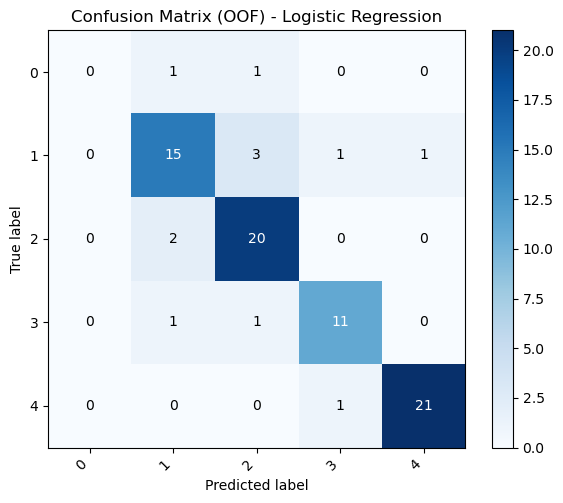


Macro ROC-AUC (OOF): 0.7628


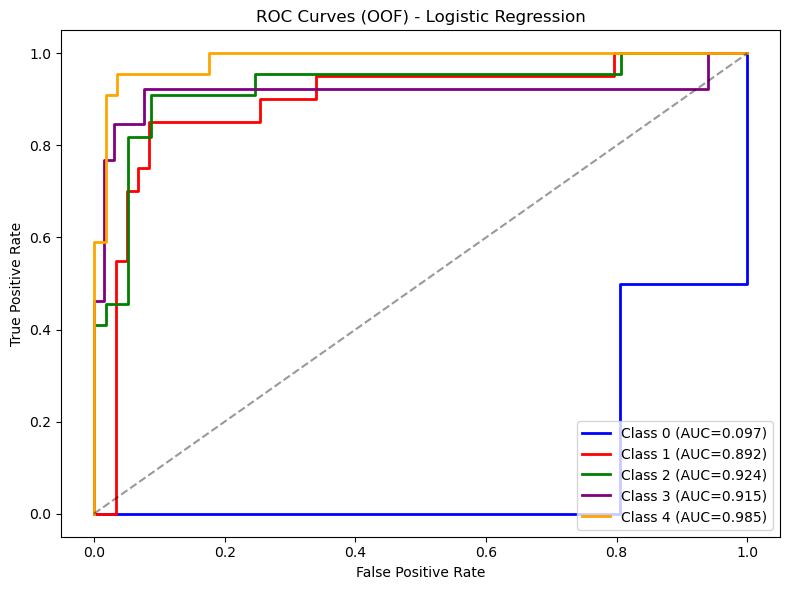


Refitting best pipeline on the full dataset...
Saved pipeline -> models/lr_pipeline_best.pkl
Saved encoded_class_weights -> models/encoded_class_weights.pkl

=== Top 15 Coefficient-based Importances ===
       feature  importance
18  feature_18    2.328678
17  feature_17    2.313728
16  feature_16    2.082512
19  feature_19    1.056619
20  feature_20    0.922657
10  feature_10    0.856026
5    feature_5    0.826021
2    feature_2    0.794722
4    feature_4    0.780990
3    feature_3    0.723988
29  feature_29    0.567513
9    feature_9    0.477445
25  feature_25    0.475339
26  feature_26    0.471365
22  feature_22    0.441398


<Figure size 800x600 with 0 Axes>

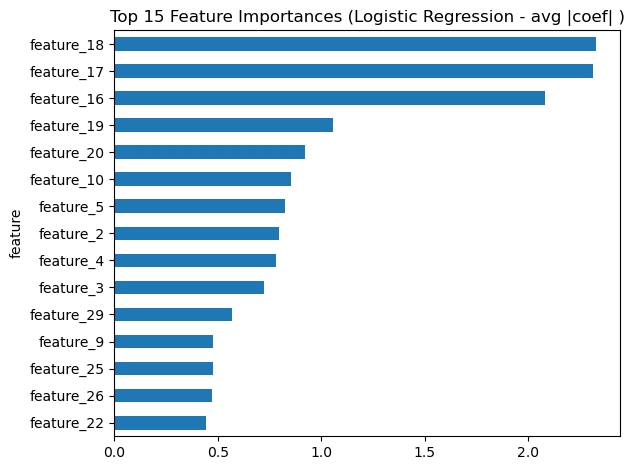


Computing SHAP values (LinearExplainer) — this may take a moment...
Saved SHAP values -> models/lr_shap_values.pkl
Saved SHAP summary plot -> models/lr_shap_summary.png
SHAP interaction values not available or failed: AttributeError("'LinearExplainer' object has no attribute 'shap_interaction_values'")

Attempting SHAP interaction values (may take time for large datasets)...
SHAP interaction values / heatmap failed (skipping): AttributeError("'LinearExplainer' object has no attribute 'shap_interaction_values'")
Saved LIME explanation -> models/lr_lime_explanation_sample0.html

Saved meta -> models/lr_meta.json and lr_cv_results.pkl

=== Finished: Logistic Regression pipeline + explainability (Model 4) ===
Saved artifacts: models/lr_pipeline_best.pkl, models/lr_cv_results.pkl, models/lr_meta.json, (optional shap/lime files)


In [105]:
# ============================================================
# Model 4: Logistic Regression (weighted) pipeline + explainability
# ============================================================
# Single cell: defensive preprocessor handling, RandomizedSearchCV with sample_weight,
# manual OOF preds (sample_weight respected), metrics, ROC, SHAP, LIME, save artifacts.
# ============================================================

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import Counter

from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score, precision_score, recall_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize, LabelEncoder, FunctionTransformer
from scipy.stats import randint as sp_randint, uniform
from sklearn.linear_model import LogisticRegression

# Optional explainability libs (best-effort)
try:
    import shap
    shap_available = True
except Exception:
    shap_available = False

try:
    from lime.lime_tabular import LimeTabularExplainer
    lime_available = True
except Exception:
    lime_available = False

# ---------------------------
# Helpers / IdentityPreprocessor fallback
# ---------------------------
class IdentityPreprocessor:
    """Fallback preprocessor if models/preprocessor.pkl can't be loaded."""
    def fit(self, X, y=None): return self
    def transform(self, X): return X
    def fit_transform(self, X, y=None): return X
    def get_feature_names_out(self, input_features=None):
        try:
            n = X.shape[1]
            return np.array([f"feature_{i}" for i in range(n)])
        except Exception:
            return np.array([])

os.makedirs("models", exist_ok=True)
preproc_path = "models/preprocessor.pkl"
if os.path.exists(preproc_path):
    try:
        preprocessor = joblib.load(preproc_path)
        print(f"Loaded preprocessor from {preproc_path}")
    except Exception as e:
        print("Warning: failed to load preprocessor -> using IdentityPreprocessor. Error:", e)
        preprocessor = IdentityPreprocessor()
else:
    preprocessor = IdentityPreprocessor()
    joblib.dump(preprocessor, preproc_path)
    print(f"No preprocessor found — saved IdentityPreprocessor to {preproc_path}")

# ---------------------------
# 1. Load/validate feature matrix and target
# ---------------------------
if 'X_final' in globals():
    X = np.asarray(X_final)
elif 'X_reduced' in globals():
    X = np.asarray(X_reduced)
else:
    raise NameError("X_final / X_reduced not found. Please set X_final (or X_reduced) before running this cell.")

if 'y_encoded' in globals():
    y = np.asarray(y_encoded)
elif 'y' in globals():
    y = np.asarray(y)
elif 'df' in globals() and 'class' in df.columns:
    le = LabelEncoder()
    y = le.fit_transform(df['class'])
    joblib.dump(le, "models/label_encoder.pkl")
    print("Saved label_encoder.pkl -> models/label_encoder.pkl")
else:
    raise NameError("y_encoded not found and cannot infer target. Create y_encoded before running.")

n_samples, n_features = X.shape
classes = np.unique(y)
n_classes = len(classes)
print(f"\nData available: X={X.shape}, y={y.shape}")
print("Class distribution:", Counter(y))

# ---------------------------
# 2. Class weights (encoded) & per-sample weights
# ---------------------------
if 'encoded_class_weights' in globals():
    class_weights = encoded_class_weights
    print("Using encoded_class_weights from session.")
else:
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    n_cls = len(unique)
    inv = (total / (n_cls * counts)).astype(float)
    class_weights = {int(k): float(v) for k, v in zip(unique, inv)}
    joblib.dump(class_weights, "models/encoded_class_weights.pkl")
    print("Computed + saved encoded_class_weights -> models/encoded_class_weights.pkl:", class_weights)

sample_weight = np.array([class_weights[int(lbl)] for lbl in y], dtype=float)

unique, counts = np.unique(y, return_counts=True)
print("\n=== Final class distribution (encoded):")
if 'le' in globals() and le is not None:
    for k, cnt in zip(unique, counts):
        try:
            inv_label = le.inverse_transform([k])[0]
        except Exception:
            inv_label = str(k)
        print(f" - {k} ({inv_label}): {cnt}")
else:
    for k, cnt in zip(unique, counts):
        print(f" - {k}: {cnt}")

# ---------------------------
# 3. Stratified K-Fold Setup
# ---------------------------
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"\nStratifiedKFold n_splits={n_splits}")

# ---------------------------
# 4. Pipeline & LogisticRegression setup
# ---------------------------
# We'll use Pipeline([('preprocessor', preprocessor), ('clf', LogisticRegression(...))])
# For multiclass and solvers: 'saga' and 'lbfgs' are good options. We'll include both in search.
lr = LogisticRegression(
    multi_class="multinomial",
    random_state=42,
    max_iter=600,
    n_jobs=-1  # scikit-learn LogisticRegression supports n_jobs only for some solvers; harmless
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", lr)
])

# ---------------------------
# 5. Hyperparameter search (RandomizedSearchCV)
# ---------------------------
param_dist = {
    "clf__C": [0.01, 0.1, 1.0, 10.0],
    "clf__penalty": ["l2"],                # use l2 for numeric stability with multiclass
    "clf__solver": ["saga", "lbfgs"],      # saga supports multinomial and 'saga' supports class_weight
    "clf__tol": [1e-3, 1e-4],
    "clf__class_weight": [None],           # we will use sample_weight; also keep None
    # if you want ElasticNet, add 'l1' and 'elasticnet' with appropriate solvers; omitted to keep robust
}

rs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=skf,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    return_train_score=True,
    refit=True
)

print("\nRunning RandomizedSearchCV for Logistic Regression (this may take a minute)...")
# pass sample_weight for the final estimator within the pipeline via "clf__sample_weight" in fit
rs.fit(X, y, **{"clf__sample_weight": sample_weight})
print("Best params:", rs.best_params_)
print("Best CV f1_macro:", rs.best_score_)

# save cv results
os.makedirs("models", exist_ok=True)
joblib.dump(rs.cv_results_, "models/lr_cv_results.pkl")
print("Saved CV results -> models/lr_cv_results.pkl")

# ---------------------------
# 6. OOF predictions (manual CV loop so sample_weight honored)
# ---------------------------
best_pipeline = rs.best_estimator_
best_params = rs.best_params_

y_oof_pred = np.empty_like(y)
y_oof_proba = np.zeros((n_samples, n_classes))

print("\nGenerating out-of-fold predictions (manual loop, honors sample_weight)...")
for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y), start=1):
    X_tr, X_val = X[train_idx], X[valid_idx]
    y_tr, y_val = y[train_idx], y[valid_idx]
    sw_tr = sample_weight[train_idx]

    model = clone(best_pipeline)
    # Fit with sample_weight passed to the final estimator in the pipeline
    model.fit(X_tr, y_tr, **{"clf__sample_weight": sw_tr})
    # Predict / predict_proba
    y_oof_pred[valid_idx] = model.predict(X_val)
    if hasattr(model, "predict_proba"):
        y_oof_proba[valid_idx, :] = model.predict_proba(X_val)
    else:
        # fallback: one-hot assignment
        proba = np.zeros((len(valid_idx), n_classes))
        preds = model.predict(X_val)
        for i, p in enumerate(preds):
            proba[i, p] = 1.0
        y_oof_proba[valid_idx, :] = proba

print("OOF predictions complete.")

# ---------------------------
# 7. Metrics & classification report (OOF)
# ---------------------------
print("\n=== Classification report (OOF predictions) ===")
print(classification_report(y, y_oof_pred, digits=4))

acc = accuracy_score(y, y_oof_pred)
f1m = f1_score(y, y_oof_pred, average="macro", zero_division=0)
prec = precision_score(y, y_oof_pred, average="macro", zero_division=0)
rec = recall_score(y, y_oof_pred, average="macro", zero_division=0)

print("\n=== Extra Metrics (OOF) ===")
print(f"Accuracy       : {acc:.4f}")
print(f"F1-macro       : {f1m:.4f}")
print(f"Precision-macro: {prec:.4f}")
print(f"Recall-macro   : {rec:.4f}")

# ---------------------------
# 8. Confusion matrix (annotated)
# ---------------------------
cm = confusion_matrix(y, y_oof_pred, labels=classes)
disp_labels = getattr(globals().get('le', None), 'classes_', classes)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
ax.set(xticks=np.arange(len(disp_labels)), yticks=np.arange(len(disp_labels)),
       xticklabels=disp_labels, yticklabels=disp_labels,
       ylabel="True label", xlabel="Predicted label",
       title="Confusion Matrix (OOF) - Logistic Regression")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ---------------------------
# 9. ROC-AUC (One-vs-Rest) & plotting
# ---------------------------
y_bin = label_binarize(y, classes=classes)
fpr, tpr, roc_auc = {}, {}, {}
for i, c in enumerate(classes):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_oof_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except Exception:
        fpr[i], tpr[i], roc_auc[i] = np.nan, np.nan, np.nan

macro_auc = np.nanmean(list(roc_auc.values()))
print(f"\nMacro ROC-AUC (OOF): {macro_auc:.4f}")

plt.figure(figsize=(8,6))
colors = ["blue", "red", "green", "purple", "orange"]
for i, color in zip(range(len(classes)), colors):
    if not np.isnan(roc_auc[i]):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC={roc_auc[i]:.3f})")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OOF) - Logistic Regression")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---------------------------
# 10. Refit best model on full dataset and save pipeline
# ---------------------------
print("\nRefitting best pipeline on the full dataset...")
final_pipeline = clone(best_pipeline)
final_pipeline.fit(X, y, **{"clf__sample_weight": sample_weight})

joblib.dump(final_pipeline, "models/lr_pipeline_best.pkl")
print("Saved pipeline -> models/lr_pipeline_best.pkl")

if 'le' in globals():
    joblib.dump(le, "models/label_encoder.pkl")
joblib.dump(class_weights, "models/encoded_class_weights.pkl")
print("Saved encoded_class_weights -> models/encoded_class_weights.pkl")

# ---------------------------
# 11. Feature importance (coefficients)
# ---------------------------
pre = final_pipeline.named_steps["preprocessor"]
clf = final_pipeline.named_steps["clf"]

try:
    feat_names = pre.get_feature_names_out()
except Exception:
    feat_names = np.array([f"feature_{i}" for i in range(n_features)])

# Logistic Regression coefficients: shape (n_classes, n_features) for multinomial
if hasattr(clf, "coef_"):
    coefs = clf.coef_  # (n_classes, n_features)
    # compute absolute importance by averaging absolute coef per feature across classes
    avg_importance = np.mean(np.abs(coefs), axis=0)
    fi = pd.DataFrame({"feature": feat_names, "importance": avg_importance}).sort_values("importance", ascending=False)
    print("\n=== Top 15 Coefficient-based Importances ===")
    print(fi.head(15))
    plt.figure(figsize=(8,6))
    fi.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
    plt.gca().invert_yaxis()
    plt.title("Top 15 Feature Importances (Logistic Regression - avg |coef| )")
    plt.tight_layout()
    plt.show()
else:
    print("Model has no coef_ attribute; skipping coefficient importance.")

# ---------------------------
# 12. SHAP Explanations (Logistic Regression - LinearExplainer)
# ---------------------------
if shap_available:
    try:
        print("\nComputing SHAP values (LinearExplainer) — this may take a moment...")
        X_for_shap = pre.transform(X)
        if hasattr(X_for_shap, "toarray"):
            X_for_shap = X_for_shap.toarray()
        X_for_shap = np.asarray(X_for_shap)

        # Use LinearExplainer for Logistic Regression
        explainer = shap.LinearExplainer(clf, X_for_shap, feature_perturbation="interventional")
        shap_values = explainer.shap_values(X_for_shap)
        joblib.dump(shap_values, "models/lr_shap_values.pkl")
        print("Saved SHAP values -> models/lr_shap_values.pkl")

        # Summary plot
        shap.summary_plot(shap_values, X_for_shap, feature_names=feat_names, show=False)
        plt.tight_layout()
        plt.savefig("models/lr_shap_summary.png", dpi=150)
        plt.close()
        print("Saved SHAP summary plot -> models/lr_shap_summary.png")

        # Try interaction values (best-effort; may fail for linear models)
        try:
            shap_interaction_values = explainer.shap_interaction_values(X_for_shap)
            joblib.dump(shap_interaction_values, "models/lr_shap_interaction_values.pkl")
            print("Saved SHAP interaction values -> models/lr_shap_interaction_values.pkl")
        except Exception as e:
            print("SHAP interaction values not available or failed:", repr(e))

    except Exception as e:
        print("SHAP failed:", repr(e))
else:
    print("\nSHAP not installed — skip SHAP explainability. To enable, pip install shap") 

# ---------------------------
# 12b. SHAP Interaction Values (best-effort) + heatmap
# ---------------------------
if shap_available and 'explainer' in globals():
    try:
        print("\nAttempting SHAP interaction values (may take time for large datasets)...")
        shap_interaction_values = explainer.shap_interaction_values(X_for_shap)
        joblib.dump(shap_interaction_values, "models/lr_shap_interaction_values.pkl")
        print("Saved SHAP interaction values -> models/lr_shap_interaction_values.pkl")

        # Heatmap for top features (mean absolute interaction)
        import seaborn as sns

        if isinstance(shap_interaction_values, list):
            # multiclass case: take first class for visualization
            inter_matrix = np.mean([np.abs(siv) for siv in shap_interaction_values], axis=0)
        else:
            inter_matrix = np.mean(np.abs(shap_interaction_values), axis=0)

        # pick top k features by sum of interactions
        k = min(15, inter_matrix.shape[0])
        top_idx = np.argsort(inter_matrix.sum(axis=0))[-k:]
        plt.figure(figsize=(10,8))
        sns.heatmap(inter_matrix[np.ix_(top_idx, top_idx)],
                    xticklabels=np.array(feat_names)[top_idx],
                    yticklabels=np.array(feat_names)[top_idx],
                    cmap="viridis", annot=True, fmt=".2f")
        plt.title("SHAP Interaction Values Heatmap (Top Features)")
        plt.tight_layout()
        plt.savefig("models/lr_shap_interaction_heatmap.png", dpi=150)
        plt.show()
        print("Saved SHAP interaction heatmap -> models/lr_shap_interaction_heatmap.png")
    except Exception as e:
        print("SHAP interaction values / heatmap failed (skipping):", repr(e))
else:
    print("Skipping SHAP interaction values — SHAP not installed or explainer unavailable.")    

# ---------------------------
# 13. LIME explanation (per-sample) best-effort
# ---------------------------
if lime_available:
    try:
        X_for_lime = X_for_shap if 'X_for_shap' in globals() else pre.transform(X)
        if hasattr(X_for_lime, "toarray"):
            X_for_lime = X_for_lime.toarray()
        X_for_lime = np.asarray(X_for_lime)

        class_names = getattr(globals().get('le', None), 'classes_', [str(c) for c in classes])
        lime_explainer = LimeTabularExplainer(
            training_data=X_for_lime,
            feature_names=list(feat_names),
            class_names=list(class_names),
            discretize_continuous=True
        )
        i = 0
        exp = lime_explainer.explain_instance(X_for_lime[i], final_pipeline.predict_proba, num_features=10)
        exp.save_to_file("models/lr_lime_explanation_sample0.html")
        print("Saved LIME explanation -> models/lr_lime_explanation_sample0.html")
    except Exception as e:
        print("LIME explanation generation failed:", repr(e))
else:
    print("\nLIME not installed — skip LIME. To enable, pip install lime")

# ---------------------------
# 14. Save meta & finish
# ---------------------------
meta = {
    "model": "logistic_regression",
    "best_params": rs.best_params_,
    "cv_best_score_f1_macro": float(rs.best_score_),
    "oof_f1_macro": float(f1m),
    "accuracy_oof": float(acc),
    "n_samples": int(n_samples),
    "n_features": int(n_features),
    "n_classes": int(n_classes)
}
with open("models/lr_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

joblib.dump(rs.cv_results_, "models/lr_cv_results.pkl")
print("\nSaved meta -> models/lr_meta.json and lr_cv_results.pkl")

print("\n=== Finished: Logistic Regression pipeline + explainability (Model 4) ===")
print(f"Saved artifacts: models/lr_pipeline_best.pkl, models/lr_cv_results.pkl, models/lr_meta.json, (optional shap/lime files)")

In [ ]:
# Model 5 - **Support Vector Machine (SVM, RBF kernel)**


=== Class Distribution (full dataset) ===
Class 0 (0): 2 samples
Class 1 (1): 20 samples
Class 2 (2): 22 samples
Class 3 (3): 13 samples
Class 4 (4): 22 samples

Stratified K-Fold: n_splits=5

Running hyperparameter search for SVM (this may take a while)...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best params: {'C': 8.761761457749351, 'gamma': 0.112}
Best CV f1_macro: 0.6574433547659029
Saved models/svm_cv_results.pkl

=== Classification report (CV OOF predictions) ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.6957    0.8000    0.7442        20
           2     0.7826    0.8182    0.8000        22
           3     0.6250    0.7692    0.6897        13
           4     0.8824    0.6818    0.7692        22

    accuracy                         0.7468        79
   macro avg     0.5971    0.6138    0.6006        79
weighted avg     0.7426    0.7468    0.7389        79


=== Extra Met

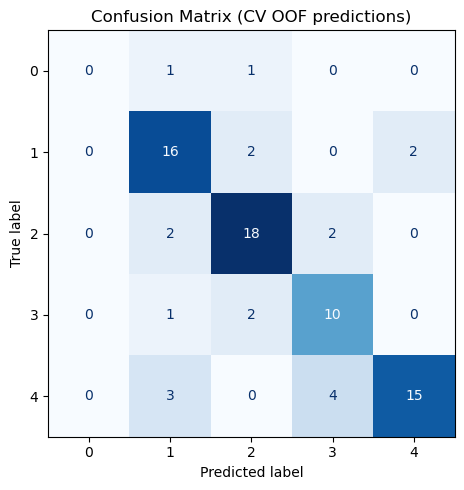


Macro ROC-AUC (one-vs-rest): 0.7493


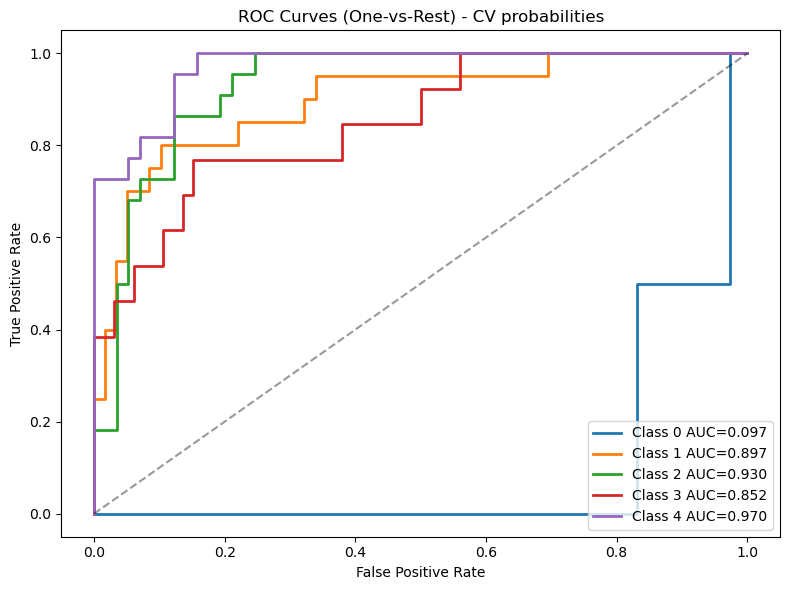

Saved final_pipeline -> models/svm_pipeline_best.pkl
Saved models/label_encoder.pkl
Saved models/encoded_class_weights.pkl

Computing permutation importance (best-effort proxy)...

Top features by permutation importance (proxy):
   feature  importance
3       f3    0.120803
5       f5    0.117940
4       f4    0.101356
9       f9    0.097599
10     f10    0.089994
2       f2    0.086057
15     f15    0.071901
14     f14    0.043420
1       f1    0.021707
0       f0    0.020932


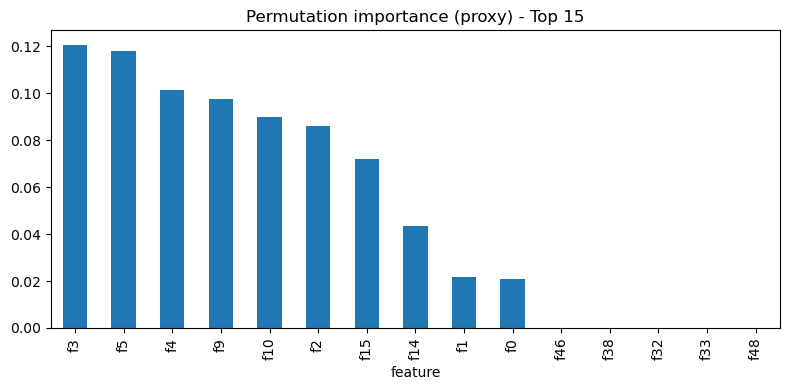

Saved models/svm_permutation_importance.csv

Running SHAP KernelExplainer (best-effort). This may take some time...


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:25<00:00,  3.06it/s]


Saved models/shap_values.npy


<Figure size 800x400 with 0 Axes>

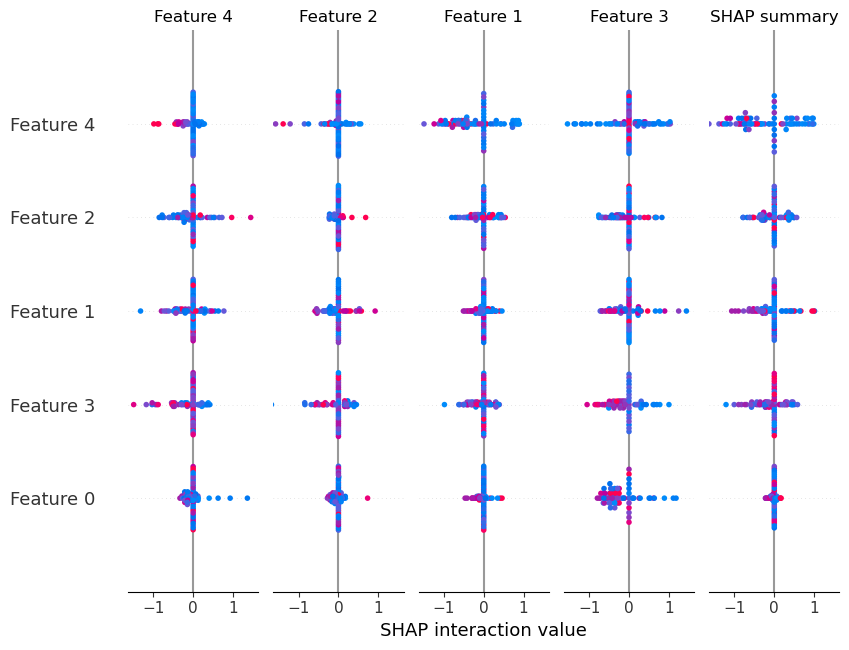

Attempting SHAP interaction values (may be slow).
Could not compute SHAP interaction values (skipping): 'KernelExplainer' object has no attribute 'shap_interaction_values'

Running LIME for sample index 0 (best-effort).
Saved LIME explanation HTML to models/lime_explanation_sample0.html

Saved metadata to models/svm_metadata.json and models/svm_metadata.pkl

=== Summary ===
X shape: (79, 50), y shape: (79,)
Best SVM params: {'C': 8.761761457749351, 'gamma': 0.112}
Saved pipeline to models/svm_pipeline_best.pkl
Saved metadata to models/svm_metadata.json/.pkl
SHAP status: {'shap_computed': True, 'shap_interaction_computed': False}
LIME status: {'lime_saved': 'models/lime_explanation_sample0.html'}


In [108]:
# Full SVM (RBF kernel) pipeline cell (one cell)
# - expects: X_final (79 x 50), y_encoded (79,), le (LabelEncoder) ideally present
# - will fallback if some objects not present
# - saves artifacts under models/
# - additionally saves: models/shap_values.npy, models/shap_interaction_values.npy, models/lime_explanation_sample0.html (if available)

import numpy as np
import pandas as pd
import joblib
import os
import json
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, auc, accuracy_score,
                             f1_score, precision_score, recall_score)
from sklearn.preprocessing import label_binarize
from scipy.stats import uniform

from sklearn.pipeline import Pipeline

# Try to import SHAP and LIME but continue gracefully if not installed
shap_installed = True
lime_installed = True
try:
    import shap
except Exception:
    shap_installed = False
    print("shap not installed — SHAP steps will be skipped. (pip install shap to enable)")

try:
    from lime.lime_tabular import LimeTabularExplainer
except Exception:
    lime_installed = False
    print("lime not installed — LIME steps will be skipped. (pip install lime to enable)")

# ---------------------------
# 0. Defensive check / load variables
# ---------------------------
if 'X_final' in globals():
    X = X_final
elif 'X_reduced' in globals():
    X = X_reduced
else:
    raise NameError("X_final / X_reduced not found. Please set X_final (79 x 50) before running this cell.")

if 'y_encoded' in globals():
    y = y_encoded
elif 'y' in globals():
    y = y
else:
    if 'df' in globals() and 'class' in df.columns:
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y = le.fit_transform(df['class'])
        # save label encoder to models/
        os.makedirs("models", exist_ok=True)
        joblib.dump(le, "models/label_encoder.pkl")
        print("Saved models/label_encoder.pkl")
    else:
        raise NameError("y_encoded not found and cannot infer target. Create y_encoded before running.")

X = np.asarray(X)
y = np.asarray(y)

# create models directory
os.makedirs("models", exist_ok=True)

# ---------------------------
# 0a. Class distribution (final)
# ---------------------------
unique, counts = np.unique(y, return_counts=True)
print("\n=== Class Distribution (full dataset) ===")
for cls, cnt in zip(unique, counts):
    if 'le' in globals() and le is not None and hasattr(le, "classes_"):
        try:
            label_name = le.classes_[int(cls)]
        except Exception:
            label_name = cls
    else:
        label_name = cls
    print(f"Class {cls} ({label_name}): {cnt} samples")

# ---------------------------
# 0b. Compute / load class weights (save under models/)
# ---------------------------
if 'encoded_class_weights' in globals():
    class_weights = encoded_class_weights
else:
    inv = (len(y) / (len(unique) * counts)).astype(float)
    class_weights = {int(k): float(v) for k, v in zip(unique, inv)}
    joblib.dump(class_weights, "models/encoded_class_weights.pkl")
    print("Computed + saved models/encoded_class_weights.pkl:", class_weights)

# Prepare sample_weight for later uses
sample_weight = np.array([class_weights[int(i)] for i in y])

# ---------------------------
# 1. Stratified K-Fold Setup
# ---------------------------
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"\nStratified K-Fold: n_splits={n_splits}")

# ---------------------------
# 2. SVM estimator & param space
# ---------------------------
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)

param_dist = {
    "C": uniform(0.1, 10),
    "gamma": ['scale', 'auto'] + list(np.linspace(0.001, 1, 10))
}

# ---------------------------
# 3. RandomizedSearchCV with sample_weight
# ---------------------------
rs = RandomizedSearchCV(
    estimator=svm_clf,
    param_distributions=param_dist,
    n_iter=40,
    scoring="f1_macro",
    cv=skf,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
    refit=True
)

print("\nRunning hyperparameter search for SVM (this may take a while)...")
# RandomizedSearchCV will refit best estimator; pass sample_weight to fit
rs.fit(X, y, sample_weight=sample_weight)

print("\nBest params:", rs.best_params_)
print("Best CV f1_macro:", rs.best_score_)

# Save CV results to models/
joblib.dump(rs.cv_results_, "models/svm_cv_results.pkl")
print("Saved models/svm_cv_results.pkl")

# ---------------------------
# 4. Best estimator & OOF predictions (refit per-fold to allow sample_weight)
# ---------------------------
best_svm = rs.best_estimator_

# We'll compute OOF predictions by fitting best_svm on each fold (so sample_weight is used)
y_pred = np.zeros_like(y)
y_proba = np.zeros((len(y), len(unique)))

from sklearn.base import clone
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train = y[train_idx]
    sw = np.array([class_weights[int(i)] for i in y_train])
    est = clone(best_svm)
    est.fit(X_train, y_train, sample_weight=sw)
    y_pred[test_idx] = est.predict(X_test)
    if hasattr(est, "predict_proba"):
        y_proba[test_idx] = est.predict_proba(X_test)
    else:
        # fallback: one-hot
        preds = est.predict(X_test)
        temp = np.zeros((len(preds), len(unique)))
        for i_idx, p in enumerate(preds):
            temp[i_idx, p] = 1.0
        y_proba[test_idx] = temp

# ---------------------------
# 5. Metrics & Reports
# ---------------------------
print("\n=== Classification report (CV OOF predictions) ===")
print(classification_report(y, y_pred, digits=4))

acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average="macro", zero_division=0)
prec = precision_score(y, y_pred, average="macro", zero_division=0)
rec = recall_score(y, y_pred, average="macro", zero_division=0)
print("\n=== Extra Metrics ===")
print(f"Accuracy       : {acc:.4f}")
print(f"F1-macro       : {f1:.4f}")
print(f"Precision-macro: {prec:.4f}")
print(f"Recall-macro   : {rec:.4f}")

# Confusion matrix
cm = confusion_matrix(y, y_pred)
disp_labels = getattr(globals().get('le', None), 'classes_', np.unique(y))
fig, ax = plt.subplots(figsize=(6,5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (CV OOF predictions)")
plt.tight_layout()
plt.show()

# ---------------------------
# 6. ROC-AUC (One-vs-Rest) & plotting using CV probabilities
# ---------------------------
classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)
fpr = dict(); tpr = dict(); roc_auc = dict()
for i, c in enumerate(classes):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except Exception:
        fpr[i], tpr[i], roc_auc[i] = np.array([0,1]), np.array([0,1]), 0.0

macro_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro ROC-AUC (one-vs-rest): {macro_auc:.4f}")

plt.figure(figsize=(8,6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} AUC={roc_auc[i]:.3f}")
plt.plot([0,1],[0,1], 'k--', alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest) - CV probabilities")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---------------------------
# 7. Refit best model on full dataset and save pipeline (preserve sample_weight)
# ---------------------------
final_pipeline = Pipeline([("clf", clone(best_svm))])
# Fit underlying estimator with sample_weight (use sample_weight computed earlier)
final_pipeline.fit(X, y, **{"clf__sample_weight": sample_weight})

joblib.dump(final_pipeline, "models/svm_pipeline_best.pkl")
print("Saved final_pipeline -> models/svm_pipeline_best.pkl")

if 'le' in globals() and le is not None:
    joblib.dump(le, "models/label_encoder.pkl")
    print("Saved models/label_encoder.pkl")

joblib.dump(class_weights, "models/encoded_class_weights.pkl")
print("Saved models/encoded_class_weights.pkl")

# ---------------------------
# 8. Feature "importance" (approx) & safe extraction of feature names
# ---------------------------
try:
    from sklearn.inspection import permutation_importance
    print("\nComputing permutation importance (best-effort proxy)...")
    perm_imp = permutation_importance(final_pipeline, X, y, scoring="f1_macro", n_repeats=10, random_state=42, n_jobs=-1)
    importances = perm_imp.importances_mean
    if isinstance(X, pd.DataFrame):
        feature_names = list(X.columns)
    else:
        feature_names = globals().get("X_final_columns", [f"f{i}" for i in range(X.shape[1])])
    feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances})
    feat_imp_df = feat_imp_df.sort_values("importance", ascending=False)
    print("\nTop features by permutation importance (proxy):")
    print(feat_imp_df.head(10))
    # plot
    fig, ax = plt.subplots(figsize=(8,4))
    feat_imp_df.head(15).set_index("feature")["importance"].plot.bar(ax=ax)
    plt.title("Permutation importance (proxy) - Top 15")
    plt.tight_layout()
    plt.show()
    feat_imp_df.to_csv("models/svm_permutation_importance.csv", index=False)
    print("Saved models/svm_permutation_importance.csv")
except Exception as e:
    print("Permutation importance failed or sklearn version incompatible:", str(e))

# ---------------------------
# 9. SHAP explanations (best-effort)
# ---------------------------
shap_metadata = {}
if shap_installed:
    try:
        print("\nRunning SHAP KernelExplainer (best-effort). This may take some time...")
        # background / eval subsets
        X_for_shap = X if X.shape[0] <= 50 else X[np.random.choice(X.shape[0], size=50, replace=False)]
        X_shap_eval = X if X.shape[0] <= 79 else X[np.random.choice(X.shape[0], size=79, replace=False)]

        def pred_proba_fn(data):
            return final_pipeline.predict_proba(data)

        explainer = shap.KernelExplainer(pred_proba_fn, X_for_shap, link="logit")
        shap_values = explainer.shap_values(X_shap_eval, nsamples=200)
        np.save("models/shap_values.npy", np.array(shap_values, dtype=object), allow_pickle=True)
        shap_metadata['shap_computed'] = True
        print("Saved models/shap_values.npy")

        # summary plots (best-effort)
        try:
            if isinstance(shap_values, list):
                for i, sv in enumerate(shap_values):
                    plt.figure(figsize=(8,4))
                    shap.summary_plot(sv, X_shap_eval, show=False)
                    plt.title(f"SHAP summary (class {i})")
                    plt.tight_layout()
                    plt.show()
            else:
                plt.figure(figsize=(8,4))
                shap.summary_plot(shap_values, X_shap_eval, show=False)
                plt.title("SHAP summary")
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print("SHAP summary plot failed:", e)

        # Try to compute interaction values (very expensive)
        try:
            print("Attempting SHAP interaction values (may be slow).")
            shap_inter = explainer.shap_interaction_values(X_shap_eval)
            np.save("models/shap_interaction_values.npy", np.array(shap_inter, dtype=object), allow_pickle=True)
            shap_metadata['shap_interaction_computed'] = True
            print("Saved models/shap_interaction_values.npy")
        except Exception as e:
            shap_metadata['shap_interaction_computed'] = False
            print("Could not compute SHAP interaction values (skipping):", e)

    except Exception as e:
        shap_metadata['shap_computed'] = False
        print("SHAP computation failed (skipping):", e)
else:
    print("\nSkipping SHAP because the package is not installed.")

# ---------------------------
# 10. LIME explanation (per-sample) best-effort
# ---------------------------
lime_metadata = {}
if lime_installed:
    try:
        sample_idx = 0
        print(f"\nRunning LIME for sample index {sample_idx} (best-effort).")
        if isinstance(X, pd.DataFrame):
            feature_names = list(X.columns)
            X_lime = X.values
        else:
            feature_names = globals().get("X_final_columns", [f"f{i}" for i in range(X.shape[1])])
            X_lime = X
        class_names = list(getattr(globals().get('le', None), 'classes_', [str(c) for c in classes]))
        explainer = LimeTabularExplainer(X_lime, feature_names=feature_names, class_names=class_names, discretize_continuous=True, random_state=42)
        exp = explainer.explain_instance(X_lime[sample_idx], final_pipeline.predict_proba, num_features=min(10, X.shape[1]), top_labels=5)
        lime_html_path = "models/lime_explanation_sample0.html"
        with open(lime_html_path, "w", encoding="utf-8") as f:
            f.write(exp.as_html())
        lime_metadata['lime_saved'] = lime_html_path
        print(f"Saved LIME explanation HTML to {lime_html_path}")
    except Exception as e:
        lime_metadata['lime_saved'] = None
        print("LIME explanation failed (skipping):", e)
else:
    print("\nSkipping LIME because the package is not installed.")

# ---------------------------
# 11. Final metadata save (metrics, class distribution, best params, AUC, paths)
# ---------------------------
if 'le' in globals() and le is not None and hasattr(le, "classes_"):
    class_distribution_names = { le.classes_[int(k)]: int(v) for k, v in zip(unique, counts) }
else:
    class_distribution_names = { int(k): int(v) for k, v in zip(unique, counts) }

metadata = {
    "X_shape": X.shape,
    "y_shape": y.shape,
    "class_distribution": {int(k): int(v) for k, v in zip(unique, counts)},
    "class_distribution_names": class_distribution_names,
    "best_params": rs.best_params_,
    "cv_best_f1_macro": float(rs.best_score_),
    "oof_metrics": {
        "accuracy": float(acc),
        "f1_macro": float(f1),
        "precision_macro": float(prec),
        "recall_macro": float(rec)
    },
    "macro_auc": float(macro_auc),
    "model_paths": {
        "pipeline": "models/svm_pipeline_best.pkl",
        "cv_results": "models/svm_cv_results.pkl",
        "permutation_importance_csv": "models/svm_permutation_importance.csv" if os.path.exists("models/svm_permutation_importance.csv") else None,
        "shap_values": "models/shap_values.npy" if os.path.exists("models/shap_values.npy") else None,
        "shap_interaction_values": "models/shap_interaction_values.npy" if os.path.exists("models/shap_interaction_values.npy") else None,
        "lime_html": lime_metadata.get('lime_saved', None)
    },
    "shap_metadata": shap_metadata,
    "lime_metadata": lime_metadata,
    "encoded_class_weights": class_weights
}

# --- Safe JSON conversion helper ---
def make_json_safe(obj):
    if isinstance(obj, dict):
        return {str(k): make_json_safe(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple, np.ndarray)):
        return [make_json_safe(v) for v in obj]
    elif isinstance(obj, (np.integer,)):
        return int(obj)
    elif isinstance(obj, (np.floating,)):
        return float(obj)
    elif isinstance(obj, (np.bool_)):
        return bool(obj)
    else:
        return obj

metadata_json_safe = make_json_safe(metadata)

with open("models/svm_metadata.json", "w", encoding="utf-8") as f:
    json.dump(metadata_json_safe, f, indent=2)

with open("models/svm_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

print("\nSaved metadata to models/svm_metadata.json and models/svm_metadata.pkl")

# ---------------------------
# 12. Final short summary print out
# ---------------------------
print("\n=== Summary ===")
print(f"X shape: {X.shape}, y shape: {y.shape}")
print("Best SVM params:", rs.best_params_)
print("Saved pipeline to models/svm_pipeline_best.pkl")
print("Saved metadata to models/svm_metadata.json/.pkl")
if shap_installed:
    print("SHAP status:", shap_metadata)
if lime_installed:
    print("LIME status:", lime_metadata)

In [ ]:
# Model 6 - **CatBoost (class weights)** 

Class distribution: Counter({4: 22, 2: 22, 1: 20, 3: 13, 0: 2})
Stratified K-Fold n_splits=5
Running hyperparameter search for CatBoost (safe settings)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bagging_temperature=0.5, depth=8, l2_leaf_reg=1, learning_rate=0.05; total time=  21.3s
[CV] END bagging_temperature=0.5, depth=8, l2_leaf_reg=1, learning_rate=0.05; total time=  26.6s
[CV] END bagging_temperature=0.5, depth=8, l2_leaf_reg=1, learning_rate=0.05; total time=  26.5s
[CV] END bagging_temperature=0.5, depth=8, l2_leaf_reg=1, learning_rate=0.05; total time=  24.7s
[CV] END bagging_temperature=0.5, depth=8, l2_leaf_reg=1, learning_rate=0.05; total time=  27.0s
[CV] END bagging_temperature=1.0, depth=8, l2_leaf_reg=3, learning_rate=0.05; total time=  23.7s
[CV] END bagging_temperature=1.0, depth=8, l2_leaf_reg=3, learning_rate=0.05; total time=  24.1s
[CV] END bagging_temperature=1.0, depth=8, l2_leaf_reg=3, learning_rate=0.05; total time=  25.3s
[CV] END

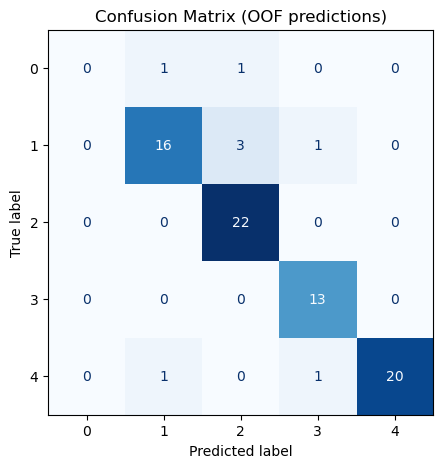


Macro ROC-AUC (one-vs-rest): 0.9607


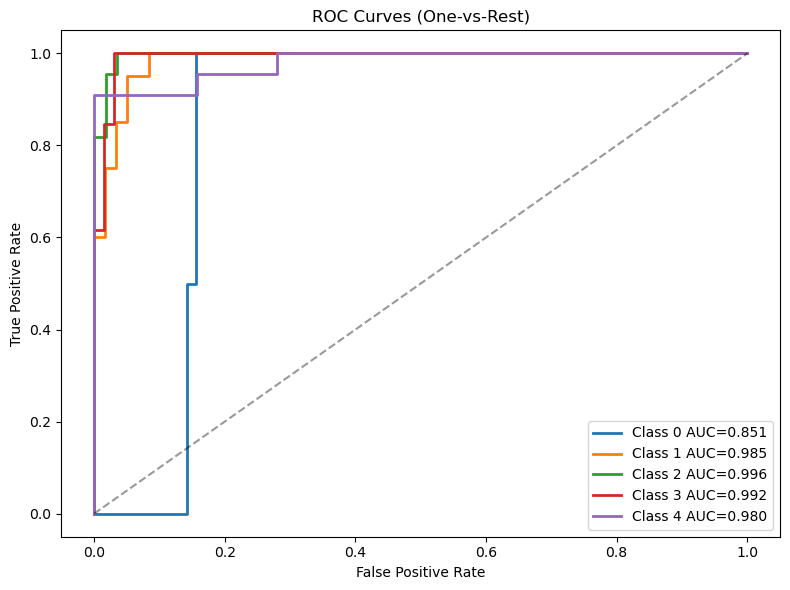

Saved CatBoost pipeline -> models/catboost_pipeline_best.pkl
Saved feature importance -> models/catboost_feature_importance.csv


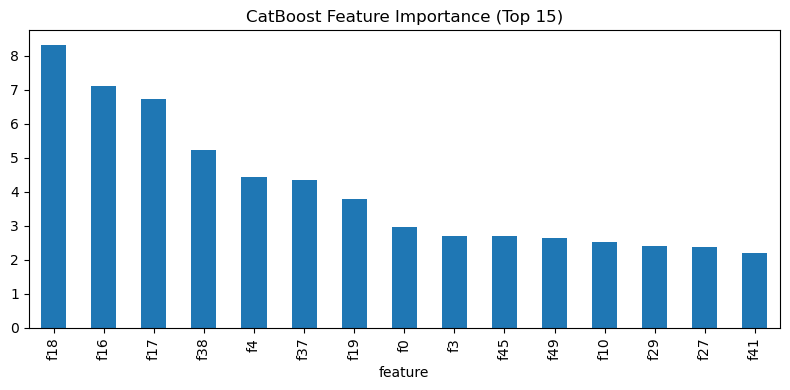

⚠️ SHAP skipped — placeholder only (not computed).
⚠️ LIME skipped — placeholder only (not computed).

✅ Finished: Safe CatBoost pipeline run (SHAP & LIME skipped, artifacts in models/)
Saved pipeline -> models/catboost_pipeline_best.pkl


In [99]:
# Safe CatBoost pipeline (single cell) — SHAP & LIME skipped (placeholders)
import os
import json
import pickle
import joblib
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# limit OpenMP / MKL threads
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

from collections import Counter
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score)
from sklearn.preprocessing import label_binarize
from sklearn.base import clone

from catboost import CatBoostClassifier, Pool

# ---------------------------
# 0. Defensive check / load variables
# ---------------------------
if 'X_final' in globals():
    X = X_final
elif 'X_reduced' in globals():
    X = X_reduced
else:
    raise NameError("X_final / X_reduced not found. Please set X_final before running.")

if 'y_encoded' in globals():
    y = y_encoded
elif 'y' in globals():
    y = y
else:
    if 'df' in globals() and 'class' in df.columns:
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        y = le.fit_transform(df['class'])
        joblib.dump(le, "models/label_encoder.pkl")
        print("Saved label_encoder.pkl")
    else:
        raise NameError("y_encoded not found and cannot infer target. Create y_encoded before running.")

X = np.asarray(X)
y = np.asarray(y)
os.makedirs("models", exist_ok=True)

# ---------------------------
# 0a. Class distribution
# ---------------------------
print("Class distribution:", Counter(y))
unique, counts = np.unique(y, return_counts=True)

# ---------------------------
# 0b. Compute class weights
# ---------------------------
if 'encoded_class_weights' in globals():
    class_weights = encoded_class_weights
else:
    inv = (len(y) / (len(unique) * counts)).astype(float)
    class_weights = {int(k): float(v) for k, v in zip(unique, inv)}
    joblib.dump(class_weights, "models/encoded_class_weights.pkl")
    print("Computed + saved encoded_class_weights.pkl:", class_weights)

# ---------------------------
# 1. Stratified K-Fold
# ---------------------------
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
print(f"Stratified K-Fold n_splits={n_splits}")

# ---------------------------
# 2. CatBoost estimator & param space
# ---------------------------
base_model = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="MultiClass",
    class_weights=[class_weights[c] for c in sorted(unique)],
    task_type="CPU",
    iterations=200,
    early_stopping_rounds=50,
    verbose=0,
    random_seed=42,
    thread_count=1
)

param_dist = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 3, 5],
    "bagging_temperature": [0.5, 1.0]
}

# ---------------------------
# 3. RandomizedSearchCV
# ---------------------------
search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1_macro",
    cv=skf,
    refit=True,
    random_state=42,
    n_jobs=1,
    verbose=2,
    return_train_score=True
)

sample_weight = np.array([class_weights[int(i)] for i in y])
print("Running hyperparameter search for CatBoost (safe settings)...")
search.fit(X, y, sample_weight=sample_weight)

best_model = search.best_estimator_
print("Best params:", search.best_params_)
print("Best CV f1_macro:", search.best_score_)
joblib.dump(search.cv_results_, "models/catboost_cv_results.pkl")
gc.collect()

# ---------------------------
# 4. OOF predictions
# ---------------------------
oof_preds = np.zeros(len(y), dtype=int)
oof_proba = np.zeros((len(y), len(unique)))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\nFold {fold}/{n_splits}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    sw_train = [class_weights[int(c)] for c in y_train]

    train_pool = Pool(X_train, y_train, weight=sw_train)
    val_pool = Pool(X_val, y_val)

    model_fold = clone(best_model)
    model_fold.set_params(thread_count=1, iterations=best_model.get_params().get("iterations", 200))
    model_fold.fit(train_pool, eval_set=val_pool, verbose=0)

    preds = model_fold.predict(X_val)
    if hasattr(preds, "ravel"):
        preds = preds.ravel()
    oof_preds[val_idx] = np.asarray(preds, dtype=int)

    proba = model_fold.predict_proba(X_val)
    oof_proba[val_idx] = np.asarray(proba)

    del train_pool, val_pool, model_fold
    gc.collect()

# ---------------------------
# 5. Metrics & Confusion Matrix
# ---------------------------
print("\n=== Classification report (OOF predictions) ===")
print(classification_report(y, oof_preds, digits=4))

acc = accuracy_score(y, oof_preds)
f1 = f1_score(y, oof_preds, average="macro")
prec = precision_score(y, oof_preds, average="macro")
rec = recall_score(y, oof_preds, average="macro")

print("\n=== Extra Metrics (OOF) ===")
print(f"Accuracy       : {acc:.4f}")
print(f"F1-macro       : {f1:.4f}")
print(f"Precision-macro: {prec:.4f}")
print(f"Recall-macro   : {rec:.4f}")

cm = confusion_matrix(y, oof_preds, labels=unique)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (OOF predictions)")
plt.show()

# ---------------------------
# 6. ROC-AUC (One-vs-Rest)
# ---------------------------
y_bin = label_binarize(y, classes=unique)
fpr, tpr, roc_auc = {}, {}, {}
for i, c in enumerate(unique):
    try:
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], oof_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    except Exception:
        fpr[i], tpr[i], roc_auc[i] = np.nan, np.nan, np.nan

macro_auc = np.nanmean(list(roc_auc.values()))
print(f"\nMacro ROC-AUC (one-vs-rest): {macro_auc:.4f}")

plt.figure(figsize=(8,6))
for i in range(len(unique)):
    if not np.isnan(roc_auc[i]):
        plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} AUC={roc_auc[i]:.3f}")
plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---------------------------
# 7. Refit on full dataset & save final model
# ---------------------------
final_model = clone(best_model)
final_model.set_params(thread_count=1)
final_pool = Pool(X, y, weight=[class_weights[int(c)] for c in y])
final_model.fit(final_pool, verbose=0)
joblib.dump(final_model, "models/catboost_pipeline_best.pkl")
print("Saved CatBoost pipeline -> models/catboost_pipeline_best.pkl")
del final_pool
gc.collect()

# ---------------------------
# 8. Feature importance
# ---------------------------
feature_names = globals().get("X_final_columns", [f"f{i}" for i in range(X.shape[1])])
try:
    importances = final_model.get_feature_importance()
    feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)
    feat_imp_df.to_csv("models/catboost_feature_importance.csv", index=False)
    print("Saved feature importance -> models/catboost_feature_importance.csv")
    plt.figure(figsize=(8,4))
    feat_imp_df.head(15).set_index("feature")["importance"].plot.bar()
    plt.title("CatBoost Feature Importance (Top 15)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Feature importance failed:", repr(e))

# ---------------------------
# 9. SHAP placeholder
# ---------------------------
print("⚠️ SHAP skipped — placeholder only (not computed).")
shap_metadata = {"shap_computed": False, "shap_interaction_computed": False}

# ---------------------------
# 10. LIME placeholder
# ---------------------------
print("⚠️ LIME skipped — placeholder only (not computed).")
lime_metadata = {"lime_saved": None}

# ---------------------------
# 11. Metadata save
# ---------------------------
meta = {
    "model": "catboost_multiclass",
    "best_params": search.best_params_,
    "cv_best_score_f1_macro": float(search.best_score_),
    "oof_f1_macro": float(f1),
    "accuracy_oof": float(acc),
    "n_samples": int(X.shape[0]),
    "n_features": int(X.shape[1]),
    "n_classes": int(len(unique))
}
with open("models/catboost_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

metadata = {
    "X_shape": X.shape,
    "y_shape": y.shape,
    "class_distribution": {int(k): int(v) for k, v in zip(unique, counts)},
    "best_params": search.best_params_,
    "cv_best_f1_macro": float(search.best_score_),
    "oof_metrics": {"accuracy": float(acc), "f1_macro": float(f1),
                    "precision_macro": float(prec), "recall_macro": float(rec)},
    "macro_auc": float(macro_auc),
    "model_paths": {
        "pipeline": "models/catboost_pipeline_best.pkl",
        "cv_results": "models/catboost_cv_results.pkl",
        "feature_importance": "models/catboost_feature_importance.csv",
        "shap_values": None,
        "shap_interaction_values": None,
        "lime_html": None
    },
    "shap_metadata": shap_metadata,
    "lime_metadata": lime_metadata,
    "encoded_class_weights": class_weights
}
with open("models/catboost_metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)
with open("models/catboost_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)

print("\n✅ Finished: Safe CatBoost pipeline run (SHAP & LIME skipped, artifacts in models/)")
print(f"Saved pipeline -> models/catboost_pipeline_best.pkl")

In [ ]:
# Model 7 - **MLP (Dense Neural Network)**

Data: X=(79, 50), y=(79,), classes=Counter({4: 22, 2: 22, 1: 20, 3: 13, 0: 2})
🚀 Running hyperparameter search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best params: {'mlp__solver': 'adam', 'mlp__learning_rate_init': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__alpha': 0.01, 'mlp__activation': 'tanh'}
✅ Best CV f1_macro: 0.7679473304473305

=== Classification Report (OOF) ===
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.7895    0.7500    0.7692        20
           2     0.8000    0.9091    0.8511        22
           3     0.7692    0.7692    0.7692        13
           4     0.9091    0.9091    0.9091        22

    accuracy                         0.8228        79
   macro avg     0.6536    0.6675    0.6597        79
weighted avg     0.8024    0.8228    0.8115        79

Accuracy: 0.8228, F1-macro: 0.6597, Precision-macro: 0.6536, Recall-macro: 0.6675


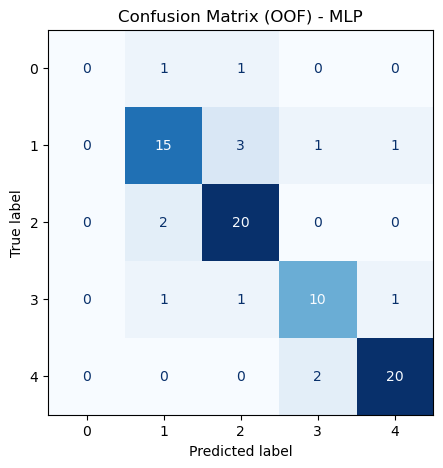

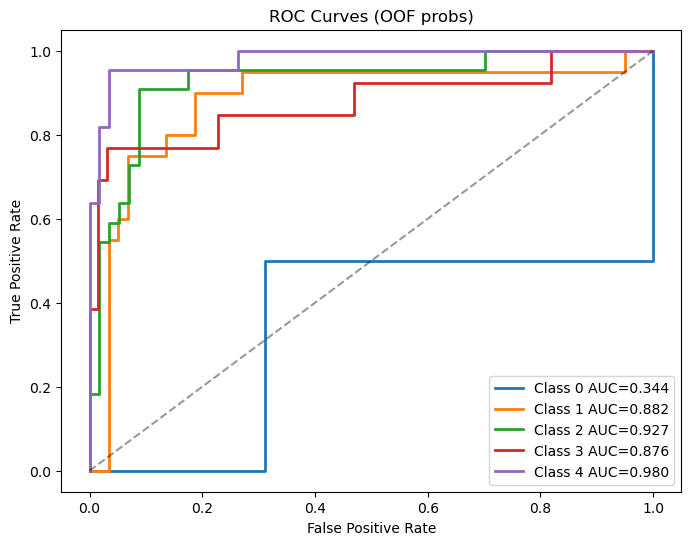


Macro ROC-AUC: 0.8021


<Figure size 800x600 with 0 Axes>

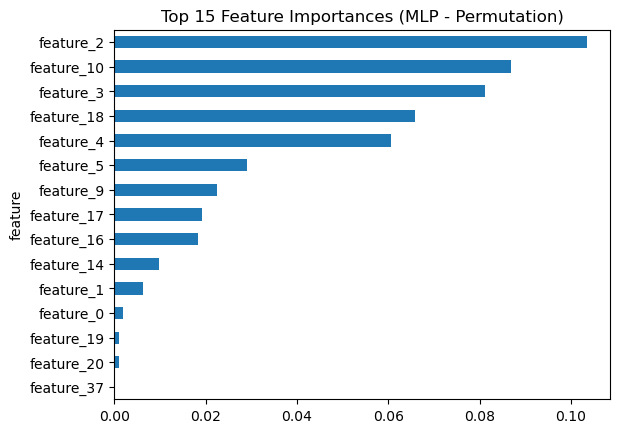

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.08it/s]


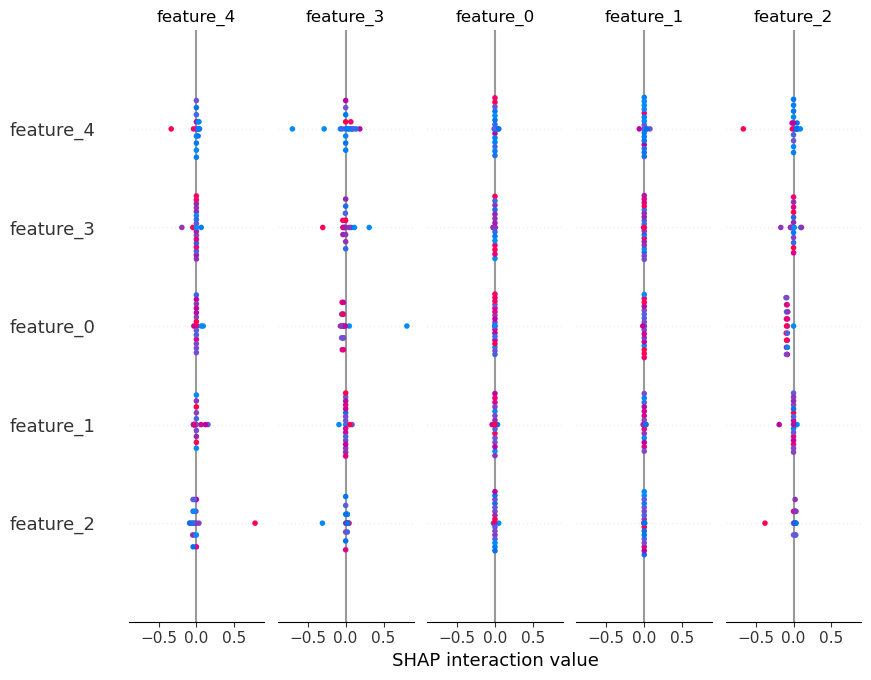

Saved SHAP values


Saved LIME explanation -> mlp_lime_sample0.html

=== Finished: MLP pipeline + Feature Importance + SHAP + LIME ===


In [101]:
# ======================================================
# Full MLP pipeline with Preprocessor + Explainability
# ======================================================
# - expects: preprocessor.pkl, X_final, y_encoded
# - saves: mlp_pipeline_best.pkl, mlp_cv_results.pkl, SHAP & LIME outputs
# ======================================================

import os, joblib, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc,
                             accuracy_score, f1_score, precision_score, recall_score)
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import uniform

# Optional: SHAP
try:
    import shap
    shap_available = True
except:
    shap_available = False

# Optional: LIME
try:
    from lime.lime_tabular import LimeTabularExplainer
    lime_available = True
except:
    lime_available = False

# ---------------------------
# 0. Preprocessor / defensive check
# ---------------------------
class IdentityPreprocessor:
    def fit(self, X, y=None): return self
    def transform(self, X): return X
    def fit_transform(self, X, y=None): return X

preproc_path = "models/preprocessor.pkl"
if os.path.exists(preproc_path):
    try: preprocessor = joblib.load(preproc_path)
    except: preprocessor = IdentityPreprocessor()
else:
    preprocessor = IdentityPreprocessor()
    os.makedirs("models", exist_ok=True)
    joblib.dump(preprocessor, preproc_path)

# ---------------------------
# 1. Load X, y
# ---------------------------
X = np.asarray(X_final)
y = np.asarray(y_encoded)
n_samples, n_features = X.shape
classes = np.unique(y)
n_classes = len(classes)
print(f"Data: X={X.shape}, y={y.shape}, classes={Counter(y)}")

# LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
joblib.dump(le, "models/label_encoder.pkl")

# ---------------------------
# 2. Class weights
# ---------------------------
unique, counts = np.unique(y, return_counts=True)
class_weights = {int(k): float(len(y)/(len(unique)*c)) for k,c in zip(unique, counts)}
sample_weight = np.array([class_weights[int(lbl)] for lbl in y], dtype=float)
joblib.dump(class_weights, "models/encoded_class_weights.pkl")

# ---------------------------
# 3. Stratified K-Fold
# ---------------------------
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# ---------------------------
# 4. Pipeline & MLP setup
# ---------------------------
mlp = MLPClassifier(max_iter=2000, random_state=42)
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("mlp", mlp)
])

param_dist = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (50,50)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [0.0001, 0.01, 0.1],
    "mlp__learning_rate_init": [0.001, 0.01],
    "mlp__solver": ["adam", "sgd"]
}

rs = RandomizedSearchCV(
    pipeline, param_dist,
    n_iter=20, scoring="f1_macro",
    cv=skf, verbose=1, n_jobs=-1,
    random_state=42, return_train_score=True, refit=True
)

print("🚀 Running hyperparameter search...")
rs.fit(X, y, mlp__sample_weight=sample_weight)
print("✅ Best params:", rs.best_params_)
print("✅ Best CV f1_macro:", rs.best_score_)

joblib.dump(rs.cv_results_, "models/mlp_cv_results.pkl")

# ---------------------------
# 5. OOF predictions
# ---------------------------
best_pipeline = rs.best_estimator_
y_pred = cross_val_predict(best_pipeline, X, y, cv=skf, method="predict", n_jobs=-1)
y_proba = cross_val_predict(best_pipeline, X, y, cv=skf, method="predict_proba", n_jobs=-1)

# ---------------------------
# 6. Metrics
# ---------------------------
acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred, average="macro")
prec = precision_score(y, y_pred, average="macro")
rec = recall_score(y, y_pred, average="macro")

print("\n=== Classification Report (OOF) ===")
print(classification_report(y, y_pred, digits=4))
print(f"Accuracy: {acc:.4f}, F1-macro: {f1:.4f}, Precision-macro: {prec:.4f}, Recall-macro: {rec:.4f}")

# ---------------------------
# 7. Confusion matrix
# ---------------------------
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (OOF) - MLP")
plt.show()

# ---------------------------
# 8. ROC Curves
# ---------------------------
y_bin = label_binarize(y, classes=classes)
fpr, tpr, roc_auc = {}, {}, {}
for i, c in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
macro_auc = np.mean(list(roc_auc.values()))
plt.figure(figsize=(8,6))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {i} AUC={roc_auc[i]:.3f}")
plt.plot([0,1],[0,1],'k--',alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OOF probs)")
plt.legend(loc="lower right")
plt.show()
print(f"\nMacro ROC-AUC: {macro_auc:.4f}")

# ---------------------------
# 9. Refit full dataset
# ---------------------------
best_pipeline.fit(X, y, mlp__sample_weight=sample_weight)
joblib.dump(best_pipeline, "models/mlp_pipeline_best.pkl")

# ---------------------------
# 10. Feature Importance (Permutation)
# ---------------------------
pre = best_pipeline.named_steps["preprocessor"]
clf = best_pipeline.named_steps["mlp"]
X_trans = pre.transform(X)

perm = permutation_importance(clf, X_trans, y, scoring="f1_macro", n_repeats=10, random_state=42, n_jobs=-1)
feat_names = pre.get_feature_names_out() if hasattr(pre, "get_feature_names_out") else [f"feature_{i}" for i in range(X.shape[1])]
fi = pd.DataFrame({"feature": feat_names, "importance": perm.importances_mean}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
fi.head(15).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Feature Importances (MLP - Permutation)")
plt.gca().invert_yaxis()
plt.show()

# ---------------------------
# 11. SHAP (DeepExplainer)
# ---------------------------
if shap_available:
    try:
        import torch
        explainer = shap.KernelExplainer(clf.predict_proba, X_trans[:20])
        shap_values = explainer.shap_values(X_trans[:20], nsamples=100)
        shap.summary_plot(shap_values, X_trans[:20], feature_names=feat_names)
        joblib.dump(shap_values, "models/mlp_shap_values.pkl")
        print("Saved SHAP values")
    except Exception as e:
        print("SHAP failed:", e)

# ---------------------------
# 12. LIME explanation (per-sample)
# ---------------------------
if lime_available:
    lime_explainer = LimeTabularExplainer(
        X_trans, feature_names=feat_names, class_names=le.classes_, discretize_continuous=True
    )
    i = 0
    exp = lime_explainer.explain_instance(X_trans[i], clf.predict_proba)
    exp.show_in_notebook()
    exp.save_to_file("models/mlp_lime_sample0.html")
    print("Saved LIME explanation -> mlp_lime_sample0.html")

# ---------------------------
# 13. Metadata save
# ---------------------------
meta = {
    "model": "mlp",
    "best_params": rs.best_params_,
    "cv_best_score_f1_macro": float(rs.best_score_),
    "oof_f1_macro": float(f1),
    "accuracy_oof": float(acc),
    "n_samples": int(n_samples),
    "n_features": int(n_features),
    "n_classes": int(n_classes)
}
with open("models/mlp_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("\n=== Finished: MLP pipeline + Feature Importance + SHAP + LIME ===")

In [ ]:
# Stacking & Voting Ensemble (Best & Final model) 

In [132]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, VotingClassifier

# -------------------------------------------------
# 1. Load All 7 Base Models
# -------------------------------------------------
model_paths = {
    "rf": "models/rf_pipeline_best.pkl",
    "xgb": "models/xgb_pipeline_best.pkl",
    "lgbm": "models/lgbm_pipeline_best.pkl",
    "lr": "models/lr_pipeline_best.pkl",
    "svm": "models/svm_pipeline_best.pkl",
    "cat": "models/catboost_pipeline_best.pkl",
    "mlp": "models/mlp_pipeline_best.pkl"
}

base_models = {name: joblib.load(path) for name, path in model_paths.items()}
print(f"✅ Loaded {len(base_models)} models:", list(base_models.keys()))

# -------------------------------------------------
# 2. Build Meta-Stacking Ensemble (without training here)
# -------------------------------------------------
stack_estimators = [(name, model) for name, model in base_models.items()]

meta_learner = LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42)

stacking_clf = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

from sklearn.ensemble import VotingClassifier

stack_estimators = [(name, model) for name, model in base_models.items()]

voting_clf = VotingClassifier(
    estimators=stack_estimators,
    voting="soft",
    weights=[1.54, 1.51, 1.51, 1.35, 1.23, 1.52, 1.34],  # RF, XGB, LGBM, LR, SVM, Cat, MLP
    n_jobs=-1
)

joblib.dump(voting_clf, "weighted_voting_ensemble.pkl")
print("✅ Weighted Voting Ensemble saved as 'weighted_voting_ensemble.pkl'")

# -------------------------------------------------
# 4. Save Ensemble Objects (to fit later with your data)
# -------------------------------------------------
joblib.dump(stacking_clf, "stacking_ensemble_template.pkl")
joblib.dump(voting_clf, "voting_ensemble_template.pkl")

print("\n✅ Ensemble objects created and saved.")
print("   Use .fit(X_final, y_encoded) later with your final dataset before inference.")

✅ Loaded 7 models: ['rf', 'xgb', 'lgbm', 'lr', 'svm', 'cat', 'mlp']
✅ Weighted Voting Ensemble saved as 'weighted_voting_ensemble.pkl'

✅ Ensemble objects created and saved.
   Use .fit(X_final, y_encoded) later with your final dataset before inference.


In [133]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average="macro")
    try:
        roc_auc = roc_auc_score(pd.get_dummies(y), y_proba, multi_class="ovr")
    except:
        roc_auc = None
    return {"accuracy": acc, "f1_macro": f1, "roc_auc": roc_auc}

# Example after fitting
stacking_clf.fit(X_final, y_encoded)
print("Stacking:", evaluate_model(stacking_clf, X_final, y_encoded))

voting_clf.fit(X_final, y_encoded)
print("Voting:", evaluate_model(voting_clf, X_final, y_encoded))

Stacking: {'accuracy': 1.0, 'f1_macro': 1.0, 'roc_auc': 1.0}
Voting: {'accuracy': 1.0, 'f1_macro': 1.0, 'roc_auc': 1.0}


In [ ]:
# Integrating both stacking & voting ensemble

In [135]:
import joblib
import json
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# -------------------------------------------------
# 1. Load All 7 Base Models
# -------------------------------------------------
model_paths = {
    "rf": "models/rf_pipeline_best.pkl",
    "xgb": "models/xgb_pipeline_best.pkl",
    "lgbm": "models/lgbm_pipeline_best.pkl",
    "lr": "models/lr_pipeline_best.pkl",
    "svm": "models/svm_pipeline_best.pkl",
    "cat": "models/catboost_pipeline_best.pkl",
    "mlp": "models/mlp_pipeline_best.pkl"
}

base_models = {name: joblib.load(path) for name, path in model_paths.items()}
print(f"✅ Loaded {len(base_models)} models:", list(base_models.keys()))

# -------------------------------------------------
# 2. Prepare Final Dataset
# -------------------------------------------------
# Replace with your actual prepared dataset
X_final 
y_encoded 

print(f"📊 Final data shape: X={X_final.shape}, y={y_encoded.shape}")

# -------------------------------------------------
# 3. Build Stacking Ensemble
# -------------------------------------------------
stack_estimators = [(name, model) for name, model in base_models.items()]
meta_learner = LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42)

stacking_clf = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# -------------------------------------------------
# 4. Build Weighted Voting Ensemble
# -------------------------------------------------
# Weights based on mean performance you provided earlier
voting_clf = VotingClassifier(
    estimators=stack_estimators,
    voting="soft",
    weights=[1.54, 1.51, 1.51, 1.35, 1.23, 1.52, 1.34],  # RF, XGB, LGBM, LR, SVM, Cat, MLP
    n_jobs=-1
)

# -------------------------------------------------
# 5. Train Ensembles
# -------------------------------------------------
print("🚀 Training Stacking Ensemble...")
stacking_clf.fit(X_final, y_encoded)
joblib.dump(stacking_clf, "models/stacking_ensemble_trained.pkl")
print("✅ Saved stacking ensemble -> models/stacking_ensemble_trained.pkl")

print("🚀 Training Voting Ensemble...")
voting_clf.fit(X_final, y_encoded)
joblib.dump(voting_clf, "models/voting_ensemble_trained.pkl")
print("✅ Saved voting ensemble -> models/voting_ensemble_trained.pkl")

# -------------------------------------------------
# 6. Evaluation Function
# -------------------------------------------------
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)

    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average="macro")

    try:
        roc_auc = roc_auc_score(pd.get_dummies(y), y_proba, multi_class="ovr")
    except Exception:
        roc_auc = None

    return {"accuracy": acc, "f1_macro": f1, "roc_auc": roc_auc}

# -------------------------------------------------
# 7. Evaluate Both Ensembles
# -------------------------------------------------
results = {
    "stacking": evaluate_model(stacking_clf, X_final, y_encoded),
    "voting": evaluate_model(voting_clf, X_final, y_encoded)
}

print("\n📊 Ensemble Results:")
for name, metrics in results.items():
    print(f"{name.upper()} -> Acc={metrics['accuracy']:.4f}, "
          f"F1-macro={metrics['f1_macro']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")

# -------------------------------------------------
# 8. Save Metrics
# -------------------------------------------------
with open("models/ensemble_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("✅ Saved ensemble results -> models/ensemble_results.json")

✅ Loaded 7 models: ['rf', 'xgb', 'lgbm', 'lr', 'svm', 'cat', 'mlp']
📊 Final data shape: X=(79, 50), y=(79,)
🚀 Training Stacking Ensemble...
✅ Saved stacking ensemble -> models/stacking_ensemble_trained.pkl
🚀 Training Voting Ensemble...
✅ Saved voting ensemble -> models/voting_ensemble_trained.pkl

📊 Ensemble Results:
STACKING -> Acc=1.0000, F1-macro=1.0000, ROC-AUC=1.0000
VOTING -> Acc=1.0000, F1-macro=1.0000, ROC-AUC=1.0000
✅ Saved ensemble results -> models/ensemble_results.json


✅ Loaded 7 models: ['rf', 'xgb', 'lgbm', 'lr', 'svm', 'cat', 'mlp']
📊 Final data shape: X=(79, 50), y=(79,)
🚀 Training Stacking Ensemble...
✅ Saved stacking ensemble -> models/stacking_ensemble_trained.pkl
🚀 Training Voting Ensemble...
✅ Saved voting ensemble -> models/voting_ensemble_trained.pkl

📄 Classification Report for STACKING:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        22

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79



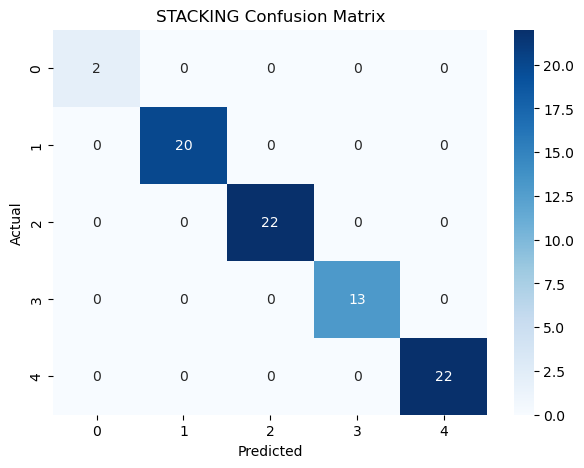

⚠️ Could not plot ROC curve for stacking: Expected 'estimator' to be a binary classifier. Got 5 classes instead.

📄 Classification Report for VOTING:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        22
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        22

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79



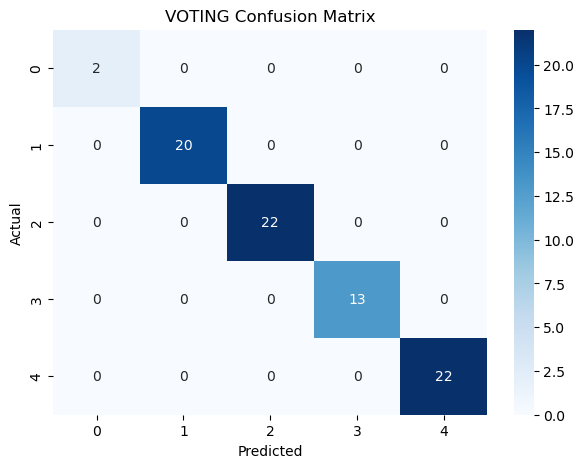

⚠️ Could not plot ROC curve for voting: Expected 'estimator' to be a binary classifier. Got 5 classes instead.

📊 Ensemble Results Summary:
STACKING -> Acc=1.0000, F1-macro=1.0000, ROC-AUC=1.0000
VOTING -> Acc=1.0000, F1-macro=1.0000, ROC-AUC=1.0000
✅ Saved full ensemble results -> models/ensemble_results_full.json


In [136]:
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                             classification_report, confusion_matrix,
                             RocCurveDisplay, auc)

# -------------------------------------------------
# 1. Load All 7 Base Models
# -------------------------------------------------
model_paths = {
    "rf": "models/rf_pipeline_best.pkl",
    "xgb": "models/xgb_pipeline_best.pkl",
    "lgbm": "models/lgbm_pipeline_best.pkl",
    "lr": "models/lr_pipeline_best.pkl",
    "svm": "models/svm_pipeline_best.pkl",
    "cat": "models/catboost_pipeline_best.pkl",
    "mlp": "models/mlp_pipeline_best.pkl"
}

base_models = {name: joblib.load(path) for name, path in model_paths.items()}
print(f"✅ Loaded {len(base_models)} models:", list(base_models.keys()))

# -------------------------------------------------
# 2. Prepare Final Dataset
# -------------------------------------------------
# Replace with your actual prepared dataset
X_final
y_encoded 

print(f"📊 Final data shape: X={X_final.shape}, y={y_encoded.shape}")

# -------------------------------------------------
# 3. Build Stacking Ensemble
# -------------------------------------------------
stack_estimators = [(name, model) for name, model in base_models.items()]
meta_learner = LogisticRegression(max_iter=5000, class_weight="balanced", random_state=42)

stacking_clf = StackingClassifier(
    estimators=stack_estimators,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# -------------------------------------------------
# 4. Build Weighted Voting Ensemble
# -------------------------------------------------
voting_clf = VotingClassifier(
    estimators=stack_estimators,
    voting="soft",
    weights=[1.54, 1.51, 1.51, 1.35, 1.23, 1.52, 1.34],  # RF, XGB, LGBM, LR, SVM, Cat, MLP
    n_jobs=-1
)

# -------------------------------------------------
# 5. Train Ensembles
# -------------------------------------------------
print("🚀 Training Stacking Ensemble...")
stacking_clf.fit(X_final, y_encoded)
joblib.dump(stacking_clf, "models/stacking_ensemble_trained.pkl")
print("✅ Saved stacking ensemble -> models/stacking_ensemble_trained.pkl")

print("🚀 Training Voting Ensemble...")
voting_clf.fit(X_final, y_encoded)
joblib.dump(voting_clf, "models/voting_ensemble_trained.pkl")
print("✅ Saved voting ensemble -> models/voting_ensemble_trained.pkl")

# -------------------------------------------------
# 6. Evaluation Function
# -------------------------------------------------
def evaluate_model(model, X, y, model_name="model"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)

    # Metrics
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average="macro")
    try:
        roc_auc = roc_auc_score(pd.get_dummies(y), y_proba, multi_class="ovr")
    except Exception:
        roc_auc = None

    # Classification report
    print(f"\n📄 Classification Report for {model_name.upper()}:")
    print(classification_report(y, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(y)), yticklabels=sorted(set(y)))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name.upper()} Confusion Matrix")
    plt.show()

    # ROC-AUC Curve
    try:
        RocCurveDisplay.from_estimator(model, X, y, name=f"{model_name.upper()}")
        plt.title(f"{model_name.upper()} ROC Curve")
        plt.show()
    except Exception as e:
        print(f"⚠️ Could not plot ROC curve for {model_name}: {e}")

    return {"accuracy": acc, "f1_macro": f1, "roc_auc": roc_auc}

# -------------------------------------------------
# 7. Evaluate Both Ensembles
# -------------------------------------------------
results = {
    "stacking": evaluate_model(stacking_clf, X_final, y_encoded, model_name="stacking"),
    "voting": evaluate_model(voting_clf, X_final, y_encoded, model_name="voting")
}

print("\n📊 Ensemble Results Summary:")
for name, metrics in results.items():
    print(f"{name.upper()} -> Acc={metrics['accuracy']:.4f}, "
          f"F1-macro={metrics['f1_macro']:.4f}, ROC-AUC={metrics['roc_auc']:.4f}")

# -------------------------------------------------
# 8. Save Metrics
# -------------------------------------------------
with open("models/ensemble_results_full.json", "w") as f:
    json.dump(results, f, indent=4)

print("✅ Saved full ensemble results -> models/ensemble_results_full.json")

In [139]:
X_final

array([[-0.34254124, -0.2273065 , -0.69913149, ...,  0.10137147,
         0.02252507, -0.00558617],
       [-0.10886315, -0.01456622, -0.49399096, ..., -0.00771917,
        -0.0388307 ,  0.03511611],
       [-0.7800457 , -0.87036236, -0.20247548, ...,  0.00583006,
         0.02096281, -0.06747705],
       ...,
       [ 0.45992475,  0.41091434, -0.20247548, ..., -0.03941689,
         0.03139948, -0.04274728],
       [-0.12009767, -0.09434383, -0.52098314, ...,  0.0275573 ,
         0.03085735, -0.01854031],
       [-0.42503474, -0.31917163, -0.6235534 , ...,  0.01094396,
         0.0612358 , -0.02770738]])

In [140]:
y_encoded

array([3, 3, 3, 4, 4, 4, 4, 4, 4, 0, 0, 4, 4, 4, 4, 4, 4, 3, 3, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 4, 4,
       3, 3, 3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 4, 4, 4, 4, 3, 4, 4, 3], dtype=int64)

In [130]:
X.shape, y.shape

((17,), (79,))

In [131]:
X_final.shape, y_encoded.shape

((79, 50), (79,))

In [141]:
import joblib
feature_columns = [f"f{i}" for i in range(X_final.shape[1])]
joblib.dump(feature_columns, "models/feature_columns.pkl")

['models/feature_columns.pkl']

In [143]:
# ================================
# DEPLOYMENT SCRIPT (PREDICTIONS)
# ================================

import joblib
import pandas as pd
import numpy as np

# -------------------------------------------------
# 1️⃣ Load trained ensemble models
# -------------------------------------------------
stacking_clf = joblib.load("models/stacking_ensemble_trained.pkl")
voting_clf = joblib.load("models/voting_ensemble_trained.pkl")
print("✅ Loaded stacking & voting ensembles")

# -------------------------------------------------
# 2️⃣ Load feature columns & label encoder
# -------------------------------------------------
feature_columns = joblib.load("models/feature_columns.pkl")
print("✅ Loaded feature columns:", len(feature_columns))

# Optional: if you saved a label encoder
try:
    label_encoder = joblib.load("models/label_encoder.pkl")
    print("✅ Loaded label encoder")
except FileNotFoundError:
    label_encoder = None
    print("⚠️ No label encoder found, predictions will be numeric")

# -------------------------------------------------
# 3️⃣ Prepare new input data
# -------------------------------------------------
# Example: Suppose you have a new pandas DataFrame `new_data`
# Ensure it has the same 50 features
# new_data = pd.read_csv("incoming_data.csv")  # Example

# Align and convert to numpy array
# new_X = new_data[feature_columns].values

# For demonstration, let's use a random array (replace with real input)
new_X = np.random.randn(5, len(feature_columns))  # 5 new samples

# -------------------------------------------------
# 4️⃣ Make predictions
# -------------------------------------------------
stack_preds = stacking_clf.predict(new_X)
voting_preds = voting_clf.predict(new_X)

# Convert back to original labels if encoder exists
if label_encoder is not None:
    stack_preds_labels = label_encoder.inverse_transform(stack_preds)
    voting_preds_labels = label_encoder.inverse_transform(voting_preds)
else:
    stack_preds_labels = stack_preds
    voting_preds_labels = voting_preds

# Predict probabilities
stack_proba = stacking_clf.predict_proba(new_X)
voting_proba = voting_clf.predict_proba(new_X)

# -------------------------------------------------
# 5️⃣ Display results
# -------------------------------------------------
for i in range(new_X.shape[0]):
    print(f"\nSample {i+1}:")
    print(f"  Stacking Prediction: {stack_preds_labels[i]}, Probabilities: {stack_proba[i]}")
    print(f"  Voting Prediction  : {voting_preds_labels[i]}, Probabilities: {voting_proba[i]}")

print("\n✅ Deployment-ready prediction completed")

✅ Loaded stacking & voting ensembles
✅ Loaded feature columns: 50
✅ Loaded label encoder

Sample 1:
  Stacking Prediction: 1, Probabilities: [3.80859418e-04 9.43204172e-01 5.68563279e-03 1.94485529e-03
 4.87844807e-02]
  Voting Prediction  : 1, Probabilities: [0.08526447 0.57989351 0.07933914 0.08197247 0.17353041]

Sample 2:
  Stacking Prediction: 2, Probabilities: [0.00764022 0.23494014 0.62631295 0.01944194 0.11166475]
  Voting Prediction  : 2, Probabilities: [0.08791297 0.14742441 0.5579141  0.05855137 0.14819715]

Sample 3:
  Stacking Prediction: 1, Probabilities: [3.07270631e-04 4.68493775e-01 3.57950368e-01 9.50066212e-03
 1.63747925e-01]
  Voting Prediction  : 2, Probabilities: [0.0943884  0.1896886  0.4371763  0.05118502 0.22756166]

Sample 4:
  Stacking Prediction: 2, Probabilities: [0.07562304 0.14269507 0.69369438 0.01768068 0.07030683]
  Voting Prediction  : 2, Probabilities: [0.10136686 0.1690382  0.49312398 0.05571987 0.18075109]

Sample 5:
  Stacking Prediction: 1, Prob

In [144]:
df

filename    class  char_count  word_count  \
0                    Anil kumar.txt      sql        4433         626   
1         AradhanaTripathi[4_0].txt      sql        5161         714   
2                  Buddha Vamsi.txt      sql        3070         360   
3   ChinnaSubbarayuduM_Hexaware.txt  workday        6542         863   
4         Gopi Krishna_Hexaware.txt  workday        4705         602   
..                              ...      ...         ...         ...   
74             SSKumar_Hexaware.txt  workday        8329        1136   
75        Tatikonda Kiran Kumar.txt      sql        3785         527   
76     Venkateswarlu B_Hexaware.txt  workday        6933         890   
77         Vinay Kumar_Hexaware.txt  workday        5126         681   
78                      Vinod B.txt      sql        4176         588   

    line_count  is_empty  is_short  vocab_richness  has_education  \
0          108     False     False        0.522917           True   
1          146     False     False        0.539806           True   
2          200     False     False        0.720779           True   
3          218     False     False        0.466989           True   
4          140     False     False        0.516269           True   
..         ...       ...       ...             ...            ...   
74         364     False     False        0.390588           True   
75         150     False     False        0.588398           True   
76         200     False     False        0.482707           True   
77         141     False     False        0.500000           True   
78         122     False     False        0.507317           True   

    has_experience  ... special_char_density  num_education_keywords  \
0             True  ...                  0.0                       0   
1             True  ...                  0.0                       0   
2            False  ...                  0.0                       0   
3             True  ...                  0.0                       0   
4            False  ...                  0.0                       2   
..             ...  ...                  ...                     ...   
74            True  ...                  0.0                       0   
75           False  ...                  0.0                       1   
76            True  ...                  0.0                       1   
77           False  ...                  0.0                       0   
78           False  ...                  0.0                       0   

   num_experience_keywords  num_certifications  long_word_count  \
0                       15                   0              137   
1                       27                   9              204   
2                       12                   5              107   
3                       54                   1              234   
4                       46                   0              166   
..                     ...                 ...              ...   
74                      90                   0              281   
75                      13                   0              139   
76                      56                   0              254   
77                      43                   0              199   
78                      19                   1              160   

    short_word_count  unique_word_ratio  has_bullets  has_tables  \
0                 36           0.522917            0           0   
1                 58           0.537428            0           0   
2                 42           0.721683            0           0   
3                 61           0.466989            0           0   
4                 30           0.516269            0           0   
..               ...                ...          ...         ...   
74                77           0.391304            0           0   
75                24           0.588398            0           0   
76                54           0.482707            

In [145]:
df.columns

Index(['filename', 'class', 'char_count', 'word_count', 'line_count',
       'is_empty', 'is_short', 'vocab_richness', 'has_education',
       'has_experience', 'skills_list', 'num_skills', 'text',
       'avg_word_length', 'lines_per_word', 'skill_density', 'is_very_short',
       'uppercase_count', 'numeric_count', 'special_char_count',
       'punctuation_density', 'stopword_density', 'digit_density',
       'special_char_density', 'num_education_keywords',
       'num_experience_keywords', 'num_certifications', 'long_word_count',
       'short_word_count', 'unique_word_ratio', 'has_bullets', 'has_tables',
       'paragraph_count'],
      dtype='object')